In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use(['dark_background'])

from fem import Fem
from atexpmesh import ArcTanExpMesh
from atplmesh import ArcTanPowerLawMesh
from source import StepSource

from symmetron import SymSolver
from physics import SymPhysics

import numpy as np
import scipy.optimize as sopt
from scipy.special import gamma


import matplotlib.tri as t

In [2]:
# common params
coupling = 'quadratic'
D = 2

mu = 1e0
M = 1e0
lam = 1e-1

In [3]:
num_rho = 67 # "ms" here is properly the source mass in natural units
num_perp = 50
extra_rho = 20

# geometric factor
g = np.pi**(D/2.) / gamma( D/2. + 1. )

log_rho_span = np.linspace(-7., 11., num_rho, endpoint=True ) \
                - np.log10(g)
# add a few more around resonance
extra_rho_span =np.linspace( -1., 1., extra_rho )
log_rho_span = np.append( log_rho_span, extra_rho_span )
log_rho_span = np.sort( log_rho_span )
    
log_perp_span = np.linspace(-10., 9., num_perp, endpoint=True )

log_rho_mg, log_perp_mg = np.meshgrid( log_rho_span, log_perp_span )

In [4]:
# constant rho line (FOR 3D): log(ms) - d*log(x0) = log(rho/g)
# where g is the geometric factor (volume of unit sphere)
# and perp line

log_x0_mg = ( log_perp_mg - D * log_rho_mg ) / (D**2 + 1.) 
log_ms_mg = ( D*log_perp_mg + log_rho_mg ) / (D**2 + 1.)

In [5]:
# keep indices where
# -3 < log(x0) < 1
# -3 < log(ms) < 3

mask_x0 = ( ( log_x0_mg < -3.5 ) | ( log_x0_mg > 1.5 ) )
mask_ms = abs(log_ms_mg) > 3.5
mask = ( mask_x0 | mask_ms )

Text(0,0.5,u'x0')

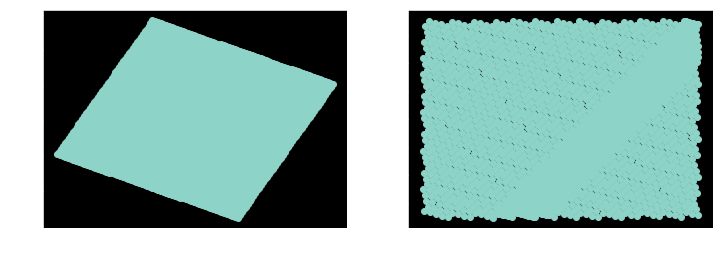

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.scatter( log_x0_mg, log_ms_mg )
plt.xlabel('ms')
plt.ylabel('x0')

plt.subplot(122)
plt.scatter( log_x0_mg[~mask], log_ms_mg[~mask] )
plt.xlabel('ms')
plt.ylabel('x0')

In [7]:
log_ms = np.ma.masked_where( mask, log_ms_mg )
log_x0 = np.ma.masked_where( mask, log_x0_mg )

In [8]:
# initialise arrays of quantities
phi_rs_array = np.zeros_like(log_ms)
grad_rs_array = np.zeros_like(log_ms)
max_grad_array = np.zeros_like(log_ms)
derrick1_array = np.zeros_like(log_ms)
derrick2_array = np.zeros_like(log_ms)
derrick3_array = np.zeros_like(log_ms)
derrick4_array = np.zeros_like(log_ms)
healing_array = np.zeros_like(log_ms)
Healing_array = np.zeros_like(log_ms)
oldcharges_array = np.zeros_like(log_ms)
newcharges_array = np.zeros_like(log_ms)

In [9]:
# giant loop on all the models
counter = 0
i_max, j_max = log_ms.shape

for i in range(i_max):
    for j in range(j_max):
        counter += 1
        
        # I use this instead of compressed to keep original indexing
        if mask[i,j]: continue
        
        x0 = 10.**log_x0[i,j]
        ms = 10.**log_ms[i,j]
        
        print 'Now solving ms = %10.2e\tx0 = %10.2e\n' % (ms,x0)
        
        # get source mass from dimensionless mass parametrisation
        if coupling=='quadratic':
            Ms=ms*mu**(2.-D)*M**2
        elif coupling=='linear':
            Ms=ms*mu**(3.-D)*M/np.sqrt(lam)
            
        # define overall physics object
        physics = SymPhysics( D, coupling, mu, lam, M,
                             Rs=x0/mu, Ms=Ms )
            
        # build mesh and source
        if x0 > 1. :
            mesh = ArcTanExpMesh( physics )
            fem = Fem( mesh, func_degree=3 )
            # more stringent tolerance is needed when x0>1
            abs_res_tol = 1e-15
        else:
            mesh = ArcTanPowerLawMesh( physics )
            fem = Fem( mesh )
            abs_res_tol = 1e-10
        source = StepSource( fem, physics )
        
        # solver
        p = SymSolver( fem, source, physics, 
                      abs_res_tol=abs_res_tol )
        p.solve()
        
        # evaluate radius for screening factors
        healing_array[i,j] = p.r_healing
        Healing_array[i,j] = p.r_healing * x0
        r_eval = 1e1 / x0
        
        vev = physics.Vev

        phi_rs_array[i,j] = p.Phi_rs / vev
        phi_eval = p.Phi(r_eval) / vev
        
        grad_rs_array[i,j] = p.grad_Phi_rs * x0 / (mu*vev)
        grad_eval = p.grad_Phi(r_eval) / (mu*vev)
        
        derrick1_array[i,j] = p.derrick[0]
        derrick2_array[i,j] = p.derrick[1]
        derrick3_array[i,j] = p.derrick[2]
        derrick4_array[i,j] = p.derrick[3]
        
        max_grad_array[i,j] = p.grad_Phi_max * x0/(mu*vev)
    
        p.old_analytics.compute_old_charge()
        p.compute_screening_factor()
        
        oldcharges_array[i,j] = p.old_analytics.old_charge(r_eval)
        newcharges_array[i,j] = p.screening_factor(r_eval)
        
        print '\n***************************************************'
        print '    Model %d of %d done' % ( counter, i_max*j_max )
        print '    (%.2f %%)' % (float(counter)/i_max/j_max*100.)
        print '***************************************************\n'

Now solving ms =   3.30e-04	x0 =   9.17e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.9e-02	rel_dphi = 8.0e-03	abs_res = 7.5e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 58 of 4350 done
    (1.33 %)
***************************************************

Now solving ms =   3.74e-04	x0 =   7.14e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-02	rel_dphi = 4.3e-03	abs_res = 5.8e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 59 of 4350 done
    (1.36 %)
***************************************************

Now solving ms =   4.24e-04	x0 =   5.55e-04

Calling FFC just-in-time (JIT) compil

Non-linear solver, iteration 1	abs_dphi = 2.8e-07	rel_dphi = 9.4e-08	abs_res = 3.3e-11 (tol = 1.0e-10)	rel_res = 1.4e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 228 of 4350 done
    (5.24 %)
***************************************************

Now solving ms =   4.63e-04	x0 =   2.79e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-01	rel_dphi = 5.3e-02	abs_res = 7.6e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.9e-08	rel_dphi = 2.9e-08	abs_res = 5.4e-11 (tol = 1.0e-10)	rel_res = 7.1e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 229 of 4350 done
    (5.26 %)
***************************************************

Now solving ms =   5.25e-04	x0 =   2.17e-03

Calling F


***************************************************
    Model 308 of 4350 done
    (7.08 %)
***************************************************

Now solving ms =   4.00e-04	x0 =   9.09e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e+00	rel_dphi = 6.5e-01	abs_res = 1.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-05	rel_dphi = 4.7e-06	abs_res = 3.8e-11 (tol = 1.0e-10)	rel_res = 3.5e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 309 of 4350 done
    (7.10 %)
***************************************************

Now solving ms =   4.20e-04	x0 =   8.26e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e+00	rel_dphi = 5.1e-01	abs_res = 6.9e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linea

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 323 of 4350 done
    (7.43 %)
***************************************************

Now solving ms =   1.81e-03	x0 =   4.46e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-03	rel_dphi = 3.8e-04	abs_res = 7.7e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 324 of 4350 done
    (7.45 %)
***************************************************

Now solving ms =   2.05e-03	x0 =   3.47e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.0e-04	rel_dphi = 2.2e-04	abs_res = 6.5e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

*************

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e+00	rel_dphi = 6.6e-01	abs_res = 1.4e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-05	rel_dphi = 6.6e-06	abs_res = 3.2e-11 (tol = 1.0e-10)	rel_res = 2.3e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 391 of 4350 done
    (8.99 %)
***************************************************

Now solving ms =   5.04e-04	x0 =   1.40e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e+00	rel_dphi = 7.5e-01	abs_res = 1.8e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-05	rel_dphi = 8.7e-06	abs_res = 3.3e-11 (tol = 1.0e-10)	rel_res = 1.8e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some tim

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.7e-02	rel_dphi = 1.5e-02	abs_res = 1.6e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.9e-08	rel_dphi = 6.1e-09	abs_res = 4.2e-11 (tol = 1.0e-10)	rel_res = 2.6e-01 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 405 of 4350 done
    (9.31 %)
***************************************************

Now solving ms =   1.38e-03	x0 =   1.87e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.6e-02	rel_dphi = 8.0e-03	abs_res = 5.3e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 406 of 4350 done
    (9.33 %)
*****************************************

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-01	rel_dphi = 6.3e-02	abs_res = 1.2e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-07	rel_dphi = 7.2e-08	abs_res = 1.9e-11 (tol = 1.0e-10)	rel_res = 1.6e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 466 of 4350 done
    (10.71 %)
***************************************************

Now solving ms =   4.79e-04	x0 =   3.78e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-01	rel_dphi = 8.1e-02	abs_res = 2.1e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-07	rel_dphi = 1.2e-07	abs_res = 1.9e-11 (tol = 1.0e-10)	rel_res = 9.0e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e+00	rel_dphi = 9.1e-01	abs_res = 4.0e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.3e-05	rel_dphi = 2.0e-05	abs_res = 3.5e-11 (tol = 1.0e-10)	rel_res = 8.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 480 of 4350 done
    (11.03 %)
***************************************************

Now solving ms =   7.79e-04	x0 =   1.43e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e+00	rel_dphi = 8.3e-01	abs_res = 3.4e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.7e-05	rel_dphi = 1.6e-05	abs_res = 3.0e-11 (tol = 1.0e-10)	rel_res = 8.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-02	rel_dphi = 4.3e-03	abs_res = 6.6e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 494 of 4350 done
    (11.36 %)
***************************************************

Now solving ms =   2.53e-03	x0 =   1.36e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.9e-03	rel_dphi = 2.3e-03	abs_res = 4.7e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 495 of 4350 done
    (11.38 %)
***************************************************

Now solving ms =   2.87e-03	x0 =   1.05e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear s

Non-linear solver, iteration 1	abs_dphi = 1.0e-07	rel_dphi = 6.6e-08	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 2.2e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 552 of 4350 done
    (12.69 %)
***************************************************

Now solving ms =   6.53e-04	x0 =   4.98e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-01	rel_dphi = 6.3e-02	abs_res = 1.7e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-07	rel_dphi = 1.1e-07	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 1.3e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 553 of 4350 done
    (12.71 %)
***************************************************

Now solving ms =   6.85e-04	x0 =   4.52e-02

Calling

Non-linear solver, iteration 0	abs_dphi = 1.6e+00	rel_dphi = 7.5e-01	abs_res = 3.8e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.0e-05	rel_dphi = 1.9e-05	abs_res = 2.9e-11 (tol = 1.0e-10)	rel_res = 7.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 566 of 4350 done
    (13.01 %)
***************************************************

Now solving ms =   1.06e-03	x0 =   1.89e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e+00	rel_dphi = 9.1e-01	abs_res = 5.8e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.1e-05	rel_dphi = 2.9e-05	abs_res = 3.5e-11 (tol = 1.0e-10)	rel_res = 6.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.5e-02	rel_dphi = 8.0e-03	abs_res = 1.1e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-08	rel_dphi = 4.2e-09	abs_res = 5.9e-11 (tol = 1.0e-10)	rel_res = 5.3e-01 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 580 of 4350 done
    (13.33 %)
***************************************************

Now solving ms =   3.19e-03	x0 =   2.08e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-02	rel_dphi = 4.3e-03	abs_res = 3.8e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 581 of 4350 done
    (13.36 %)
***************************************

Non-linear solver, iteration 1	abs_dphi = 3.5e-08	rel_dphi = 2.5e-08	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 6.6e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 635 of 4350 done
    (14.60 %)
***************************************************

Now solving ms =   8.07e-04	x0 =   7.96e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.2e-02	rel_dphi = 3.0e-02	abs_res = 4.5e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.7e-08	rel_dphi = 3.3e-08	abs_res = 1.6e-11 (tol = 1.0e-10)	rel_res = 3.6e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 636 of 4350 done
    (14.62 %)
***************************************************

Now solving ms =   8.47e-04	x0 =   7.22e-02

Calling

Non-linear solver, iteration 0	abs_dphi = 6.7e-01	rel_dphi = 3.6e-01	abs_res = 1.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-05	rel_dphi = 6.1e-06	abs_res = 2.5e-11 (tol = 1.0e-10)	rel_res = 2.3e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 649 of 4350 done
    (14.92 %)
***************************************************

Now solving ms =   1.31e-03	x0 =   3.02e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.1e-01	rel_dphi = 3.7e-01	abs_res = 1.2e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-05	rel_dphi = 6.7e-06	abs_res = 2.8e-11 (tol = 1.0e-10)	rel_res = 2.4e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.5e-01	rel_dphi = 9.8e-02	abs_res = 1.5e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-06	rel_dphi = 6.5e-07	abs_res = 3.7e-11 (tol = 1.0e-10)	rel_res = 2.5e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 663 of 4350 done
    (15.24 %)
***************************************************

Now solving ms =   2.76e-03	x0 =   6.80e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-01	rel_dphi = 5.2e-02	abs_res = 4.7e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.3e-07	rel_dphi = 2.0e-07	abs_res = 3.6e-11 (tol = 1.0e-10)	rel_res = 7.6e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_

Non-linear solver, iteration 0	abs_dphi = 5.9e-04	rel_dphi = 8.5e-04	abs_res = 5.5e-12 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 716 of 4350 done
    (16.46 %)
***************************************************

Now solving ms =   6.80e-04	x0 =   2.74e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-03	rel_dphi = 1.7e-03	abs_res = 7.9e-12 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 717 of 4350 done
    (16.48 %)
***************************************************

Now solving ms =   7.71e-04	x0 =   2.13e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-03	rel_dphi = 3.5e-03	abs_res =

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.1e-01	rel_dphi = 1.3e-01	abs_res = 1.8e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-06	rel_dphi = 1.1e-06	abs_res = 1.8e-11 (tol = 1.0e-10)	rel_res = 9.9e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 731 of 4350 done
    (16.80 %)
***************************************************

Now solving ms =   1.62e-03	x0 =   4.83e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-01	rel_dphi = 1.7e-01	abs_res = 3.1e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.2e-06	rel_dphi = 1.9e-06	abs_res = 1.6e-11 (tol = 1.0e-10)	rel_res = 5.1e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e+00	rel_dphi = 5.1e-01	abs_res = 4.2e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.5e-05	rel_dphi = 2.2e-05	abs_res = 2.8e-11 (tol = 1.0e-10)	rel_res = 6.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 745 of 4350 done
    (17.13 %)
***************************************************

Now solving ms =   2.63e-03	x0 =   1.83e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.5e-01	rel_dphi = 4.0e-01	abs_res = 2.7e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.9e-05	rel_dphi = 1.4e-05	abs_res = 3.1e-11 (tol = 1.0e-10)	rel_res = 1.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-03	rel_dphi = 4.0e-04	abs_res = 5.9e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 760 of 4350 done
    (17.47 %)
***************************************************

Now solving ms =   1.38e-02	x0 =   6.60e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-03	rel_dphi = 3.4e-04	abs_res = 8.4e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 761 of 4350 done
    (17.49 %)
***************************************************

Now solving ms =   1.57e-02	x0 =   5.13e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear s

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 796 of 4350 done
    (18.30 %)
***************************************************

Now solving ms =   4.03e-04	x0 =   1.90e+00

Calling FFC just-in-time (JIT)

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 797 of 4350 done
    (18.32 %)
***************************************************

Now solving ms =   4.57e-04	x0 =   1.48e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-06	rel_dphi = 8.3e-06	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-14	rel_dphi = 1.4e-13	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.1e-61	rel_dphi = 1.2e-60	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.8e-04	rel_dphi = 7.8e-04	abs_res = 6.0e-12 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 803 of 4350 done
    (18.46 %)
***************************************************

Now solving ms =   9.71e-04	x0 =   3.27e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-03	rel_dphi = 1.6e-03	abs_res = 7.0e-12 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 804 of 4350 done
    (18.48 %)
***************************************************

Now solving ms =   1.10e-03	x0 =   2.55e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear s


***************************************************
    Model 817 of 4350 done
    (18.78 %)
***************************************************

Now solving ms =   2.20e-03	x0 =   6.36e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-01	rel_dphi = 1.3e-01	abs_res = 2.5e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-06	rel_dphi = 1.7e-06	abs_res = 1.9e-11 (tol = 1.0e-10)	rel_res = 7.6e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 818 of 4350 done
    (18.80 %)
***************************************************

Now solving ms =   2.31e-03	x0 =   5.77e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.7e-01	rel_dphi = 1.7e-01	abs_res = 4.3e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-lin

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 831 of 4350 done
    (19.10 %)
***************************************************

Now solving ms =   3.58e-03	x0 =   2.41e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e+00	rel_dphi = 5.1e-01	abs_res = 6.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.4e-05	rel_dphi = 3.2e-05	abs_res = 2.1e-11 (tol = 1.0e-10)	rel_res = 3.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 832 of 4350 done
    (19.13 %)
***************************************************

Now solving ms =   3.76e-03	x0 =   2.19e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.1e-01	rel_dphi = 4.0e-01	abs_res =

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.1e-03	rel_dphi = 6.3e-04	abs_res = 6.7e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 846 of 4350 done
    (19.45 %)
***************************************************

Now solving ms =   1.75e-02	x0 =   1.01e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-03	rel_dphi = 5.0e-04	abs_res = 4.0e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 847 of 4350 done
    (19.47 %)
***************************************************

Now solving ms =   1.98e-02	x0 =   7.89e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear s

Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	ab

Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC 

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 882 of 4350 done
    (20.28 %)
***************************************************

Now solving ms =   5.08e-04	x0 =   2.92e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.6e-08	rel_dphi = 1.4e-06	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-14	rel_dphi = 2.2e-13	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.8e-60	rel_dphi = 6.7e-59	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.0e-123	rel_dphi = 5.4e-122	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol 

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.9e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-02	rel_dphi = 2.5e-02	abs_res = 8.2e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.7e-08	rel_dphi = 7.8e-08	abs_res = 1.4e-11 (tol = 1.0e-10)	rel_res = 1.7e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 896 of 4350 done
    (20.60 %)
***************************************************

Now solving ms =   2.36e-03	x0 =   1.36e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-02	rel_dphi = 2.8e-02	abs_res = 1.1e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-07	rel_dphi = 1.0e-07	abs_res = 1.4e-11 (tol = 1.0e-10)	rel_res = 1.2e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.7e-01	rel_dphi = 3.5e-01	abs_res = 3.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.2e-05	rel_dphi = 2.0e-05	abs_res = 2.4e-11 (tol = 1.0e-10)	rel_res = 7.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 910 of 4350 done
    (20.92 %)
***************************************************

Now solving ms =   3.82e-03	x0 =   5.16e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.0e-01	rel_dphi = 3.7e-01	abs_res = 3.4e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.6e-05	rel_dphi = 2.2e-05	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 6.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.2e-01	rel_dphi = 9.8e-02	abs_res = 4.4e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.7e-06	rel_dphi = 2.1e-06	abs_res = 3.5e-11 (tol = 1.0e-10)	rel_res = 7.9e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 924 of 4350 done
    (21.24 %)
***************************************************

Now solving ms =   8.06e-03	x0 =   1.16e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-01	rel_dphi = 5.2e-02	abs_res = 1.4e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-06	rel_dphi = 6.5e-07	abs_res = 2.8e-11 (tol = 1.0e-10)	rel_res = 2.0e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some ti

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 938 of 4350 done
    (21.56 %)
***************************************************

Now solving ms =   4.67e-02	x0 =   3.45e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-03	rel_dphi = 7.3e-04	abs_res = 4.9e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.4e-08	rel_dphi = 8.7e-09	abs_res = 6.6e-11 (tol = 1.0e-10)	rel_res = 1.3e-01 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 939 of 4350 done
    (21.59 %)
***************************************************

Now solving ms =   3.42e-04	x0 =   1.58e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.6e-11	rel_dphi = 2.8e-08	abs_res =

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e-10	rel_dphi = 5.2e-08	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.2e-17	rel_dphi = 9.5e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.1e-61	rel_dphi = 1.5e-58	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.5e-125	rel_dphi = 1.0e-122	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.7e-253	rel_dphi = 8.2e-251	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_r

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 7.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 9.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 973 of 4350 done
    (22.37 %)
***************************************************

Now solving ms =   1.20e-03	x0 =   1.28e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.4e-06	rel_dphi = 3.6e-05	abs_res = 1.1e-13 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-05	rel_dphi = 9.9e-05	abs_res = 2.2e-12 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 975 of 4350 done
    (22.41 %)
***************************************************

Now solving ms =   1.54e-03	x0 =   7.73e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.4e-05	rel_dphi = 2.6e-04	abs_res = 3.3e-12 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 976 of 4350 done
    (22.44 %)
***************************************************

Now solving ms =   1.75e-03	x0 =   6.01e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear s

Non-linear solver, iteration 0	abs_dphi = 1.2e-01	rel_dphi = 9.2e-02	abs_res = 2.2e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-06	rel_dphi = 1.8e-06	abs_res = 1.2e-11 (tol = 1.0e-10)	rel_res = 5.4e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 990 of 4350 done
    (22.76 %)
***************************************************

Now solving ms =   4.29e-03	x0 =   1.00e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-01	rel_dphi = 1.0e-01	abs_res = 2.7e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.8e-06	rel_dphi = 2.2e-06	abs_res = 1.5e-11 (tol = 1.0e-10)	rel_res = 5.7e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e+00	rel_dphi = 6.5e-01	abs_res = 1.9e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-04	rel_dphi = 1.1e-04	abs_res = 2.1e-11 (tol = 1.0e-10)	rel_res = 1.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1004 of 4350 done
    (23.08 %)
***************************************************

Now solving ms =   6.97e-03	x0 =   3.79e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e+00	rel_dphi = 6.5e-01	abs_res = 1.9e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-04	rel_dphi = 1.1e-04	abs_res = 2.0e-11 (tol = 1.0e-10)	rel_res = 1.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 1017 of 4350 done
    (23.38 %)
***************************************************

Now solving ms =   2.45e-02	x0 =   3.08e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.0e-03	rel_dphi = 1.7e-03	abs_res = 1.9e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-08	rel_dphi = 4.7e-09	abs_res = 6.0e-11 (tol = 1.0e-10)	rel_res = 3.2e-01 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1018 of 4350 done
    (23.40 %)
***************************************************

Now solving ms =   2.77e-02	x0 =   2.39e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.6e-03	rel_dphi = 1.2e-03	abs_res = 1.9e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 9.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1059 of 4350 done
    (24.34 %)
***************************************************

Now solving ms =   1.51e-03	x0 =   1.96e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-06	rel_dphi = 1.1e-05	abs_res = 4.5e-14 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.5e-06	rel_dphi = 2.8e-05	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.7e-14	rel_dphi = 4.8e-13	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.3e-17	rel_dphi = 5.1e-16	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 8.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1066 of 4350 done
    (24.51 %)
***************************************************

Now solving ms =   3.65e-03	x0 =   3.38e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.0e-03	rel_dphi = 5.7e-03	abs_res = 6.9e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1067 of 4350 done
    (24.53 %)
***************************************************

Now solving ms =   4.13e-03	x0 =   2.63e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.6e-03	rel_dphi = 1.2e-02	abs_res = 2.7e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.0e-08	rel_dphi = 3.6e-08	abs_res

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1080 of 4350 done
    (24.83 %)
***************************************************

Now solving ms =   6.83e-03	x0 =   9.64e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-01	rel_dphi = 1.8e-01	abs_res = 1.3e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-05	rel_dphi = 1.1e-05	abs_res = 1.6e-11 (tol = 1.0e-10)	rel_res = 1.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1081 of 4350 done
    (24.85 %)
***************************************************

Now solving ms =   7.09e-03	x0 =   8.95e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.9e-01	rel_dphi = 2.2e-01	abs_res

Non-linear solver, iteration 1	abs_dphi = 1.2e-04	rel_dphi = 6.6e-05	abs_res = 2.4e-11 (tol = 1.0e-10)	rel_res = 2.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1094 of 4350 done
    (25.15 %)
***************************************************

Now solving ms =   1.13e-02	x0 =   3.53e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.2e-01	rel_dphi = 3.4e-01	abs_res = 8.7e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.0e-05	rel_dphi = 5.0e-05	abs_res = 2.5e-11 (tol = 1.0e-10)	rel_res = 2.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1095 of 4350 done
    (25.17 %)
***************************************************

Now solving ms =   1.15e-02	x0 =   3.39e-02

Calli

Non-linear solver, iteration 0	abs_dphi = 3.6e-03	rel_dphi = 1.1e-03	abs_res = 7.6e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.8e-08	rel_dphi = 1.5e-08	abs_res = 4.6e-11 (tol = 1.0e-10)	rel_res = 6.1e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1108 of 4350 done
    (25.47 %)
***************************************************

Now solving ms =   5.78e-02	x0 =   1.35e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.7e-03	rel_dphi = 1.1e-03	abs_res = 1.0e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.5e-08	rel_dphi = 2.0e-08	abs_res = 4.9e-11 (tol = 1.0e-10)	rel_res = 4.9e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 1.6e+00 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1145 of 4350 done
    (26.32 %)
***************************************************

Now solving ms =   1.91e-03	x0 =   3.02e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.5e-07	rel_dphi = 4.7e-06	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-14	rel_dphi = 2.0e-13	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-62	rel_dphi = 3.0e-61	abs_res = 2.3e-14 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 2.2e-14	rel_dphi = 2.7e-13	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.2e-59	rel_dphi = 1.5e-58	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-121	rel_dphi = 1.5e-120	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi

Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab


***************************************************
    Model 1157 of 4350 done
    (26.60 %)
***************************************************

Now solving ms =   6.88e-03	x0 =   2.32e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-02	rel_dphi = 2.6e-02	abs_res = 2.3e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.5e-07	rel_dphi = 2.9e-07	abs_res = 1.0e-11 (tol = 1.0e-10)	rel_res = 4.5e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1158 of 4350 done
    (26.62 %)
***************************************************

Now solving ms =   7.22e-03	x0 =   2.11e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-02	rel_dphi = 3.4e-02	abs_res = 4.3e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1171 of 4350 done
    (26.92 %)
***************************************************

Now solving ms =   1.12e-02	x0 =   8.81e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.0e-01	rel_dphi = 3.7e-01	abs_res = 9.4e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.7e-05	rel_dphi = 7.2e-05	abs_res = 1.7e-11 (tol = 1.0e-10)	rel_res = 1.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1172 of 4350 done
    (26.94 %)
***************************************************

Now solving ms =   1.17e-02	x0 =   8.00e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.8e-01	rel_dphi = 4.9e-01	abs_res

Non-linear solver, iteration 1	abs_dphi = 1.3e-05	rel_dphi = 6.7e-06	abs_res = 3.8e-11 (tol = 1.0e-10)	rel_res = 3.0e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1185 of 4350 done
    (27.24 %)
***************************************************

Now solving ms =   2.35e-02	x0 =   1.99e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-01	rel_dphi = 5.1e-02	abs_res = 4.2e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.2e-06	rel_dphi = 2.1e-06	abs_res = 3.1e-11 (tol = 1.0e-10)	rel_res = 7.4e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1186 of 4350 done
    (27.26 %)
***************************************************

Now solving ms =   2.67e-02	x0 =   1.54e-02

Calli

Non-linear solver, iteration 0	abs_dphi = 6.1e-03	rel_dphi = 1.9e-03	abs_res = 6.5e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.1e-07	rel_dphi = 1.3e-07	abs_res = 6.2e-11 (tol = 1.0e-10)	rel_res = 9.6e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1199 of 4350 done
    (27.56 %)
***************************************************

Now solving ms =   1.36e-01	x0 =   5.90e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.6e-03	rel_dphi = 2.0e-03	abs_res = 8.5e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.5e-07	rel_dphi = 1.6e-07	abs_res = 4.3e-11 (tol = 1.0e-10)	rel_res = 5.1e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1229 of 4350 done
    (28.25 %)
***************************************************

Now solving ms =   1.87e-03	x0 =   7.67e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.5e-09	rel_dphi = 6.4e-07	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.5e-16	rel_dphi = 6.5e-14	abs_res = 5.0e-15 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e-08	rel_dphi = 1.2e-06	abs_res = 7.7e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-15	rel_dphi = 1.1e-13	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.5e-61	rel_dphi = 1.1e-59	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.0e-125	rel_dphi = 1.4e-123	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 1	abs_dphi = 3.7e-06	rel_dphi = 3.7e-06	abs_res = 1.0e-11 (tol = 1.0e-10)	rel_res = 3.0e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1250 of 4350 done
    (28.74 %)
***************************************************

Now solving ms =   1.23e-02	x0 =   1.77e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.7e-02	rel_dphi = 8.7e-02	abs_res = 5.0e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.4e-06	rel_dphi = 5.3e-06	abs_res = 9.3e-12 (tol = 1.0e-10)	rel_res = 1.9e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1251 of 4350 done
    (28.76 %)
***************************************************

Now solving ms =   1.25e-02	x0 =   1.71e-01

Calli

Non-linear solver, iteration 0	abs_dphi = 1.2e+00	rel_dphi = 8.2e-01	abs_res = 8.3e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.5e-04	rel_dphi = 5.9e-04	abs_res = 2.5e-11 (tol = 1.0e-10)	rel_res = 3.0e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1264 of 4350 done
    (29.06 %)
***************************************************

Now solving ms =   2.03e-02	x0 =   6.49e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.6e-01	rel_dphi = 6.4e-01	abs_res = 5.3e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.5e-04	rel_dphi = 3.7e-04	abs_res = 1.8e-11 (tol = 1.0e-10)	rel_res = 3.3e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.7e-03	rel_dphi = 3.5e-03	abs_res = 2.4e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-07	rel_dphi = 6.6e-08	abs_res = 3.6e-11 (tol = 1.0e-10)	rel_res = 1.5e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1278 of 4350 done
    (29.38 %)
***************************************************

Now solving ms =   7.14e-02	x0 =   5.26e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.8e-03	rel_dphi = 2.6e-03	abs_res = 2.6e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-07	rel_dphi = 6.3e-08	abs_res = 3.4e-11 (tol = 1.0e-10)	rel_res = 1.3e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-10	rel_dphi = 9.6e-08	abs_res = 9.5e-16 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1314 of 4350 done
    (30.21 %)
***************************************************

Now solving ms =   2.08e-03	x0 =   1.51e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.9e-10	rel_dphi = 1.8e-07	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-17	rel_dphi = 1.0e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.2e-60	rel_dphi = 5.5e-58	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-123	rel_dphi =

Non-linear solver, iteration 2	abs_dphi = 2.7e-60	rel_dphi = 7.6e-58	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 7.3e-123	rel_dphi = 2.0e-120	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 5.1e-248	rel_dphi = 1.4e-245	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dp

Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_

Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	ab

Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 27	ab

Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 33	ab

Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 39	ab

Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	ab

Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC 

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1324 of 4350 done
    (30.44 %)
***************************************************

Now solving ms =   7.30e-03	x0 =   1.23e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.4e-05	rel_dphi = 2.5e-04	abs_res = 1.6e-13 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.8e-12	rel_dphi = 3.1e-11	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.0e-15	rel_dphi = 2.8e-14	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.1e-16	rel_dphi = 5.1e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 7.7e-01 (tol =

Non-linear solver, iteration 0	abs_dphi = 6.7e-04	rel_dphi = 1.8e-03	abs_res = 2.5e-11 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1327 of 4350 done
    (30.51 %)
***************************************************

Now solving ms =   1.06e-02	x0 =   5.78e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-03	rel_dphi = 4.2e-03	abs_res = 1.5e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.3e-09	rel_dphi = 1.3e-08	abs_res = 5.4e-12 (tol = 1.0e-10)	rel_res = 3.7e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1328 of 4350 done
    (30.53 %)
***************************************************

Now solving ms =   1.21e-02	x0 =   4.50e-01

Calli

Non-linear solver, iteration 0	abs_dphi = 1.6e-01	rel_dphi = 1.6e-01	abs_res = 2.7e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.9e-05	rel_dphi = 2.8e-05	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 4.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1341 of 4350 done
    (30.83 %)
***************************************************

Now solving ms =   1.99e-02	x0 =   1.65e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-01	rel_dphi = 1.7e-01	abs_res = 3.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.3e-05	rel_dphi = 3.2e-05	abs_res = 1.1e-11 (tol = 1.0e-10)	rel_res = 3.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.8e-01	rel_dphi = 3.9e-01	abs_res = 3.1e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.2e-04	rel_dphi = 2.1e-04	abs_res = 2.1e-11 (tol = 1.0e-10)	rel_res = 6.7e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1355 of 4350 done
    (31.15 %)
***************************************************

Now solving ms =   3.30e-02	x0 =   6.03e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.1e-01	rel_dphi = 3.4e-01	abs_res = 2.4e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.4e-04	rel_dphi = 1.6e-04	abs_res = 1.9e-11 (tol = 1.0e-10)	rel_res = 7.8e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 1368 of 4350 done
    (31.45 %)
***************************************************

Now solving ms =   1.49e-01	x0 =   2.96e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.6e-03	rel_dphi = 2.8e-03	abs_res = 1.3e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.8e-07	rel_dphi = 2.9e-07	abs_res = 3.3e-11 (tol = 1.0e-10)	rel_res = 2.5e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1369 of 4350 done
    (31.47 %)
***************************************************

Now solving ms =   1.69e-01	x0 =   2.30e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.1e-03	rel_dphi = 3.0e-03	abs_res = 1.7e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	ab

Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	ab

Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1408 of 4350 done
    (32.37 %)
***************************************************

Now solving ms =   7.16e-03	x0 =   3.12e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.1e-07	rel_dphi = 1.6e-05	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.8e-15	rel_dphi = 7.6e-14	abs_res = 2.5e-14 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.7e-06	rel_dphi = 3.4e-05	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.1e-14	rel_dphi = 6.5e-13	abs_res = 4.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.4e-126	rel_dphi = 4.3e-125	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1419 of 4350 done
    (32.62 %)
***************************************************

Now solving ms =   2.11e-02	x0 =   3.60e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-02	rel_dphi = 2.9e-02	abs_res = 1.1e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.0e-07	rel_dphi = 1.2e-06	abs_res = 6.5e-12 (tol = 1.0e-10)	rel_res = 6.1e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1420 of 4350 done
    (32.64 %)
***************************************************

Now solving ms =   2.21e-02	x0 =   3.27e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-02	rel_dphi = 3.8e-02	abs_res

Non-linear solver, iteration 1	abs_dphi = 2.5e-04	rel_dphi = 2.3e-04	abs_res = 1.4e-11 (tol = 1.0e-10)	rel_res = 6.0e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1433 of 4350 done
    (32.94 %)
***************************************************

Now solving ms =   3.42e-02	x0 =   1.37e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.4e-01	rel_dphi = 4.8e-01	abs_res = 4.4e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.7e-04	rel_dphi = 4.1e-04	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 3.0e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1434 of 4350 done
    (32.97 %)
***************************************************

Now solving ms =   3.59e-02	x0 =   1.24e-01

Calli

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1446 of 4350 done
    (33.24 %)
***************************************************

Now solving ms =   6.87e-02	x0 =   3.39e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.7e-02	rel_dphi = 5.0e-02	abs_res = 1.2e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-05	rel_dphi = 6.5e-06	abs_res = 2.5e-11 (tol = 1.0e-10)	rel_res = 2.1e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1447 of 4350 done
    (33.26 %)
***************************************************

Now solving ms =   7.79e-02	x0 =   2.64e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.1e-02	rel_dphi = 2.7e-02	abs_res

Non-linear solver, iteration 1	abs_dphi = 4.3e-06	rel_dphi = 1.7e-06	abs_res = 3.9e-11 (tol = 1.0e-10)	rel_res = 5.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1460 of 4350 done
    (33.56 %)
***************************************************

Now solving ms =   3.98e-01	x0 =   1.01e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-02	rel_dphi = 4.6e-03	abs_res = 8.8e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.0e-06	rel_dphi = 2.0e-06	abs_res = 5.5e-11 (tol = 1.0e-10)	rel_res = 6.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1461 of 4350 done
    (33.59 %)
***************************************************

Now solving ms =   4.52e-01	x0 =   7.84e-04

Calli

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1493 of 4350 done
    (34.32 %)
***************************************************

Now solving ms =   7.96e-03	x0 =   6.17e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1494 of 4350 done
    (34.34 %)
***************************************************

Now solving ms =   9.03e-03	x0 =   4.80e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-07	rel_dphi = 8.1e-06	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.3e-15	rel_dphi = 2.0e-13	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.4e-61	rel_dphi = 6.3e-60	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 6.4e-125	rel_dphi = 2.9e-123	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 8.6e-01 (tol

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 7.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 1	abs_dphi = 6.8e-06	rel_dphi = 9.3e-06	abs_res = 6.5e-12 (tol = 1.0e-10)	rel_res = 8.2e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1511 of 4350 done
    (34.74 %)
***************************************************

Now solving ms =   3.59e-02	x0 =   3.03e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.8e-02	rel_dphi = 7.7e-02	abs_res = 1.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-05	rel_dphi = 1.4e-05	abs_res = 8.0e-12 (tol = 1.0e-10)	rel_res = 7.2e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1512 of 4350 done
    (34.76 %)
***************************************************

Now solving ms =   3.66e-02	x0 =   2.92e-01

Calli

Non-linear solver, iteration 2	abs_dphi = 3.7e-08	rel_dphi = 3.3e-08	abs_res = 1.9e-11 (tol = 1.0e-10)	rel_res = 7.5e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1524 of 4350 done
    (35.03 %)
***************************************************

Now solving ms =   5.66e-02	x0 =   1.22e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.6e-01	rel_dphi = 8.2e-01	abs_res = 2.2e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-03	rel_dphi = 1.9e-03	abs_res = 5.3e-10 (tol = 1.0e-10)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.9e-08	rel_dphi = 2.5e-08	abs_res = 1.1e-11 (tol = 1.0e-10)	rel_res = 5.1e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 1	abs_dphi = 2.0e-06	rel_dphi = 1.0e-06	abs_res = 3.8e-11 (tol = 1.0e-10)	rel_res = 1.2e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1537 of 4350 done
    (35.33 %)
***************************************************

Now solving ms =   1.62e-01	x0 =   1.49e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-02	rel_dphi = 7.1e-03	abs_res = 2.9e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-06	rel_dphi = 8.3e-07	abs_res = 3.1e-11 (tol = 1.0e-10)	rel_res = 1.1e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1538 of 4350 done
    (35.36 %)
***************************************************

Now solving ms =   1.84e-01	x0 =   1.16e-02

Calli

Non-linear solver, iteration 0	abs_dphi = 1.1e-02	rel_dphi = 5.6e-03	abs_res = 1.9e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-05	rel_dphi = 5.3e-06	abs_res = 2.3e-11 (tol = 1.0e-10)	rel_res = 1.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1551 of 4350 done
    (35.66 %)
***************************************************

Now solving ms =   9.41e-01	x0 =   4.41e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-02	rel_dphi = 5.5e-03	abs_res = 1.9e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-05	rel_dphi = 5.6e-06	abs_res = 3.5e-11 (tol = 1.0e-10)	rel_res = 1.8e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 9.9e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1579 of 4350 done
    (36.30 %)
***************************************************

Now solving ms =   1.00e-02	x0 =   9.48e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1580 of 4350 done
    (36.32 %)
***************************************************

Now solving ms =   1.14e-02	x0 =   7.37e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.9e-08	rel_dphi = 4.2e-06	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-15	rel_dphi = 1.1e-13	abs_res = 5.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-61	rel_dphi = 1.7e-59	abs_res = 5.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.1e-124	rel_dphi = 1.2e-122	abs_res = 5.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 6.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1599 of 4350 done
    (36.76 %)
***************************************************

Now solving ms =   5.23e-02	x0 =   3.49e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.5e-02	rel_dphi = 8.0e-02	abs_res = 2.0e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-05	rel_dphi = 2.2e-05	abs_res = 5.8e-12 (tol = 1.0e-10)	rel_res = 3.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1600 of 4350 done
    (36.78 %)
***************************************************

Now solving ms =   5.49e-02	x0 =   3.17e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.8e-02	rel_dphi = 1.1e-01	abs_res

Non-linear solver, iteration 2	abs_dphi = 7.7e-08	rel_dphi = 7.1e-08	abs_res = 1.6e-11 (tol = 1.0e-10)	rel_res = 5.4e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1612 of 4350 done
    (37.06 %)
***************************************************

Now solving ms =   8.49e-02	x0 =   1.33e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.1e-01	rel_dphi = 6.3e-01	abs_res = 1.9e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.9e-03	rel_dphi = 1.7e-03	abs_res = 6.0e-10 (tol = 1.0e-10)	rel_res = 3.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.2e-08	rel_dphi = 2.9e-08	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 7.1e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 0	abs_dphi = 1.5e-02	rel_dphi = 8.2e-03	abs_res = 6.4e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.5e-06	rel_dphi = 1.9e-06	abs_res = 2.4e-11 (tol = 1.0e-10)	rel_res = 3.8e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1625 of 4350 done
    (37.36 %)
***************************************************

Now solving ms =   2.63e-01	x0 =   1.38e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-02	rel_dphi = 7.0e-03	abs_res = 7.4e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.8e-06	rel_dphi = 2.0e-06	abs_res = 3.4e-11 (tol = 1.0e-10)	rel_res = 4.6e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.9e-03	rel_dphi = 6.0e-03	abs_res = 1.9e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-05	rel_dphi = 8.1e-06	abs_res = 3.7e-11 (tol = 1.0e-10)	rel_res = 2.0e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1639 of 4350 done
    (37.68 %)
***************************************************

Now solving ms =   1.53e+00	x0 =   4.10e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.1e-03	rel_dphi = 5.8e-03	abs_res = 1.8e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-05	rel_dphi = 8.2e-06	abs_res = 4.3e-11 (tol = 1.0e-10)	rel_res = 2.5e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

initial_guess.py:282: RuntimeWarning: invalid value encountered in log
  -1./3. - x1**2/12. + C1*np.log(x1) + C2 ]


Non-linear solver, iteration 0	abs_dphi = 8.9e-03	rel_dphi = 6.9e-03	abs_res = 2.0e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-05	rel_dphi = 1.0e-05	abs_res = 2.4e-11 (tol = 1.0e-10)	rel_res = 1.3e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1641 of 4350 done
    (37.72 %)
***************************************************

Now solving ms =   8.68e-03	x0 =   3.09e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.5e-11	rel_dphi = 1.8e-07	abs_res = 4.2e-16 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1663 of 4350 done
    (38.23 %)
***************************************************

Now solving ms =   9.84e-03	x0 =   2.41e+01

Calli

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.5e+00 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1666 of 4350 done
    (38.30 %)
***************************************************

Now solving ms =   1.43e-02	x0 =   1.13e+01

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1667 of 4350 done
    (38.32 %)
***************************************************

Now solving ms =   1.63e-02	x0 =   8.81e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.7e-08	rel_dphi = 4.2e-06	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.7e-16	rel_dphi = 8.9e-14	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.0e-60	rel_dphi = 7.7e-58	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.5e-122	rel_dphi = 3.9e-120	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-02 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 6.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 6.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 6.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 6.2e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1676 of 4350 done
    (38.53 %)
***************************************************

Now solving ms =   5.04e-02	x0 =   9.19e-01

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.4e-02	rel_dphi = 1.4e-01	abs_res = 8.6e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.8e-05	rel_dphi = 9.9e-05	abs_res = 9.6e-12 (tol = 1.0e-10)	rel_res = 1.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1689 of 4350 done
    (38.83 %)
***************************************************

Now solving ms =   8.32e-02	x0 =   3.36e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-01	rel_dphi = 1.5e-01	abs_res = 9.9e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.0e-05	rel_dphi = 1.1e-04	abs_res = 6.3e-12 (tol = 1.0e-10)	rel_res = 6.4e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Non-linear solver, iteration 1	abs_dphi = 2.6e-03	rel_dphi = 2.5e-03	abs_res = 1.5e-09 (tol = 1.0e-10)	rel_res = 6.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.3e-08	rel_dphi = 8.0e-08	abs_res = 9.9e-12 (tol = 1.0e-10)	rel_res = 4.0e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1701 of 4350 done
    (39.10 %)
***************************************************

Now solving ms =   1.27e-01	x0 =   1.44e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.2e-01	rel_dphi = 4.8e-01	abs_res = 1.6e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-03	rel_dphi = 1.5e-03	abs_res = 6.4e-10 (tol = 1.0e-10)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.4e-08	rel_dphi = 3.2e-08	abs_res = 1.4e-11 (tol = 1.0e-10)	rel_res = 8.7e-07 (tol =

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-02	rel_dphi = 8.3e-03	abs_res = 1.9e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.1e-06	rel_dphi = 5.1e-06	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 1.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1714 of 4350 done
    (39.40 %)
***************************************************

Now solving ms =   4.83e-01	x0 =   9.99e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-02	rel_dphi = 8.2e-03	abs_res = 2.2e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-05	rel_dphi = 5.8e-06	abs_res = 3.1e-11 (tol = 1.0e-10)	rel_res = 1.4e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 1727 of 4350 done
    (39.70 %)
***************************************************

Now solving ms =   2.47e+00	x0 =   3.81e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.6e-03	rel_dphi = 7.6e-03	abs_res = 2.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-05	rel_dphi = 1.4e-05	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 1.0e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1728 of 4350 done
    (39.72 %)
***************************************************

Now solving ms =   1.41e-02	x0 =   2.88e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.1e-10	rel_dphi = 3.4e-07	abs_res = 4.4e-16 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calli

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.6e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1753 of 4350 done
    (40.30 %)
***************************************************

Now solving ms =   2.05e-02	x0 =   1.35e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.1e-09	rel_dphi = 2.2e-06	abs_res = 2.6e-15 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-08	rel_dphi = 4.2e-06	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.2e-16	rel_dphi = 7.0e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 4.4e-60	rel_dphi = 9.8e-58	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.9e-121	rel_dphi = 4.2e-119	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 5.9e-244	rel_dphi = 1.3e-241	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_r

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.4e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 8.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.2e-02 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 4.7e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 4.7e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 4.7e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1763 of 4350 done
    (40.53 %)
***************************************************

Now solving ms =   7.20e-02	x0 =   1.10e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.4e-04	rel_dphi = 3.8e-03	abs_res = 1.2e-10 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.7e-03	rel_dphi = 8.6e-03	abs_res = 5.0e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-07	rel_dphi = 4.2e-07	abs_res = 2.0e-12 (tol = 1.0e-10)	rel_res = 4.1e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1765 of 4350 done
    (40.57 %)
***************************************************

Now solving ms =   8.16e-02	x0 =   8.54e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.4e-03	rel_dphi = 1.0e-02	abs_res = 7.2e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-07	rel_dphi = 6.1e-07	abs_res = 2.2e-12 (tol = 1.0e-10)	rel_res = 3.1e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 1778 of 4350 done
    (40.87 %)
***************************************************

Now solving ms =   1.30e-01	x0 =   3.39e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-01	rel_dphi = 2.4e-01	abs_res = 4.0e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.2e-04	rel_dphi = 4.6e-04	abs_res = 2.6e-11 (tol = 1.0e-10)	rel_res = 6.6e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1779 of 4350 done
    (40.90 %)
***************************************************

Now solving ms =   1.35e-01	x0 =   3.13e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.2e-01	rel_dphi = 3.1e-01	abs_res = 6.5e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Non-linear solver, iteration 1	abs_dphi = 1.3e-03	rel_dphi = 1.3e-03	abs_res = 6.5e-10 (tol = 1.0e-10)	rel_res = 5.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.4e-08	rel_dphi = 3.3e-08	abs_res = 1.1e-11 (tol = 1.0e-10)	rel_res = 8.3e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1790 of 4350 done
    (41.15 %)
***************************************************

Now solving ms =   1.97e-01	x0 =   1.47e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-01	rel_dphi = 3.1e-01	abs_res = 1.0e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.9e-04	rel_dphi = 9.5e-04	abs_res = 3.9e-10 (tol = 1.0e-10)	rel_res = 3.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.0e-08	rel_dphi = 1.9e-08	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 1.3e-06 (tol =

Non-linear solver, iteration 1	abs_dphi = 1.9e-05	rel_dphi = 1.2e-05	abs_res = 2.4e-11 (tol = 1.0e-10)	rel_res = 5.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1803 of 4350 done
    (41.45 %)
***************************************************

Now solving ms =   8.87e-01	x0 =   7.23e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-02	rel_dphi = 9.0e-03	abs_res = 4.5e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.9e-05	rel_dphi = 1.3e-05	abs_res = 3.2e-11 (tol = 1.0e-10)	rel_res = 7.2e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1804 of 4350 done
    (41.47 %)
***************************************************

Now solving ms =   1.01e+00	x0 =   5.62e-03

Calli

Non-linear solver, iteration 0	abs_dphi = 4.4e-10	rel_dphi = 6.4e-07	abs_res = 4.3e-16 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1839 of 4350 done
    (42.28 %)
***************************************************

Now solving ms =   2.58e-02	x0 =   2.08e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-09	rel_dphi = 1.2e-06	abs_res = 8.4e-16 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1840 of 4350 done
    (42.30 %)
***************************************************

Now solving ms =   2.93e-02	x0 =   1.62e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.3e-09	rel_dphi = 2.2e-06	abs_res

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1842 of 4350 done
    (42.34 %)
***************************************************

Now solving ms =   3.77e-02	x0 =   9.80e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.1e-08	rel_dphi = 7.9e-06	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-16	rel_dphi = 4.3e-14	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.6e-18	rel_dphi = 5.0e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.6e-124	rel_dphi = 8.8e-122	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.3e+00 (tol

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 7.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 2.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1851 of 4350 done
    (42.55 %)
***************************************************

Now solving ms =   1.14e-01	x0 =   1.07e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1852 of 4350 done
    (42.57 %)
***************************************************

Now solving ms =   1.17e-01	x0 =   1.02e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.2e-03	rel_dphi = 8.0e-03	abs_res = 8.7e-10 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-07	rel_dphi = 5.4e-07	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 2.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 9.8e-14	rel_dphi = 3.6e-13	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.7e-15	rel_dphi = 6.2e-15	abs_res = 1.4e-13 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 8.3e-17	rel_dphi = 3.1e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol =

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.6e-03	rel_dphi = 1.5e-02	abs_res = 2.2e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.0e-07	rel_dphi = 1.9e-06	abs_res = 2.6e-12 (tol = 1.0e-10)	rel_res = 1.2e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1855 of 4350 done
    (42.64 %)
***************************************************

Now solving ms =   1.32e-01	x0 =   7.98e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.4e-03	rel_dphi = 2.1e-02	abs_res = 4.8e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-06	rel_dphi = 4.1e-06	abs_res = 2.7e-12 (tol = 1.0e-10)	rel_res = 5.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Non-linear solver, iteration 2	abs_dphi = 1.5e-08	rel_dphi = 2.3e-08	abs_res = 7.7e-12 (tol = 1.0e-10)	rel_res = 7.3e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1868 of 4350 done
    (42.94 %)
***************************************************

Now solving ms =   2.04e-01	x0 =   3.34e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.0e-01	rel_dphi = 4.3e-01	abs_res = 2.0e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-03	rel_dphi = 2.4e-03	abs_res = 1.1e-09 (tol = 1.0e-10)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.7e-08	rel_dphi = 9.7e-08	abs_res = 6.4e-12 (tol = 1.0e-10)	rel_res = 3.2e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1879 of 4350 done
    (43.20 %)
***************************************************

Now solving ms =   3.19e-01	x0 =   1.37e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-01	rel_dphi = 1.5e-01	abs_res = 4.2e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.7e-04	rel_dphi = 3.5e-04	abs_res = 9.8e-11 (tol = 1.0e-10)	rel_res = 2.3e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1880 of 4350 done
    (43.22 %)
***************************************************

Now solving ms =   3.61e-01	x0 =   1.07e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.0e-02	rel_dphi = 8.0e-02	abs_res

Non-linear solver, iteration 1	abs_dphi = 2.2e-05	rel_dphi = 1.8e-05	abs_res = 2.8e-11 (tol = 1.0e-10)	rel_res = 6.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1893 of 4350 done
    (43.52 %)
***************************************************

Now solving ms =   1.85e+00	x0 =   4.07e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.1e-03	rel_dphi = 8.2e-03	abs_res = 3.9e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-05	rel_dphi = 1.8e-05	abs_res = 2.2e-11 (tol = 1.0e-10)	rel_res = 5.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1894 of 4350 done
    (43.54 %)
***************************************************

Now solving ms =   2.10e+00	x0 =   3.16e-03

Calli

initial_guess.py:296: RuntimeWarning: invalid value encountered in log
  [ 0., 0., -np.log(x2), -1. ]])


Non-linear solver, iteration 0	abs_dphi = 3.4e-03	rel_dphi = 6.8e-03	abs_res = 1.3e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.8e-06	rel_dphi = 1.6e-05	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 1.0e-04 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1903 of 4350 done
    (43.75 %)
***************************************************

Now solving ms =   6.49e+00	x0 =   3.30e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.6e-03	rel_dphi = 5.8e-03	abs_res = 9.8e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.6e-06	rel_dphi = 1.3e-05	abs_res = 9.3e-12 (tol = 1.0e-10)	rel_res = 9.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1928 of 4350 done
    (44.32 %)
***************************************************

Now solving ms =   4.75e-02	x0 =   1.51e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.2e-09	rel_dphi = 4.2e-06	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-16	rel_dphi = 6.2e-14	abs_res = 2.0e-15 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.9e-08	rel_dphi = 7.9e-06	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-16	rel_dphi = 5.0e-14	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.8e-62	rel_dphi = 2.4e-59	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.7e-124	rel_dphi = 4.7e-122	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 8.4e-250	rel_dphi = 2.3e-247	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_r

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 4.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 5.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1938 of 4350 done
    (44.55 %)
***************************************************

Now solving ms =   1.63e-01	x0 =   1.28e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-03	rel_dphi = 5.1e-03	abs_res = 5.1e-10 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-03	rel_dphi = 6.1e-03	abs_res = 7.5e-10 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.4e-08	rel_dphi = 4.3e-07	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.1e-13	rel_dphi = 4.8e-13	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.0e-15	rel_dphi = 4.7e-15	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e-02	rel_dphi = 4.6e-02	abs_res = 3.6e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-05	rel_dphi = 3.1e-05	abs_res = 3.4e-12 (tol = 1.0e-10)	rel_res = 9.6e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1947 of 4350 done
    (44.76 %)
***************************************************

Now solving ms =   2.18e-01	x0 =   7.14e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-02	rel_dphi = 5.2e-02	abs_res = 4.6e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.6e-05	rel_dphi = 4.1e-05	abs_res = 4.7e-12 (tol = 1.0e-10)	rel_res = 1.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Non-linear solver, iteration 2	abs_dphi = 4.1e-06	rel_dphi = 6.0e-06	abs_res = 5.0e-12 (tol = 1.0e-10)	rel_res = 3.9e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1959 of 4350 done
    (45.03 %)
***************************************************

Now solving ms =   3.37e-01	x0 =   2.98e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.7e-01	rel_dphi = 8.0e-01	abs_res = 9.6e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.8e-03	rel_dphi = 1.2e-02	abs_res = 5.2e-08 (tol = 1.0e-10)	rel_res = 5.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.0e-06	rel_dphi = 4.2e-06	abs_res = 9.1e-12 (tol = 1.0e-10)	rel_res = 9.5e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 1	abs_dphi = 3.8e-05	rel_dphi = 3.2e-05	abs_res = 1.4e-11 (tol = 1.0e-10)	rel_res = 1.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1971 of 4350 done
    (45.31 %)
***************************************************

Now solving ms =   8.53e-01	x0 =   4.66e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-02	rel_dphi = 1.6e-02	abs_res = 8.8e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.4e-05	rel_dphi = 2.9e-05	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 1.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1972 of 4350 done
    (45.33 %)
***************************************************

Now solving ms =   9.67e-01	x0 =   3.63e-02

Calli

Non-linear solver, iteration 0	abs_dphi = 3.4e-01	rel_dphi = 5.9e-01	abs_res = 5.9e-03 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-01	rel_dphi = 2.3e-01	abs_res = 5.9e-04 (tol = 1.0e-10)	rel_res = 9.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.9e-02	rel_dphi = 3.2e-02	abs_res = 1.0e-05 (tol = 1.0e-10)	rel_res = 1.7e-03 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.4e-04	rel_dphi = 5.8e-04	abs_res = 3.4e-09 (tol = 1.0e-10)	rel_res = 5.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.1e-07	rel_dphi = 1.9e-07	abs_res = 1.1e-11 (tol = 1.0e-10)	rel_res = 1.9e-09 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 1985 of 4350 done
    (45.63 %)
***************************************************

Now solving ms =   4.95e+00	x0 =   1.38e-03

Calling FFC just-in-time (JIT) compiler, this may take s

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 8.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 9.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.7e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2022 of 4350 done
    (46.48 %)
***************************************************

Now solving ms =   1.63e-01	x0 =   3.10e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-05	rel_dphi = 3.8e-04	abs_res = 1.3e-12 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.3e-05	rel_dphi = 8.0e-04	abs_res = 9.2e-12 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-10	rel_dphi = 2.6e-09	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 3.7e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.1e-14	rel_dphi = 4.0e-13	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 3.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.1e-15	rel_dphi = 5.1e-14	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 4.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 5.6e-17	rel_dphi = 7.0e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 4.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 4.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 8.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 4.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2032 of 4350 done
    (46.71 %)
***************************************************

Now solving ms =   2.97e-01	x0 =   9.40e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.7e-03	rel_dphi = 2.9e-02	abs_res = 2.1e-07 (tol = 1.0e-10

Non-linear solver, iteration 1	abs_dphi = 5.1e-03	rel_dphi = 9.0e-03	abs_res = 2.3e-08 (tol = 1.0e-10)	rel_res = 2.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.5e-06	rel_dphi = 2.6e-06	abs_res = 6.6e-12 (tol = 1.0e-10)	rel_res = 7.7e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2044 of 4350 done
    (46.99 %)
***************************************************

Now solving ms =   4.46e-01	x0 =   4.16e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.0e-01	rel_dphi = 6.9e-01	abs_res = 1.2e-04 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.3e-03	rel_dphi = 1.3e-02	abs_res = 4.9e-08 (tol = 1.0e-10)	rel_res = 4.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.1e-06	rel_dphi = 5.4e-06	abs_res = 4.1e-12 (tol = 1.0e-10)	rel_res = 3.5e-08 (tol =

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2055 of 4350 done
    (47.24 %)
***************************************************

Now solving ms =   8.36e-01	x0 =   1.18e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.0e-02	rel_dphi = 4.2e-02	abs_res = 1.9e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.2e-05	rel_dphi = 9.6e-05	abs_res = 3.2e-11 (tol = 1.0e-10)	rel_res = 1.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2056 of 4350 done
    (47.26 %)
***************************************************

Now solving ms =   9.48e-01	x0 =   9.21e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.6e-02	rel_dphi = 2.6e-02	abs_res

Non-linear solver, iteration 1	abs_dphi = 2.5e-05	rel_dphi = 4.1e-05	abs_res = 1.4e-11 (tol = 1.0e-10)	rel_res = 2.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2069 of 4350 done
    (47.56 %)
***************************************************

Now solving ms =   4.85e+00	x0 =   3.52e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.2e-03	rel_dphi = 1.1e-02	abs_res = 4.4e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-05	rel_dphi = 4.0e-05	abs_res = 1.6e-11 (tol = 1.0e-10)	rel_res = 3.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2070 of 4350 done
    (47.59 %)
***************************************************

Now solving ms =   5.50e+00	x0 =   2.74e-03

Calli

Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dp

Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 7.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	ab

Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.4e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	ab

Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 8.2e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 2.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 4.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 4.1e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2111 of 4350 done
    (48.53 %)
***************************************************

Now solving ms =   3.00e-01	x0 =   2.24e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-04	rel_dphi = 1.6e-03	abs_res = 6.4e-11 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-09	rel_dphi = 1.9e-08	abs_res = 4.4e-14 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.0e-04	rel_dphi = 3.2e-03	abs_res = 3.6e-10 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-08	rel_dphi = 1.3e-07	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.2e-14	rel_dphi = 2.6e-13	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.2e-16	rel_dphi = 3.3e-15	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 7.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 6.6e-14 (tol = 1.0e-15)	rel_res = 8.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 7.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 6.6e-14 (tol = 1.0e-15)	rel_res = 8.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 7.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 6.6e-14 (tol = 1.0e-15)	rel_res = 8.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 7.0e-16	rel_dphi = 4.9e-15	abs_res = 7.1e-14 (tol = 1.0e-15)	rel_res = 8.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 4.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 9.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2121 of 4350 done
    (48.76 %)
***************************************************

Now solving ms =   4.45e-01	x0 =   1.02e+00

Non-linear solver, iteration 0	abs_dphi = 9.4e-03	rel_dphi = 3.5e-02	abs_res = 5.8e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-02	rel_dphi = 5.2e-02	abs_res = 1.0e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-05	rel_dphi = 8.7e-05	abs_res = 2.6e-12 (tol = 1.0e-10)	rel_res = 2.5e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2123 of 4350 done
    (48.80 %)
***************************************************

Now solving ms =   4.91e-01	x0 =   8.40e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.6e-02	rel_dphi = 7.8e-02	abs_res = 2.3e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.6e-05	rel_dphi = 2.0e-04	abs_res = 1.5e-11 (tol = 1.0e-10)	rel_res = 6.2e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.3e-01	rel_dphi = 5.6e-01	abs_res = 1.1e-04 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.4e-03	rel_dphi = 1.3e-02	abs_res = 8.8e-08 (tol = 1.0e-10)	rel_res = 8.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 4.9e-06	rel_dphi = 8.4e-06	abs_res = 4.4e-12 (tol = 1.0e-10)	rel_res = 4.0e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2135 of 4350 done
    (49.08 %)
***************************************************

Now solving ms =   7.23e-01	x0 =   3.87e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.3e-01	rel_dphi = 5.6e-01	abs_res = 1.1e-04 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.4e-03	rel_dphi = 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-02	rel_dphi = 1.3e-02	abs_res = 1.2e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.9e-05	rel_dphi = 4.6e-05	abs_res = 2.1e-11 (tol = 1.0e-10)	rel_res = 1.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2147 of 4350 done
    (49.36 %)
***************************************************

Now solving ms =   2.24e+00	x0 =   4.03e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.9e-03	rel_dphi = 1.2e-02	abs_res = 1.1e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.5e-05	rel_dphi = 4.3e-05	abs_res = 2.0e-11 (tol = 1.0e-10)	rel_res = 1.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 2160 of 4350 done
    (49.66 %)
***************************************************

Now solving ms =   1.15e+01	x0 =   1.54e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-03	rel_dphi = 6.8e-03	abs_res = 1.2e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.3e-06	rel_dphi = 2.0e-05	abs_res = 5.4e-12 (tol = 1.0e-10)	rel_res = 4.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2161 of 4350 done
    (49.68 %)
***************************************************

Now solving ms =   1.30e+01	x0 =   1.20e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-03	rel_dphi = 6.6e-03	abs_res = 9.5e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 7.8e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	ab

Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 9.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	ab

Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 6.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	ab

Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	ab

Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-15 (tol = 1.0e-15)	rel_res = 4.7e-02 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-15 (tol = 1.0e-15)	rel_res = 4.7e-02 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-15 (tol = 1.0e-15)	rel_res = 4.7e-02 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-15 (tol = 1.0e-15)	rel_res = 4.7e-02 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.3e-15 (tol = 1.0e-15)	rel_res = 4.7e-02 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2196 of 4350 done
   

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2197 of 4350 done
    (50.51 %)
***************************************************

Now solving ms =   3.79e-01	x0 =   3.45e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.9e-05	rel_dphi = 6.9e-04	abs_res = 8.2e-12 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.1e-11	rel_dphi = 2.0e-09	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-14	rel_dphi = 3.9e-13	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 3.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.1e-16	rel_dphi = 5.1e-15	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 2.5e-03 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.0e-17	rel_dphi = 2.5e-16	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 2.5e-03 (tol =

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 8.3e-17	rel_dphi = 6.5e-16	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2206 of 4350 done
    (50.71 %)
***************************************************

Now solving ms =   6.06e-01	x0 =   1.34e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2207 of 4350 done
    (50.74 %)
***************************************************

Now solving ms =   6.26e-01	x0 =   1.26e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.8e-03	rel_dphi = 2.3e-02	abs_res = 3.7e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.6e-06	rel_dphi = 2.2e-05	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.6e-12	rel_dphi = 1.7e-11	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.5e-14	rel_dphi = 7.0e-14	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 2.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 4.4e-15	rel_dphi = 2.1e-14	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol =

Non-linear solver, iteration 4	abs_dphi = 8.3e-16	rel_dphi = 3.8e-15	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.4e-16	rel_dphi = 6.4e-16	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 1	abs_dphi = 9.4e-04	rel_dphi = 2.6e-03	abs_res = 3.7e-09 (tol = 1.0e-10)	rel_res = 1.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.2e-07	rel_dphi = 3.4e-07	abs_res = 3.9e-12 (tol = 1.0e-10)	rel_res = 1.3e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2216 of 4350 done
    (50.94 %)
***************************************************

Now solving ms =   8.51e-01	x0 =   6.82e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-01	rel_dphi = 3.4e-01	abs_res = 6.8e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.4e-03	rel_dphi = 6.2e-03	abs_res = 2.1e-08 (tol = 1.0e-10)	rel_res = 3.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.1e-07	rel_dphi = 2.1e-06	abs_res = 2.7e-12 (tol = 1.0e-10)	rel_res = 4.0e-08 (tol =

Non-linear solver, iteration 2	abs_dphi = 3.5e-07	rel_dphi = 5.9e-07	abs_res = 7.7e-12 (tol = 1.0e-10)	rel_res = 4.9e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2227 of 4350 done
    (51.20 %)
***************************************************

Now solving ms =   1.33e+00	x0 =   2.80e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.2e-02	rel_dphi = 1.1e-01	abs_res = 7.5e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.4e-04	rel_dphi = 8.4e-04	abs_res = 1.2e-09 (tol = 1.0e-10)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.2e-08	rel_dphi = 8.1e-08	abs_res = 1.0e-11 (tol = 1.0e-10)	rel_res = 1.4e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode


***************************************************
    Model 2239 of 4350 done
    (51.47 %)
***************************************************

Now solving ms =   6.00e+00	x0 =   1.37e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.9e-03	rel_dphi = 8.8e-03	abs_res = 5.3e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-05	rel_dphi = 3.5e-05	abs_res = 1.1e-11 (tol = 1.0e-10)	rel_res = 2.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2240 of 4350 done
    (51.49 %)
***************************************************

Now solving ms =   6.80e+00	x0 =   1.07e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.4e-03	rel_dphi = 8.4e-03	abs_res = 4.4e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2253 of 4350 done
    (51.79 %)
***************************************************

Now solving ms =   3.48e+01	x0 =   4.08e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.3e-04	rel_dphi = 5.9e-03	abs_res = 2.6e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-06	rel_dphi = 1.5e-05	abs_res = 2.0e-12 (tol = 1.0e-10)	rel_res = 7.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2254 of 4350 done
    (51.82 %)
***************************************************

Now solving ms =   3.95e+01	x0 =   3.17e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.6e-04	rel_dphi = 5.8e-03	abs_res

Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e+00 (tol = 1.0e-20)
Non-linear solver, iteration 46	ab

Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 3.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 3.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 3.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 3.9e-01 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 3.9e-01 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2281 of 4350 done
   

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2282 of 4350 done
    (52.46 %)
***************************************************

Now solving ms =   4.21e-01	x0 =   6.81e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-06	rel_dphi = 1.8e-04	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.2e-13	rel_dphi = 3.9e-11	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.5e-16	rel_dphi = 3.2e-14	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 3.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 8.7e-18	rel_dphi = 8.0e-16	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 3.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 3.4e-02 (tol =

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 9.1e-03 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.0e-04 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 4.2e-17	rel_dphi = 5.6e-16	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 8.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 5.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 6.9e-17	rel_dphi = 6.2e-16	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 6.9e-17	rel_dphi = 6.2e-16	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 6.9e-17	rel_dphi = 6.2e-16	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 6.9e-17	rel_dphi = 6.2e-16	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 2.0e-05 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2291 of 4350 done
    (52.67 %)
***************************************************

Now solving ms =   7.89e-01	x0 =   1.94e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2292 of 4350 done
    (52.69 %)
***************************************************

Now solving ms =   8.26e-01	x0 =   1.77e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-03	rel_dphi = 9.2e-03	abs_res = 7.4e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.0e-07	rel_dphi = 3.0e-06	abs_res = 6.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 9.2e-14	rel_dphi = 7.1e-13	abs_res = 6.1e-14 (tol = 1.0e-15)	rel_res = 8.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.5e-14	rel_dphi = 1.2e-13	abs_res = 6.5e-14 (tol = 1.0e-15)	rel_res = 8.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 6.5e-16	rel_dphi = 5.0e-15	abs_res = 6.8e-14 (tol = 1.0e-15)	rel_res = 9.1e-06 (tol =

Non-linear solver, iteration 4	abs_dphi = 2.0e-15	rel_dphi = 1.3e-14	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.4e-16	rel_dphi = 9.2e-16	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.8e-17	rel_dphi = 1.2e-16	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2309 of 4350 done
    (53.08 %)
***************************************************

Now solving ms =   1.48e+00	x0 =   5.53e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.2e-01	rel_dphi = 5.1e-01	abs_res = 1.6e-04 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.8e-03	rel_dphi = 2.0e-02	abs_res = 2.3e-07 (tol = 1.0e-10)	rel_res = 1.5e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-05	rel_dphi = 3.6e-05	abs_res = 5.3e-12 (tol = 1.0e-10)	rel_res = 3.4e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2310 of 4350 done
    (53.10 %)
***************************************************

Now solving ms =   1.55e+00	x0 =   5.02e-01

Calli

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2321 of 4350 done
    (53.36 %)
***************************************************

Now solving ms =   4.58e+00	x0 =   5.76e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.5e-03	rel_dphi = 1.1e-02	abs_res = 1.1e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-05	rel_dphi = 5.1e-05	abs_res = 3.2e-11 (tol = 1.0e-10)	rel_res = 2.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2322 of 4350 done
    (53.38 %)
***************************************************

Now solving ms =   5.19e+00	x0 =   4.48e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.8e-03	rel_dphi = 1.0e-02	abs_res

Non-linear solver, iteration 1	abs_dphi = 3.1e-06	rel_dphi = 2.3e-05	abs_res = 4.0e-12 (tol = 1.0e-10)	rel_res = 5.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2335 of 4350 done
    (53.68 %)
***************************************************

Now solving ms =   2.66e+01	x0 =   1.71e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.9e-04	rel_dphi = 6.8e-03	abs_res = 5.9e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-06	rel_dphi = 2.2e-05	abs_res = 4.1e-12 (tol = 1.0e-10)	rel_res = 7.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2336 of 4350 done
    (53.70 %)
***************************************************

Now solving ms =   3.01e+01	x0 =   1.33e-03

Calli

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e+00 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.6e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.0e-01 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 6.3e-03 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.7e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2372 of 4350 done
    (54.53 %)
***************************************************

Now solving ms =   8.77e-01	x0 =   3.83e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.3e-05	rel_dphi = 1.3e-03	abs_res = 5.3e-11 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.3e-10	rel_dphi = 1.3e-08	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.7e-15	rel_dphi = 1.1e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 3.4e-09	rel_dphi = 6.7e-08	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 8.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.2e-15	rel_dphi = 1.2e-13	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 8.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 7.5e-16	rel_dphi = 1.5e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 6.2e-17	rel_dphi = 1.3e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 9.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 6.2e-17	rel_dphi = 1.3e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 9.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 6.2e-17	rel_dphi = 1.3e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 9.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 6.2e-17	rel_dphi = 1.3e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 9.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 8.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 6.9e-17	rel_dphi = 8.3e-16	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 7.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 7.6e-15	rel_dphi = 6.0e-14	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 2.9e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2382 of 4350 done
    (54.76 %)
***************************************************

Now solving ms =   1.30e+00	x0 =   1.74e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.2e-03	rel_dphi = 1.6e-02	abs_res = 3.6e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-06	rel_dphi = 1.6e-05	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.2e-12	rel_dphi = 1.7e-11	abs_res = 6.7e-14 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 7.0e-06	rel_dphi = 4.6e-05	abs_res = 2.6e-13 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.2e-11	rel_dphi = 1.4e-10	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 7.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.7e-14	rel_dphi = 3.7e-13	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 9.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.2e-14	rel_dphi = 8.1e-14	abs_res = 6.6e-14 (tol = 1.0e-15)	rel_res = 7.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.2e-15	rel_dphi = 7.6e-15	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 7.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.1e-16	rel_dphi = 7.2e-16	abs_res = 8.0e-14 (tol = 1.0e-15)	rel_res = 9.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 8.3e-17	rel_dphi = 5.4e-16	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 7.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.7e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 4.8e-14	rel_dphi = 1.9e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.4e-02	rel_dphi = 2.3e-01	abs_res = 3.9e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.4e-03	rel_dphi = 5.8e-03	abs_res = 3.6e-08 (tol = 1.0e-10)	rel_res = 9.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.9e-06	rel_dphi = 4.5e-06	abs_res = 5.4e-12 (tol = 1.0e-10)	rel_res = 1.4e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2399 of 4350 done
    (55.15 %)
***************************************************

Now solving ms =   2.39e+00	x0 =   5.14e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.9e-02	rel_dphi = 1.9e-01	abs_res = 2.5e-05 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-03	rel_dphi = 

Non-linear solver, iteration 1	abs_dphi = 1.5e-05	rel_dphi = 4.6e-05	abs_res = 2.1e-11 (tol = 1.0e-10)	rel_res = 3.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2411 of 4350 done
    (55.43 %)
***************************************************

Now solving ms =   9.53e+00	x0 =   3.24e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.7e-03	rel_dphi = 9.1e-03	abs_res = 5.8e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-05	rel_dphi = 4.4e-05	abs_res = 1.7e-11 (tol = 1.0e-10)	rel_res = 2.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2412 of 4350 done
    (55.45 %)
***************************************************

Now solving ms =   1.08e+01	x0 =   2.52e-02

Calli

Non-linear solver, iteration 0	abs_dphi = 4.2e-04	rel_dphi = 6.6e-03	abs_res = 3.0e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-06	rel_dphi = 2.1e-05	abs_res = 1.7e-12 (tol = 1.0e-10)	rel_res = 5.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2425 of 4350 done
    (55.75 %)
***************************************************

Now solving ms =   5.53e+01	x0 =   9.63e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.7e-04	rel_dphi = 6.5e-03	abs_res = 2.4e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-06	rel_dphi = 1.9e-05	abs_res = 1.1e-12 (tol = 1.0e-10)	rel_res = 4.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-01 (tol = 1.0e-20)
Non-linear solver, iteration 34	ab

Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	ab

Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 46	ab

Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 3.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 3.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 3.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 3.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 3.9e-03 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2458 of 4350 done
   

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2459 of 4350 done
    (56.53 %)
***************************************************

Now solving ms =   1.25e+00	x0 =   4.58e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.0e-05	rel_dphi = 1.2e-03	abs_res = 5.2e-11 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.9e-10	rel_dphi = 1.2e-08	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.1e-15	rel_dphi = 2.6e-13	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 9.5e-16	rel_dphi = 4.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.1e-17	rel_dphi = 1.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-04 (tol =

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 2.6e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2468 of 4350 done
    (56.74 %)
***************************************************

Now solving ms =   1.83e+00	x0 =   2.16e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2469 of 4350 done
    (56.76 %)
***************************************************

Now solving ms =   1.86e+00	x0 =   2.08e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-03	rel_dphi = 1.4e-02	abs_res = 3.1e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-06	rel_dphi = 1.1e-05	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 9.3e-13	rel_dphi = 9.1e-12	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.9e-14	rel_dphi = 1.8e-13	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 1.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 7.3e-15	rel_dphi = 7.2e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol =

Non-linear solver, iteration 4	abs_dphi = 2.9e-15	rel_dphi = 2.4e-14	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 4.7e-16	rel_dphi = 4.0e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 7.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.2e-16	rel_dphi = 1.1e-15	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 6.9e-17	rel_dphi = 5.8e-16	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-14 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.7e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2478 of 4350 done
    (56.97 %)
***************************************************

Now solving ms =   2.61e+00	x0 =   1.06e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2479 of 4350 done
    (56.99 %)
***************************************************

Now solving ms =   2.66e+00	x0 =   1.02e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-01	rel_dphi = 5.5e-01	abs_res = 5.7e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-02	rel_dphi = 4.2e-02	abs_res = 2.7e-07 (tol = 1.0e-15)	rel_res = 4.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.4e-05	rel_dphi = 2.2e-04	abs_res = 7.3e-12 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.5e-09	rel_dphi = 6.0e-09	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.3e-13	rel_dphi = 1.3e-12	abs_res = 1.5e-13 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol =

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2481 of 4350 done
    (57.03 %)
***************************************************

Now solving ms =   2.88e+00	x0 =   8.71e-01

Non-linear solver, iteration 0	abs_dphi = 1.9e-01	rel_dphi = 6.8e-01	abs_res = 5.4e-04 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-02	rel_dphi = 6.6e-02	abs_res = 4.2e-06 (tol = 1.0e-10)	rel_res = 7.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-04	rel_dphi = 5.6e-04	abs_res = 3.1e-10 (tol = 1.0e-10)	rel_res = 5.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-08	rel_dphi = 4.4e-08	abs_res = 4.1e-12 (tol = 1.0e-10)	rel_res = 7.7e-09 (tol = 1.0e-20)

***************************************************
    Model 2482 of 4350 done
    (57.06 %)
***************************************************

Now solving ms =   3.02e+00	x0 =   7.90e-01



Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2493 of 4350 done
    (57.31 %)
***************************************************

Now solving ms =   7.27e+00	x0 =   1.36e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.8e-03	rel_dphi = 1.1e-02	abs_res = 1.4e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-05	rel_dphi = 6.3e-05	abs_res = 5.2e-11 (tol = 1.0e-10)	rel_res = 3.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2494 of 4350 done
    (57.33 %)
***************************************************

Now solving ms =   8.24e+00	x0 =   1.06e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.3e-03	rel_dphi = 1.0e-02	abs_res

Non-linear solver, iteration 1	abs_dphi = 2.5e-06	rel_dphi = 2.9e-05	abs_res = 2.1e-12 (tol = 1.0e-10)	rel_res = 3.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2507 of 4350 done
    (57.63 %)
***************************************************

Now solving ms =   4.22e+01	x0 =   4.04e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.4e-04	rel_dphi = 7.3e-03	abs_res = 5.6e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-06	rel_dphi = 2.8e-05	abs_res = 1.5e-12 (tol = 1.0e-10)	rel_res = 2.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2508 of 4350 done
    (57.66 %)
***************************************************

Now solving ms =   4.78e+01	x0 =   3.14e-03

Calli

Non-linear solver, iteration 1	abs_dphi = 1.3e-14	rel_dphi = 5.8e-12	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 7.6e-18	rel_dphi = 3.4e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.5e-130	rel_dphi = 1.1e-127	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.0e-260	rel_dphi = 1.3e-257	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dp

Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-02 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-03 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 7.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-04 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 5.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 1.7e-05 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2551 of 4350 done
    (58.64 %)
***************************************************

Now solving ms =   2.30e+00	x0 =   3.33e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.1e-04	rel_dphi = 4.7e-03	abs_res = 2.5e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.7e-08	rel_dphi = 6.2e-07	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 9.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 9.3e-15	rel_dphi = 2.1e-13	abs_res = 1.9e-14 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 2.9e-08	rel_dphi = 6.4e-07	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 8.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.0e-14	rel_dphi = 4.4e-13	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.1e-15	rel_dphi = 7.0e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.4e-16	rel_dphi = 5.4e-15	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 7.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 4.9e-17	rel_dphi = 1.1e-15	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 7.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 7.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 7.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 6.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 9.7e-17	rel_dphi = 1.1e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 7.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 2.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.4e-15	rel_dphi = 2.3e-14	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.1e-16	rel_dphi = 1.0e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 2.6e-07 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2561 of 4350 done
    (58.87 %)
***************************************************

Now solving ms =   3.22e+00	x0 =   1.69e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.6e-03	rel_dphi = 6.2e-02	abs_res = 1.1e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.2e-05	rel_dphi = 6.5e-04	abs_res = 8.8e-11 (tol = 1.0e-15)	rel_res = 7.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.9e-09	rel_dphi = 6.3e-08	abs_res = 6.8e-14 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 2.8e-04	rel_dphi = 1.8e-03	abs_res = 6.4e-10 (tol = 1.0e-15)	rel_res = 2.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 7.5e-08	rel_dphi = 4.8e-07	abs_res = 8.5e-14 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.8e-13	rel_dphi = 1.1e-12	abs_res = 7.9e-14 (tol = 1.0e-15)	rel_res = 2.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.7e-14	rel_dphi = 2.4e-13	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.1e-14	rel_dphi = 7.1e-14	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.6e-15	rel_dphi = 1.0e-14	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 2.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.4e-16	rel_dphi = 8.9e-16	abs_res = 6.8e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 2.8e-17	rel_dphi = 1.7e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 2.1e-17	rel_dphi = 1.3e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.1e-17	rel_dphi = 1.3e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 2.1e-17	rel_dphi = 1.3e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.1e-17	rel_dphi = 1.3e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.1e-17	rel_dphi = 1.3e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.1e-17	rel_dphi = 1.3e-16	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 9.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 9.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 9.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.4e-16	rel_dphi = 7.7e-16	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 9.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 9.6e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 9.6e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 9.6e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 6.9e-17	rel_dphi = 3.5e-16	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 4.4e-16	rel_dphi = 2.0e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 1	abs_dphi = 2.9e-05	rel_dphi = 9.4e-05	abs_res = 1.2e-10 (tol = 1.0e-10)	rel_res = 5.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-09	rel_dphi = 5.0e-09	abs_res = 3.5e-12 (tol = 1.0e-10)	rel_res = 1.5e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2578 of 4350 done
    (59.26 %)
***************************************************

Now solving ms =   8.08e+00	x0 =   2.69e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.6e-03	rel_dphi = 1.2e-02	abs_res = 1.8e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-05	rel_dphi = 7.6e-05	abs_res = 8.1e-11 (tol = 1.0e-10)	rel_res = 4.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.9e-04	rel_dphi = 7.9e-03	abs_res = 9.9e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-06	rel_dphi = 3.5e-05	abs_res = 2.4e-12 (tol = 1.0e-10)	rel_res = 2.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2592 of 4350 done
    (59.59 %)
***************************************************

Now solving ms =   4.69e+01	x0 =   7.99e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.1e-04	rel_dphi = 7.7e-03	abs_res = 6.9e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-06	rel_dphi = 3.3e-05	abs_res = 1.8e-12 (tol = 1.0e-10)	rel_res = 2.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 2605 of 4350 done
    (59.89 %)
***************************************************

Now solving ms =   1.20e+00	x0 =   2.96e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-08	rel_dphi = 2.8e-05	abs_res = 6.7e-16 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2628 of 4350 done
    (60.41 %)
***************************************************

Now solving ms =   1.37e+00	x0 =   2.30e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.9e-08	rel_dphi = 5.2e-05	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.3e-16	rel_dphi = 8.8e-13	abs_res = 6.0e-16 (tol = 1.0e-15)	rel_res = 1.5e-01 (tol = 1.0e-20)
Calli

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2630 of 4350 done
    (60.46 %)
***************************************************

Now solving ms =   1.76e+00	x0 =   1.39e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.7e-07	rel_dphi = 1.8e-04	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.8e-14	rel_dphi = 3.8e-11	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.1e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.7e-17	rel_dphi = 2.6e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-02 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-122	rel_dphi = 4.5e-120	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-02 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.0e-244	rel_dphi = 4.0e-242	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-02 (t

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 3.2e-03 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 3.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.4e-17	rel_dphi = 5.3e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 7.6e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2639 of 4350 done
    (60.67 %)
***************************************************

Now solving ms =   3.29e+00	x0 =   3.96e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2640 of 4350 done
    (60.69 %)
***************************************************

Now solving ms =   3.45e+00	x0 =   3.62e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-04	rel_dphi = 6.0e-03	abs_res = 5.2e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.9e-08	rel_dphi = 1.3e-06	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 3.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.6e-15	rel_dphi = 1.7e-13	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.3e-15	rel_dphi = 3.4e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 3.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.2e-16	rel_dphi = 3.1e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 3.6e-06 (tol =

Non-linear solver, iteration 4	abs_dphi = 4.2e-17	rel_dphi = 9.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 2.8e-17	rel_dphi = 6.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.8e-17	rel_dphi = 6.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.8e-17	rel_dphi = 6.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 2.8e-17	rel_dphi = 6.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.8e-17	rel_dphi = 6.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 2.8e-17	rel_dphi = 6.0e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.8e-17	rel_dphi = 5.4e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 3.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 3.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 3.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 5.6e-17	rel_dphi = 7.1e-16	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 3.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 3.2e-15	rel_dphi = 3.5e-14	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 1.4e-17	rel_dphi = 1.3e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.4e-17	rel_dphi = 1.3e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.4e-17	rel_dphi = 1.3e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.4e-17	rel_dphi = 1.3e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2649 of 4350 done
    (60.90 %)
***************************************************

Now solving ms =   4.80e+00	x0 =   1.87e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2650 of 4350 done
    (60.92 %)
***************************************************

Now solving ms =   4.84e+00	x0 =   1.83e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-02	rel_dphi = 8.4e-02	abs_res = 2.9e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-04	rel_dphi = 1.7e-03	abs_res = 7.9e-10 (tol = 1.0e-15)	rel_res = 2.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 7.4e-08	rel_dphi = 5.9e-07	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.2e-14	rel_dphi = 4.2e-13	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.4e-14	rel_dphi = 1.1e-13	abs_res = 5.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol =

Non-linear solver, iteration 4	abs_dphi = 7.1e-14	rel_dphi = 5.0e-13	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 7.2e-15	rel_dphi = 5.1e-14	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.2e-15	rel_dphi = 1.5e-14	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 9.2e-16	rel_dphi = 6.4e-15	abs_res = 7.1e-14 (tol = 1.0e-15)	rel_res = 7.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.9e-16	rel_dphi = 2.7e-15	abs_res = 5.6e-14 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.4e-16	rel_dphi = 9.8e-16	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 8.3e-17	rel_dphi = 5.9e-16	abs_res = 6.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 8.6e-14 (tol = 1.0e-15)	rel_res = 2.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 8.6e-14 (tol = 1.0e-15)	rel_res = 2.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 8.6e-14 (tol = 1.0e-15)	rel_res = 2.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 5.0e-16	rel_dphi = 3.2e-15	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 2.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.2e-15	rel_dphi = 7.3e-15	abs_res = 7.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 6.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 7.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 6.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 7.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 6.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 7.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.8e-15	rel_dphi = 1.0e-14	abs_res = 7.6e-14 (tol = 1.0e-15)	rel_res = 6.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.2e-16	rel_dphi = 1.1e-15	abs_res = 1.3e-13 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 4.7e-16	rel_dphi = 2.1e-15	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 4.7e-16	rel_dphi = 2.1e-15	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 4.7e-16	rel_dphi = 2.1e-15	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.7e-16	rel_dphi = 2.1e-15	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 7.2e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2659 of 4350 done
    (61.13 %)
***************************************************

Now solving ms =   6.79e+00	x0 =   9.30e-01

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2670 of 4350 done
    (61.38 %)
***************************************************

Now solving ms =   2.16e+01	x0 =   9.16e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-03	rel_dphi = 9.2e-03	abs_res = 5.2e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.4e-06	rel_dphi = 5.4e-05	abs_res = 2.0e-11 (tol = 1.0e-10)	rel_res = 3.9e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2671 of 4350 done
    (61.40 %)
***************************************************

Now solving ms =   2.45e+01	x0 =   7.12e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-03	rel_dphi = 9.0e-03	abs_res

Non-linear solver, iteration 1	abs_dphi = 7.8e-07	rel_dphi = 2.7e-05	abs_res = 4.8e-13 (tol = 1.0e-10)	rel_res = 2.3e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2684 of 4350 done
    (61.70 %)
***************************************************

Now solving ms =   1.26e+02	x0 =   2.72e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-04	rel_dphi = 7.1e-03	abs_res = 1.7e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.5e-07	rel_dphi = 2.6e-05	abs_res = 4.7e-13 (tol = 1.0e-10)	rel_res = 2.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2685 of 4350 done
    (61.72 %)
***************************************************

Now solving ms =   1.42e+02	x0 =   2.12e-03

Calli

Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs

Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 22	ab

Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 3.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 28	ab

Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	ab

Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	ab

Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	ab

Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2724 of 4350 done
   

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2725 of 4350 done
    (62.64 %)
***************************************************

Now solving ms =   4.69e+00	x0 =   4.76e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.9e-05	rel_dphi = 4.4e-03	abs_res = 2.3e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-08	rel_dphi = 5.4e-07	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 5.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.4e-15	rel_dphi = 1.5e-13	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 5.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.5e-16	rel_dphi = 6.5e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 4.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.4e-17	rel_dphi = 1.1e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 4.6e-06 (tol =

Non-linear solver, iteration 4	abs_dphi = 9.7e-17	rel_dphi = 4.3e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 3.1e-16	rel_dphi = 1.4e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.4e-17	rel_dphi = 1.1e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.0e-17	rel_dphi = 4.6e-16	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.9e-18	rel_dphi = 2.1e-16	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 3.5e-17	rel_dphi = 7.2e-16	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.4e-15	rel_dphi = 2.5e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 6.2e-16	rel_dphi = 1.0e-14	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 6.2e-16	rel_dphi = 1.0e-14	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 6.2e-16	rel_dphi = 1.0e-14	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 6.2e-16	rel_dphi = 1.0e-14	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2734 of 4350 done
    (62.85 %)
***************************************************

Now solving ms =   6.28e+00	x0 =   2.66e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2735 of 4350 done
    (62.87 %)
***************************************************

Now solving ms =   6.59e+00	x0 =   2.42e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.4e-03	rel_dphi = 4.2e-02	abs_res = 8.4e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-05	rel_dphi = 3.2e-04	abs_res = 4.1e-11 (tol = 1.0e-15)	rel_res = 4.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.9e-09	rel_dphi = 2.3e-08	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.8e-14	rel_dphi = 3.4e-13	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.6e-14	rel_dphi = 2.0e-13	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-08 (tol =

Non-linear solver, iteration 4	abs_dphi = 3.2e-15	rel_dphi = 3.4e-14	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 2.1e-15	rel_dphi = 2.2e-14	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.9e-15	rel_dphi = 2.0e-14	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 5.4e-16	rel_dphi = 5.8e-15	abs_res = 4.8e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.8e-16	rel_dphi = 1.9e-15	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.2e-16	rel_dphi = 1.3e-15	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.2e-16	rel_dphi = 1.3e-15	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 5.6e-17	rel_dphi = 5.8e-16	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 5.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 6.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 5.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 6.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 5.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 6.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 5.8e-16	rel_dphi = 5.2e-15	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 5.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 3.1e-16	rel_dphi = 2.5e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 9.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 9.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 9.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 6.3e-14 (tol = 1.0e-15)	rel_res = 9.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 3.1e-16	rel_dphi = 2.4e-15	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 9.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.4e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 5.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 5.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 5.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.4e-14	rel_dphi = 1.0e-13	abs_res = 6.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 1.3e-15	rel_dphi = 7.9e-15	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.3e-15	rel_dphi = 7.9e-15	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.3e-15	rel_dphi = 7.9e-15	abs_res = 9.7e-14 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.3e-15	rel_dphi = 7.9e-15	abs_res = 9.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2744 of 4350 done
    (63.08 %)
***************************************************

Now solving ms =   8.81e+00	x0 =   1.35e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2745 of 4350 done
    (63.10 %)
***************************************************

Now solving ms =   9.25e+00	x0 =   1.23e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.9e-02	rel_dphi = 1.6e-01	abs_res = 1.3e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-03	rel_dphi = 9.7e-03	abs_res = 3.7e-08 (tol = 1.0e-15)	rel_res = 2.9e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.3e-06	rel_dphi = 3.0e-05	abs_res = 4.7e-13 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.3e-11	rel_dphi = 2.9e-10	abs_res = 8.8e-14 (tol = 1.0e-15)	rel_res = 6.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.7e-13	rel_dphi = 9.3e-13	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 7.9e-09 (tol =

Non-linear solver, iteration 4	abs_dphi = 1.3e-13	rel_dphi = 6.8e-13	abs_res = 9.5e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 3.2e-14	rel_dphi = 1.7e-13	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 6.2e-15	rel_dphi = 3.3e-14	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.4e-15	rel_dphi = 7.2e-15	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 5.6e-16	rel_dphi = 2.9e-15	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 4.4e-16	rel_dphi = 2.3e-15	abs_res = 8.1e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 4.4e-16	rel_dphi = 2.3e-15	abs_res = 8.2e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 2.3e-14	rel_dphi = 1.2e-13	abs_res = 1.2e-13 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 7.4e-15	rel_dphi = 3.8e-14	abs_res = 9.4e-14 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 3.1e-15	rel_dphi = 1.6e-14	abs_res = 8.4e-14 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.4e-15	rel_dphi = 7.5e-15	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 4.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 7.5e-16	rel_dphi = 3.9e-15	abs_res = 1.0e-13 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 4.7e-16	rel_dphi = 2.4e-15	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.1e-16	rel_dphi = 5.8e-16	abs_res = 9.2e-14 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 8.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 8.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 8.6e-14 (tol = 1.0e-15)	rel_res = 4.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 2.1e-14	rel_dphi = 1.1e-13	abs_res = 9.1e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2754 of 4350 done
    (63.31 %)
***************************************************

Now solving ms =   2.12e+01	x0 =   2.33e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-03	rel_dphi = 9.7e-03	abs_res = 8.5e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.7e-06	rel_dphi = 6.3e-05	abs_res = 3.9e-11 (tol = 1.0e-10)	rel_res = 4.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2755 of 4350 done
    (63.33 %)
***************************************************

Now solving ms =   2.41e+01	x0 =   1.81e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-03	rel_dphi = 9.5e-03	abs_res

Non-linear solver, iteration 1	abs_dphi = 9.9e-07	rel_dphi = 3.4e-05	abs_res = 8.0e-13 (tol = 1.0e-10)	rel_res = 2.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2768 of 4350 done
    (63.63 %)
***************************************************

Now solving ms =   1.23e+02	x0 =   6.91e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-04	rel_dphi = 7.7e-03	abs_res = 2.6e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.2e-07	rel_dphi = 3.2e-05	abs_res = 1.0e-12 (tol = 1.0e-10)	rel_res = 4.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2769 of 4350 done
    (63.66 %)
***************************************************

Now solving ms =   1.40e+02	x0 =   5.37e-03

Calli

Non-linear solver, iteration 0	abs_dphi = 7.4e-08	rel_dphi = 9.7e-05	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.4e-15	rel_dphi = 5.8e-12	abs_res = 4.5e-16 (tol = 1.0e-15)	rel_res = 1.7e-02 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2804 of 4350 done
    (64.46 %)
***************************************************

Now solving ms =   3.59e+00	x0 =   1.99e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-07	rel_dphi = 1.8e-04	abs_res = 1.7e-13 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.8e-14	rel_dphi = 3.8e-11	abs_res = 8.4e-16 (tol = 1.0e-15)	rel_res = 4.9e-03 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2806 of 4350 done
    (64.51 %)
***************************************************

Now solving ms =   4.61e+00	x0 =   1.20e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.2e-06	rel_dphi = 6.4e-04	abs_res = 7.5e-12 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.8e-12	rel_dphi = 1.7e-09	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 2.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.6e-16	rel_dphi = 4.7e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 2.5e-04 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.9e-18	rel_dphi = 1.1e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 3.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 8.5e-255	rel_dphi = 2.5e-252	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 3.1e-04 (tol

Non-linear solver, iteration 4	abs_dphi = 2.6e-18	rel_dphi = 4.5e-16	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 6.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 6.8e-17	rel_dphi = 6.4e-15	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 6.9e-18	rel_dphi = 5.4e-16	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 6.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 3.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 3.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2815 of 4350 done
    (64.71 %)
***************************************************

Now solving ms =   7.39e+00	x0 =   4.69e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2816 of 4350 done
    (64.74 %)
***************************************************

Now solving ms =   7.62e+00	x0 =   4.41e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-04	rel_dphi = 8.9e-03	abs_res = 1.8e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-07	rel_dphi = 4.2e-06	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 7.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.6e-14	rel_dphi = 9.9e-13	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.3e-15	rel_dphi = 4.8e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.1e-16	rel_dphi = 4.1e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 8.6e-07 (tol =

Non-linear solver, iteration 4	abs_dphi = 6.1e-16	rel_dphi = 2.2e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 6.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 3.8e-17	rel_dphi = 1.3e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.1e-17	rel_dphi = 7.4e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.1e-17	rel_dphi = 7.4e-16	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 2.1e-17	rel_dphi = 7.4e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.1e-17	rel_dphi = 7.4e-16	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 6.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 2.1e-17	rel_dphi = 7.4e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 3.5e-17	rel_dphi = 8.0e-16	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 2.8e-17	rel_dphi = 5.5e-16	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.4e-17	rel_dphi = 2.3e-16	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 5.3e-15	rel_dphi = 7.6e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 2.2e-16	rel_dphi = 3.1e-15	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.2e-16	rel_dphi = 3.1e-15	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.2e-16	rel_dphi = 3.1e-15	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.2e-16	rel_dphi = 3.1e-15	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2825 of 4350 done
    (64.94 %)
***************************************************

Now solving ms =   1.04e+01	x0 =   2.38e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2826 of 4350 done
    (64.97 %)
***************************************************

Now solving ms =   1.09e+01	x0 =   2.16e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.1e-02	rel_dphi = 2.2e-01	abs_res = 3.0e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-03	rel_dphi = 2.3e-02	abs_res = 2.0e-07 (tol = 1.0e-15)	rel_res = 6.5e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.8e-05	rel_dphi = 1.9e-04	abs_res = 1.1e-11 (tol = 1.0e-15)	rel_res = 3.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.0e-09	rel_dphi = 1.1e-08	abs_res = 5.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.9e-14	rel_dphi = 2.9e-13	abs_res = 4.4e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol =

Non-linear solver, iteration 4	abs_dphi = 5.3e-14	rel_dphi = 5.3e-13	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 8.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 6.5e-15	rel_dphi = 6.6e-14	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 7.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.7e-15	rel_dphi = 1.7e-14	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 7.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 5.8e-16	rel_dphi = 5.8e-15	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 7.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.9e-16	rel_dphi = 3.9e-15	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 6.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 3.6e-16	rel_dphi = 3.6e-15	abs_res = 4.4e-14 (tol = 1.0e-15)	rel_res = 7.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.6e-16	rel_dphi = 3.6e-15	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 6.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 1.9e-15	rel_dphi = 2.0e-14	abs_res = 6.1e-14 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.2e-15	rel_dphi = 1.3e-14	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 2.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 7.1e-16	rel_dphi = 7.5e-15	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 4.0e-16	rel_dphi = 4.3e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 3.3e-16	rel_dphi = 3.5e-15	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.8e-16	rel_dphi = 3.0e-15	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 2.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.6e-16	rel_dphi = 2.8e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 2.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 2.2e-15	rel_dphi = 1.9e-14	abs_res = 6.1e-14 (tol = 1.0e-15)	rel_res = 5.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.9e-15	rel_dphi = 1.7e-14	abs_res = 6.1e-14 (tol = 1.0e-15)	rel_res = 5.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 2.1e-15	rel_dphi = 1.9e-14	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 2.5e-15	rel_dphi = 2.2e-14	abs_res = 7.1e-14 (tol = 1.0e-15)	rel_res = 6.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 2.2e-15	rel_dphi = 1.9e-14	abs_res = 6.1e-14 (tol = 1.0e-15)	rel_res = 5.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.9e-15	rel_dphi = 1.7e-14	abs_res = 6.1e-14 (tol = 1.0e-15)	rel_res = 5.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 2.1e-15	rel_dphi = 1.9e-14	abs_res = 4.6e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 8.9e-14 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 8.9e-14 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 8.9e-14 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.1e-16	rel_dphi = 8.4e-16	abs_res = 5.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.5e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 5.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 5.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 5.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.8e-14 (tol = 1.0e-15)	rel_res = 5.0e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2835 of 4350 done
    (65.17 %)
***************************************************

Now solving ms =   1.46e+01	x0 =   1.21e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2836 of 4350 done
    (65.20 %)
***************************************************

Now solving ms =   1.62e+01	x0 =   9.76e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.4e-03	rel_dphi = 1.5e-02	abs_res = 2.9e-06 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.5e-05	rel_dphi = 1.6e-04	abs_res = 3.2e-10 (tol = 1.0e-10)	rel_res = 1.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.9e-09	rel_dphi = 1.9e-08	abs_res = 1.4e-12 (tol = 1.0e-10)	rel_res = 5.0e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2837 of 4350 done
    (65.22 %)
***************************************************

Now solving ms =   1.84e+01	x0 =   7.59e-01

Calli

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-04	rel_dphi = 8.5e-03	abs_res = 9.7e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-06	rel_dphi = 4.6e-05	abs_res = 3.3e-12 (tol = 1.0e-10)	rel_res = 3.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2850 of 4350 done
    (65.52 %)
***************************************************

Now solving ms =   9.40e+01	x0 =   2.90e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-04	rel_dphi = 8.4e-03	abs_res = 7.6e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-06	rel_dphi = 4.4e-05	abs_res = 2.5e-12 (tol = 1.0e-10)	rel_res = 3.2e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 2863 of 4350 done
    (65.82 %)
***************************************************

Now solving ms =   4.81e+02	x0 =   1.11e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.3e-05	rel_dphi = 6.6e-03	abs_res = 3.1e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.4e-07	rel_dphi = 2.1e-05	abs_res = 1.5e-13 (tol = 1.0e-10)	rel_res = 4.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2864 of 4350 done
    (65.84 %)
***************************************************

Now solving ms =   5.45e+02	x0 =   8.61e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.7e-05	rel_dphi = 6.5e-03	abs_res = 2.5e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 9.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.7e-04 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.7e-18	rel_dphi = 4.3e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 4.3e-18	rel_dphi = 7.1e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 4.3e-18	rel_dphi = 7.1e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 4.3e-18	rel_dphi = 7.1e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.3e-18	rel_dphi = 7.1e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-05 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2896 of 4350 done
    (66.57 %)
***************************************************

Now solving ms =   8.47e+00	x0 =   8.71e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2897 of 4350 done
    (66.60 %)
***************************************************

Now solving ms =   8.70e+00	x0 =   8.26e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-05	rel_dphi = 2.6e-03	abs_res = 5.0e-10 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.5e-10	rel_dphi = 1.1e-07	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 9.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.2e-16	rel_dphi = 7.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 8.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.3e-17	rel_dphi = 3.2e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.5e-18	rel_dphi = 4.7e-16	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.0e-05 (tol =

Non-linear solver, iteration 4	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 4.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 2.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 2.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 2.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 5.2e-18	rel_dphi = 4.7e-16	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.4e-17	rel_dphi = 8.5e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 5.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.5e-15 (tol = 1.0e-15)	rel_res = 5.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 5.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.5e-15 (tol = 1.0e-15)	rel_res = 5.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 5.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.5e-15 (tol = 1.0e-15)	rel_res = 5.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 5.7e-16	rel_dphi = 3.0e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 5.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 6.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 6.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 6.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 7.3e-16	rel_dphi = 3.6e-14	abs_res = 9.8e-15 (tol = 1.0e-15)	rel_res = 4.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 2.4e-17	rel_dphi = 1.0e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 3.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.4e-17	rel_dphi = 1.0e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.4e-17	rel_dphi = 1.0e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 3.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.4e-17	rel_dphi = 1.0e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 3.7e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2906 of 4350 done
    (66.80 %)
***************************************************

Now solving ms =   1.22e+01	x0 =   4.19e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2907 of 4350 done
    (66.83 %)
***************************************************

Now solving ms =   1.23e+01	x0 =   4.10e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.7e-04	rel_dphi = 1.8e-02	abs_res = 1.4e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-06	rel_dphi = 3.6e-05	abs_res = 5.3e-13 (tol = 1.0e-15)	rel_res = 3.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.0e-12	rel_dphi = 1.6e-10	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.0e-15	rel_dphi = 1.6e-13	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 8.1e-16	rel_dphi = 2.6e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol =

Non-linear solver, iteration 4	abs_dphi = 6.4e-16	rel_dphi = 1.8e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 6.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 8.8e-16	rel_dphi = 2.4e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 6.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.1e-16	rel_dphi = 5.7e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 6.9e-17	rel_dphi = 1.9e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 4.9e-17	rel_dphi = 1.3e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 4.2e-17	rel_dphi = 1.1e-15	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.5e-17	rel_dphi = 9.6e-16	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 7.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.4e-17	rel_dphi = 3.1e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 9.0e-17	rel_dphi = 1.7e-15	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 2.8e-17	rel_dphi = 4.3e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 5.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.4e-15	rel_dphi = 1.9e-14	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 4.6e-15	rel_dphi = 6.0e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 6.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 5.2e-15	rel_dphi = 6.7e-14	abs_res = 4.4e-14 (tol = 1.0e-15)	rel_res = 7.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 3.9e-15	rel_dphi = 5.1e-14	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 6.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 3.0e-15	rel_dphi = 3.9e-14	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 6.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 3.1e-15	rel_dphi = 4.0e-14	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 7.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 4.0e-15	rel_dphi = 5.1e-14	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 6.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 4.6e-15	rel_dphi = 6.0e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 6.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 1.4e-16	rel_dphi = 1.9e-15	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.4e-16	rel_dphi = 1.9e-15	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.4e-16	rel_dphi = 1.9e-15	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.4e-16	rel_dphi = 1.9e-15	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2916 of 4350 done
    (67.03 %)
***************************************************

Now solving ms =   1.71e+01	x0 =   2.13e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2917 of 4350 done
    (67.06 %)
***************************************************

Now solving ms =   1.80e+01	x0 =   1.93e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-02	rel_dphi = 1.8e-01	abs_res = 2.9e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-03	rel_dphi = 2.1e-02	abs_res = 2.2e-07 (tol = 1.0e-15)	rel_res = 7.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.3e-05	rel_dphi = 2.1e-04	abs_res = 1.9e-11 (tol = 1.0e-15)	rel_res = 6.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.0e-09	rel_dphi = 1.9e-08	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 7.4e-14	rel_dphi = 7.0e-13	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol =

Non-linear solver, iteration 4	abs_dphi = 2.3e-14	rel_dphi = 2.2e-13	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 2.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 7.0e-15	rel_dphi = 6.7e-14	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.8e-15	rel_dphi = 3.6e-14	abs_res = 5.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 3.5e-15	rel_dphi = 3.4e-14	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.1e-15	rel_dphi = 2.9e-14	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 1.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.6e-15	rel_dphi = 2.5e-14	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 2.0e-15	rel_dphi = 1.9e-14	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 9.3e-15	rel_dphi = 8.2e-14	abs_res = 6.6e-14 (tol = 1.0e-15)	rel_res = 8.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.2e-14	rel_dphi = 1.0e-13	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.6e-14	rel_dphi = 1.4e-13	abs_res = 8.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.4e-14	rel_dphi = 1.2e-13	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 8.6e-15	rel_dphi = 7.6e-14	abs_res = 5.9e-14 (tol = 1.0e-15)	rel_res = 7.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 3.2e-15	rel_dphi = 2.8e-14	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 6.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.0e-15	rel_dphi = 9.1e-15	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.0e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.9e-15	rel_dphi = 5.9e-14	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.1e-14 (tol = 1.0e-15)	rel_res = 3.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.1e-14 (tol = 1.0e-15)	rel_res = 3.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.1e-14 (tol = 1.0e-15)	rel_res = 3.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.8e-16	rel_dphi = 1.5e-15	abs_res = 5.4e-14 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 5.6e-17	rel_dphi = 4.7e-16	abs_res = 6.9e-14 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.5e-16	rel_dphi = 1.3e-15	abs_res = 7.7e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 1	abs_dphi = 2.1e-06	rel_dphi = 5.4e-05	abs_res = 6.7e-12 (tol = 1.0e-10)	rel_res = 4.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2934 of 4350 done
    (67.45 %)
***************************************************

Now solving ms =   9.21e+01	x0 =   7.36e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.0e-04	rel_dphi = 8.9e-03	abs_res = 1.3e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-06	rel_dphi = 5.2e-05	abs_res = 5.0e-12 (tol = 1.0e-10)	rel_res = 4.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2935 of 4350 done
    (67.47 %)
***************************************************

Now solving ms =   1.04e+02	x0 =   5.73e-02

Calli

Non-linear solver, iteration 0	abs_dphi = 4.8e-05	rel_dphi = 7.2e-03	abs_res = 4.7e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-07	rel_dphi = 2.7e-05	abs_res = 1.1e-13 (tol = 1.0e-10)	rel_res = 2.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2948 of 4350 done
    (67.77 %)
***************************************************

Now solving ms =   5.35e+02	x0 =   2.19e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.1e-05	rel_dphi = 7.1e-03	abs_res = 3.7e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-07	rel_dphi = 2.5e-05	abs_res = 1.3e-13 (tol = 1.0e-10)	rel_res = 3.6e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-04 (tol = 1.0e-20)
Non-linear solver, iteration 19	ab

Non-linear solver, iteration 18	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.3e-18	rel_dphi = 4.6e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.5e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	ab

Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.7e-18	rel_dphi = 2.8e-16	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 2.6e-18	rel_dphi = 3.4e-16	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.6e-18	rel_dphi = 3.4e-16	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 2.1e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2987 of 4350 done
    (68.67 %)
***************************************************

Now solving ms =   1.37e+01	x0 =   8.10e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.4e-05	rel_dphi = 4.4e-03	abs_res = 2.3e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.1e-09	rel_dphi = 5.3e-07	abs_res = 5.0e-15 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.2e-05	rel_dphi = 5.6e-03	abs_res = 4.8e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-08	rel_dphi = 1.1e-06	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.1e-15	rel_dphi = 1.2e-13	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 6.8e-17	rel_dphi = 7.2e-15	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 8.7e-18	rel_dphi = 9.3e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 1.4e-17	rel_dphi = 1.2e-15	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 3.5e-18	rel_dphi = 2.7e-16	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 2.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 2.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 2.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 6.9e-18	rel_dphi = 5.0e-16	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 4.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.2e-15	rel_dphi = 5.5e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 5.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 5.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 5.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 4.1e-16	rel_dphi = 1.6e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 5.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 2.8e-17	rel_dphi = 8.7e-16	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.8e-17	rel_dphi = 8.7e-16	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.8e-17	rel_dphi = 8.7e-16	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 2997 of 4350 done
    (68.90 %)
***************************************************

Now solving ms =   2.00e+01	x0 =   3.81e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-03	rel_dphi = 4.3e-02	abs_res = 1.5e-06 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-03	rel_dphi = 4.7e-02	abs_res = 1.8e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-05	rel_dphi = 5.4e-04	abs_res = 2.1e-10 (tol = 1.0e-15)	rel_res = 1.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.2e-09	rel_dphi = 8.3e-08	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 9.3e-15	rel_dphi = 2.4e-13	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 9.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 5.7e-15	rel_dphi = 1.5e-13	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 8.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 5.6e-15	rel_dphi = 1.4e-13	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 5.8e-15	rel_dphi = 1.5e-13	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 2.2e-15	rel_dphi = 4.7e-14	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 5.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.8e-15	rel_dphi = 3.8e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.4e-15	rel_dphi = 5.2e-14	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 3.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.7e-15	rel_dphi = 3.5e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 4.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.2e-15	rel_dphi = 2.4e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 3.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.5e-15	rel_dphi = 3.2e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.9e-15	rel_dphi = 4.1e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 3.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.0e-15	rel_dphi = 3.5e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 1.3e-15	rel_dphi = 2.1e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.7e-15	rel_dphi = 2.9e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 6.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.4e-15	rel_dphi = 2.3e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.2e-15	rel_dphi = 2.1e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 6.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.3e-15	rel_dphi = 2.1e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.7e-15	rel_dphi = 2.9e-14	abs_res = 3.4e-14 (tol = 1.0e-15)	rel_res = 6.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.4e-15	rel_dphi = 2.3e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 4.3e-16	rel_dphi = 7.8e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 4.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 3.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 4.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 3.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 4.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 3.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.2e-15	rel_dphi = 1.8e-14	abs_res = 4.5e-14 (tol = 1.0e-15)	rel_res = 4.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 3.3e-16	rel_dphi = 4.0e-15	abs_res = 4.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 9.7e-15	rel_dphi = 1.2e-13	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 2.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.3e-14	rel_dphi = 1.6e-13	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.4e-14	rel_dphi = 1.8e-13	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.5e-14	rel_dphi = 1.8e-13	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.6e-14	rel_dphi = 1.9e-13	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.2e-14	rel_dphi = 1.5e-13	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.1e-14	rel_dphi = 1.4e-13	abs_res = 3.3e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 7.0e-15	rel_dphi = 8.0e-14	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 7.0e-15	rel_dphi = 8.0e-14	abs_res = 3.6e-14 (tol = 1.0e-15)	rel_res = 6.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 7.0e-15	rel_dphi = 8.0e-14	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3007 of 4350 done
    (69.13 %)
***************************************************

Now solving ms =   2.83e+01	x0 =   1.90e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.3e-03	rel_dphi = 3.7e-02	abs_res = 1.7e-06 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-03	rel_dphi = 2.6e-02	abs_res = 1.1e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.0e-05	rel_dphi = 4.5e-04	abs_res = 3.9e-10 (tol = 1.0e-15)	rel_res = 3.6e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.4e-08	rel_dphi = 1.5e-07	abs_res = 4.0e-14 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.8e-14	rel_dphi = 3.1e-13	abs_res = 3.7e-14 (tol = 1.0e-15)	rel_res = 3.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 7.1e-15	rel_dphi = 7.9e-14	abs_res = 4.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 4.6e-15	rel_dphi = 5.2e-14	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 3.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 8.5e-15	rel_dphi = 9.5e-14	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 2.0e-15	rel_dphi = 2.2e-14	abs_res = 5.5e-14 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.6e-16	rel_dphi = 4.0e-15	abs_res = 4.3e-14 (tol = 1.0e-15)	rel_res = 5.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.9e-16	rel_dphi = 2.1e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 6.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 6.9e-17	rel_dphi = 7.8e-16	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 6.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 3.5e-17	rel_dphi = 3.9e-16	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 6.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.5e-17	rel_dphi = 3.9e-16	abs_res = 5.8e-14 (tol = 1.0e-15)	rel_res = 6.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 3.5e-17	rel_dphi = 3.9e-16	abs_res = 5.7e-14 (tol = 1.0e-15)	rel_res = 6.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 5.2e-14 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.6e-16	rel_dphi = 3.1e-15	abs_res = 4.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 4.2e-17	rel_dphi = 5.3e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 4.2e-17	rel_dphi = 5.3e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 5.6e-17	rel_dphi = 7.0e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 4.2e-17	rel_dphi = 5.3e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 4.2e-17	rel_dphi = 5.3e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 5.6e-17	rel_dphi = 7.0e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 4.2e-17	rel_dphi = 5.3e-16	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 1	abs_dphi = 2.4e-06	rel_dphi = 6.1e-05	abs_res = 1.3e-11 (tol = 1.0e-10)	rel_res = 4.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3018 of 4350 done
    (69.38 %)
***************************************************

Now solving ms =   9.03e+01	x0 =   1.87e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-04	rel_dphi = 9.2e-03	abs_res = 2.1e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-06	rel_dphi = 5.9e-05	abs_res = 9.9e-12 (tol = 1.0e-10)	rel_res = 4.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3019 of 4350 done
    (69.40 %)
***************************************************

Now solving ms =   1.02e+02	x0 =   1.46e-01

Calli

Non-linear solver, iteration 0	abs_dphi = 5.3e-05	rel_dphi = 7.7e-03	abs_res = 7.2e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-07	rel_dphi = 3.3e-05	abs_res = 1.7e-13 (tol = 1.0e-10)	rel_res = 2.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3032 of 4350 done
    (69.70 %)
***************************************************

Now solving ms =   5.24e+02	x0 =   5.56e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.6e-05	rel_dphi = 7.6e-03	abs_res = 5.7e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.9e-07	rel_dphi = 3.1e-05	abs_res = 1.4e-13 (tol = 1.0e-10)	rel_res = 2.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.6e-07	rel_dphi = 6.4e-04	abs_res = 7.5e-12 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.0e-12	rel_dphi = 1.7e-09	abs_res = 7.0e-16 (tol = 1.0e-15)	rel_res = 9.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3068 of 4350 done
    (70.53 %)
***************************************************

Now solving ms =   1.53e+01	x0 =   1.60e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.4e-06	rel_dphi = 1.2e-03	abs_res = 5.0e-11 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-11	rel_dphi = 1.1e-08	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.2e-17	rel_dphi = 

Non-linear solver, iteration 1	abs_dphi = 1.6e-10	rel_dphi = 5.4e-08	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 8.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.2e-16	rel_dphi = 7.3e-14	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 9.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.6e-17	rel_dphi = 5.2e-15	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 7.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.4e-17	rel_dphi = 4.7e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 9.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.7e-18	rel_dphi = 5.8e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 9.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 9.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 9.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 6.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 6.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 6.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.0e-17	rel_dphi = 6.0e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 5.6e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 6.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 6.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 6.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 3.0e-17	rel_dphi = 8.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 4.4e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 8.7e-19	rel_dphi = 2.0e-16	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.6e-18	rel_dphi = 4.8e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-06 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 4.3e-18	rel_dphi = 8.0e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 1.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 8.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 8.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 8.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 5.2e-18	rel_dphi = 7.9e-16	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 8.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-07 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 2.8e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3078 of 4350 done
    (70.76 %)
***************************************************

Now solving ms =   2.26e+01	x0 =   7.27e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.2e-05	rel_dphi = 9.4e-03	abs_res = 2.2e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.1e-08	rel_dphi = 5.2e-06	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.8e-14	rel_dphi = 1.8e-12	abs_res = 5.7e-15 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 1.4e-07	rel_dphi = 1.2e-05	abs_res = 4.7e-14 (tol = 1.0e-15)	rel_res = 9.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.4e-13	rel_dphi = 1.2e-11	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 6.8e-16	rel_dphi = 5.7e-14	abs_res = 5.7e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 4.1e-16	rel_dphi = 3.4e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 8.8e-17	rel_dphi = 7.4e-15	abs_res = 6.3e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.8e-17	rel_dphi = 2.3e-15	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.2e-17	rel_dphi = 1.0e-15	abs_res = 5.7e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 1.7e-17	rel_dphi = 1.2e-15	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 6.9e-18	rel_dphi = 4.7e-16	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 9.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 12	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 4.2e-16	rel_dphi = 2.7e-14	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	ab

Non-linear solver, iteration 18	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.6e-17	rel_dphi = 8.6e-16	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	ab

Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 8.3e-17	rel_dphi = 3.1e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.9e-15	rel_dphi = 7.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 5.7e-16	rel_dphi = 1.6e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 2.5e-15	rel_dphi = 5.9e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.9e-15	rel_dphi = 7.0e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3088 of 4350 done
    (70.99 %)
***************************************************

Now solving ms =   3.24e+01	x0 =   3.54e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.6e-03	rel_dphi = 1.9e-01	abs_res = 4.4e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-03	rel_dphi = 2.8e-02	abs_res = 5.6e-07 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.0e-02	rel_dphi = 4.7e-01	abs_res = 1.9e-04 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.2e-03	rel_dphi = 1.9e-01	abs_res = 1.6e-05 (tol = 1.0e-15)	rel_res = 8.0e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.1e-03	rel_dphi = 2.5e-02	abs_res = 1.8e-07 (tol = 1.0e-15)	rel_res = 9.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.4e-05	rel_dphi = 3.3e-04	abs_res = 2.5e-11 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.0e-09	rel_dphi = 4.7e-08	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 3.2e-14	rel_dphi = 7.5e-13	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.5e-15	rel_dphi = 8.4e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 1.7e-14	rel_dphi = 3.2e-13	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 2.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.3e-15	rel_dphi = 6.1e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 2.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 3.1e-15	rel_dphi = 5.6e-14	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.3e-15	rel_dphi = 6.0e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 3.7e-15	rel_dphi = 6.7e-14	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 2.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 4.2e-15	rel_dphi = 7.6e-14	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 3.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 4.8e-15	rel_dphi = 8.7e-14	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 1.6e-15	rel_dphi = 2.5e-14	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.5e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.5e-15	rel_dphi = 2.4e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.5e-15	rel_dphi = 2.4e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.5e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.6e-15	rel_dphi = 2.4e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.6e-15	rel_dphi = 2.5e-14	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 6.5e-15	rel_dphi = 1.0e-13	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 6.8e-15	rel_dphi = 1.1e-13	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 7.3e-15	rel_dphi = 1.1e-13	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 7.0e-15	rel_dphi = 1.1e-13	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 6.3e-15	rel_dphi = 9.9e-14	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.2e-15	rel_dphi = 9.8e-14	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 6.5e-15	rel_dphi = 1.0e-13	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 7.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 7.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 7.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 4.2e-17	rel_dphi = 6.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.8e-17	rel_dphi = 4.1e-16	abs_res = 2.8e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 6.4e-16	rel_dphi = 9.5e-15	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 6.9e-16	rel_dphi = 1.0e-14	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.2e-16	rel_dphi = 1.9e-15	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 5.6e-17	rel_dphi = 8.3e-16	abs_res = 3.5e-14 (tol = 1.0e-15)	rel_res = 4.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 6.4e-16	rel_dphi = 9.5e-15	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 6.9e-16	rel_dphi = 1.0e-14	abs_res = 3.9e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.2e-16	rel_dphi = 1.9e-15	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 3.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 1.4e-17	rel_dphi = 2.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.4e-17	rel_dphi = 2.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.4e-17	rel_dphi = 2.2e-16	abs_res = 3.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3098 of 4350 done
    (71.22 %)
***************************************************

Now solving ms =   5.36e+01	x0 =   1.30e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.6e-04	rel_dphi = 9.8e-03	abs_res = 2.1e-07 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.9e-04	rel_dphi = 9.6e-03	abs_res = 1.6e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.6e-06	rel_dphi = 7.0e-05	abs_res = 9.2e-12 (tol = 1.0e-15)	rel_res = 5.8e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.4e-10	rel_dphi = 4.7e-09	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.6e-14	rel_dphi = 3.1e-13	abs_res = 3.0e-14 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.4e-15	rel_dphi = 2.7e-14	abs_res = 3.8e-14 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 8.6e-17	rel_dphi = 1.7e-15	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.2e-17	rel_dphi = 2.4e-16	abs_res = 3.2e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 1	abs_dphi = 2.7e-06	rel_dphi = 6.7e-05	abs_res = 2.6e-11 (tol = 1.0e-10)	rel_res = 5.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3102 of 4350 done
    (71.31 %)
***************************************************

Now solving ms =   8.86e+01	x0 =   4.75e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.3e-04	rel_dphi = 9.4e-03	abs_res = 3.7e-07 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.3e-06	rel_dphi = 6.6e-05	abs_res = 2.0e-11 (tol = 1.0e-10)	rel_res = 5.3e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3103 of 4350 done
    (71.33 %)
***************************************************

Now solving ms =   1.00e+02	x0 =   3.70e-01

Calli

Non-linear solver, iteration 0	abs_dphi = 5.7e-05	rel_dphi = 8.3e-03	abs_res = 1.3e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.8e-07	rel_dphi = 4.1e-05	abs_res = 3.9e-13 (tol = 1.0e-10)	rel_res = 3.0e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3116 of 4350 done
    (71.63 %)
***************************************************

Now solving ms =   5.14e+02	x0 =   1.41e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.0e-05	rel_dphi = 8.1e-03	abs_res = 1.0e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.4e-07	rel_dphi = 3.9e-05	abs_res = 2.9e-13 (tol = 1.0e-10)	rel_res = 2.8e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.5e-06	rel_dphi = 6.2e-03	abs_res = 4.3e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-08	rel_dphi = 1.8e-05	abs_res = 2.6e-14 (tol = 1.0e-10)	rel_res = 6.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3130 of 4350 done
    (71.95 %)
***************************************************

Now solving ms =   2.98e+03	x0 =   4.19e-04

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.4e-06	rel_dphi = 6.1e-03	abs_res = 3.5e-10 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-08	rel_dphi = 1.7e-05	abs_res = 2.3e-14 (tol = 1.0e-10)	rel_res = 6.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 1.3e-18	rel_dphi = 5.1e-16	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 2.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.3e-18	rel_dphi = 5.1e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3159 of 4350 done
    (72.62 %)
***************************************************

Now solving ms =   2.67e+01	x0 =   1.28e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-05	rel_dphi = 3.3e-03	abs_res = 1.1e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.3e-10	rel_dphi = 2.4e-07	abs_res = 2.2e-15 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-05	rel_dphi = 4.3e-03	abs_res = 2.2e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.9e-09	rel_dphi = 5.0e-07	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 8.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.4e-16	rel_dphi = 3.7e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 3.3e-17	rel_dphi = 8.9e-15	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.0e-18	rel_dphi = 8.1e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.7e-18	rel_dphi = 4.6e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.7e-18	rel_dphi = 4.6e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 3.0e-18	rel_dphi = 8.0e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.6e-18	rel_dphi = 5.7e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 3.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 5.9e-17	rel_dphi = 1.1e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 4.4e-17	rel_dphi = 6.9e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 6.9e-17	rel_dphi = 1.0e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 6.9e-18	rel_dphi = 8.2e-16	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.2e-16	rel_dphi = 2.2e-14	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 5.4e-17	rel_dphi = 4.9e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 5.4e-17	rel_dphi = 4.9e-15	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 5.4e-17	rel_dphi = 4.9e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3169 of 4350 done
    (72.85 %)
***************************************************

Now solving ms =   3.74e+01	x0 =   6.50e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.8e-04	rel_dphi = 2.2e-02	abs_res = 2.5e-07 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.7e-04	rel_dphi = 3.0e-02	abs_res = 6.1e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.5e-06	rel_dphi = 1.6e-04	abs_res = 1.7e-11 (tol = 1.0e-15)	rel_res = 2.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.1e-11	rel_dphi = 5.1e-09	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.6e-15	rel_dphi = 1.6e-13	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.2e-15	rel_dphi = 7.6e-14	abs_res = 9.4e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 9.2e-16	rel_dphi = 5.8e-14	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 7.5e-16	rel_dphi = 4.7e-14	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 8.5e-16	rel_dphi = 4.5e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 7.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 4.1e-16	rel_dphi = 2.1e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.4e-16	rel_dphi = 1.2e-14	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.6e-16	rel_dphi = 8.4e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.2e-16	rel_dphi = 6.4e-15	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 6.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 9.4e-17	rel_dphi = 4.9e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 8.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 6.6e-17	rel_dphi = 3.5e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 9.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 4.9e-17	rel_dphi = 2.4e-15	abs_res = 8.6e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 7.8e-16	rel_dphi = 3.1e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 9.2e-16	rel_dphi = 3.7e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.0e-15	rel_dphi = 4.1e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.1e-15	rel_dphi = 4.4e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 2.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 9.1e-16	rel_dphi = 3.6e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 8.2e-16	rel_dphi = 3.3e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 8.5e-16	rel_dphi = 3.4e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 3.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 2.3e-15	rel_dphi = 7.3e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 7.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 2.5e-15	rel_dphi = 8.1e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 7.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 3.3e-15	rel_dphi = 1.1e-13	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 9.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 3.6e-15	rel_dphi = 1.2e-13	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 8.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 3.4e-15	rel_dphi = 1.1e-13	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 2.6e-15	rel_dphi = 8.2e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.6e-15	rel_dphi = 8.4e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 8.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 7.9e-16	rel_dphi = 2.3e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.0e-15	rel_dphi = 3.1e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 3.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.5e-15	rel_dphi = 4.3e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 4.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.2e-15	rel_dphi = 6.4e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 4.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.2e-15	rel_dphi = 3.5e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 4.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.1e-15	rel_dphi = 3.3e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 4.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.1e-15	rel_dphi = 3.3e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 3.4e-15	rel_dphi = 1.0e-13	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 8.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 3.4e-15	rel_dphi = 1.1e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 9.0e-11 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 4.2e-15	rel_dphi = 1.3e-13	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 8.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 3.8e-15	rel_dphi = 1.2e-13	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 8.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 3.9e-15	rel_dphi = 1.2e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 8.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 3.1e-15	rel_dphi = 9.7e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 7.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.9e-15	rel_dphi = 5.9e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 8.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 4.1e-15	rel_dphi = 9.7e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 4.3e-15	rel_dphi = 1.0e-13	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 7.5e-15	rel_dphi = 1.8e-13	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 7.9e-15	rel_dphi = 1.9e-13	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.8e-15	rel_dphi = 4.3e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 2.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 3.4e-15	rel_dphi = 8.1e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 3.1e-15	rel_dphi = 7.3e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 4.1e-16	rel_dphi = 8.4e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 4.1e-16	rel_dphi = 8.4e-15	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.1e-16	rel_dphi = 8.4e-15	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3179 of 4350 done
    (73.08 %)
***************************************************

Now solving ms =   5.26e+01	x0 =   3.30e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.6e-03	rel_dphi = 9.5e-02	abs_res = 1.6e-05 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.3e-03	rel_dphi = 4.6e-02	abs_res = 3.2e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.2e-05	rel_dphi = 1.4e-03	abs_res = 4.4e-09 (tol = 1.0e-15)	rel_res = 1.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.6e-08	rel_dphi = 1.7e-06	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.4e-13	rel_dphi = 2.8e-12	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 7.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 6.9e-15	rel_dphi = 1.4e-13	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 5.0e-15	rel_dphi = 9.9e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.5e-15	rel_dphi = 5.0e-14	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 2.4e-15	rel_dphi = 4.8e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.0e-15	rel_dphi = 3.9e-14	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.9e-15	rel_dphi = 3.7e-14	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.8e-15	rel_dphi = 3.6e-14	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.8e-15	rel_dphi = 3.6e-14	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.8e-15	rel_dphi = 3.6e-14	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.8e-15	rel_dphi = 3.6e-14	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 5.5e-15	rel_dphi = 1.1e-13	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 6.0e-15	rel_dphi = 1.2e-13	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 6.4e-15	rel_dphi = 1.3e-13	abs_res = 2.7e-14 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 6.2e-15	rel_dphi = 1.3e-13	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 6.0e-15	rel_dphi = 1.2e-13	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 5.9e-15	rel_dphi = 1.2e-13	abs_res = 2.4e-14 (tol = 1.0e-15)	rel_res = 3.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 5.6e-15	rel_dphi = 1.1e-13	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.6e-14 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 4.2e-17	rel_dphi = 8.6e-16	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 4.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.3e-15	rel_dphi = 2.9e-14	abs_res = 2.9e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.9e-17	rel_dphi = 5.3e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3197 of 4350 done
    (73.49 %)
***************************************************

Now solving ms =   3.46e+02	x0 =   7.61e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.1e-05	rel_dphi = 8.9e-03	abs_res = 3.6e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.8e-07	rel_dphi = 5.3e-05	abs_res = 1.5e-12 (tol = 1.0e-10)	rel_res = 4.1e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3198 of 4350 done
    (73.52 %)
***************************************************

Now solving ms =   3.92e+02	x0 =   5.92e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.0e-05	rel_dphi = 8.8e-03	abs_res

Non-linear solver, iteration 1	abs_dphi = 4.8e-08	rel_dphi = 2.7e-05	abs_res = 4.5e-14 (tol = 1.0e-10)	rel_res = 3.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3211 of 4350 done
    (73.82 %)
***************************************************

Now solving ms =   2.01e+03	x0 =   2.26e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-05	rel_dphi = 7.1e-03	abs_res = 1.0e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.0e-08	rel_dphi = 2.6e-05	abs_res = 3.4e-14 (tol = 1.0e-10)	rel_res = 3.3e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3212 of 4350 done
    (73.84 %)
***************************************************

Now solving ms =   2.27e+03	x0 =   1.76e-03

Calli

Non-linear solver, iteration 20	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 2.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 2.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 2.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 5.6e-18	rel_dphi = 3.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	ab

Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.3e-06 (tol = 1.0e-20)
Non-linear solver, iteration 33	ab

Non-linear solver, iteration 32	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.2e-18	rel_dphi = 8.2e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	ab

Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	ab

Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.9e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC 

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3251 of 4350 done
    (74.74 %)
***************************************************

Now solving ms =   4.54e+01	x0 =   1.08e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.8e-05	rel_dphi = 8.4e-03	abs_res = 1.6e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-08	rel_dphi = 3.8e-06	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.8e-15	rel_dphi = 8.6e-13	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 1.8e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 6.9e-17	rel_dphi = 1.6e-14	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.3e-17	rel_dphi = 2.9e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol =

Non-linear solver, iteration 4	abs_dphi = 1.1e-16	rel_dphi = 2.4e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.3e-16	rel_dphi = 2.7e-14	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.3e-16	rel_dphi = 2.8e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.4e-16	rel_dphi = 2.8e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.4e-16	rel_dphi = 2.8e-14	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.4e-16	rel_dphi = 2.8e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.4e-16	rel_dphi = 2.8e-14	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 3.5e-18	rel_dphi = 4.8e-16	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 2.7e-16	rel_dphi = 3.6e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 3.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 1.1e-16	rel_dphi = 1.2e-14	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 9.7e-17	rel_dphi = 1.1e-14	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 2.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 9.5e-17	rel_dphi = 1.1e-14	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 9.7e-17	rel_dphi = 1.1e-14	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 2.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.5e-17	rel_dphi = 9.5e-15	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 2.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 9.7e-17	rel_dphi = 1.1e-14	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.1e-16	rel_dphi = 1.2e-14	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.4e-17	rel_dphi = 2.2e-15	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 8.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 8.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 8.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 8.1e-16	rel_dphi = 6.0e-14	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 4.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 5.0e-16	rel_dphi = 3.6e-14	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 5.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 5.8e-16	rel_dphi = 4.2e-14	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 5.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 5.3e-16	rel_dphi = 3.8e-14	abs_res = 9.7e-15 (tol = 1.0e-15)	rel_res = 6.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.1e-16	rel_dphi = 2.9e-14	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 5.4e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3260 of 4350 done
    (74.94 %)
***************************************************

Now solving ms =   6.19e+01	x0 =   5.81e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3261 of 4350 done
    (74.97 %)
***************************************************

Now solving ms =   6.49e+01	x0 =   5.27e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.4e-03	rel_dphi = 1.1e-01	abs_res = 1.8e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-04	rel_dphi = 6.5e-03	abs_res = 5.3e-08 (tol = 1.0e-15)	rel_res = 3.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.3e-07	rel_dphi = 2.8e-05	abs_res = 8.4e-13 (tol = 1.0e-15)	rel_res = 4.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.4e-11	rel_dphi = 6.1e-10	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.6e-15	rel_dphi = 1.6e-13	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 6.1e-10 (tol =

Non-linear solver, iteration 4	abs_dphi = 5.7e-15	rel_dphi = 2.3e-13	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 2.2e-15	rel_dphi = 8.7e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 4.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 9.4e-16	rel_dphi = 3.8e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.1e-15	rel_dphi = 4.4e-14	abs_res = 9.4e-15 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.1e-15	rel_dphi = 4.4e-14	abs_res = 9.4e-15 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.3e-15	rel_dphi = 5.1e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.3e-15	rel_dphi = 5.1e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 3.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 1.1e-15	rel_dphi = 4.5e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 7.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.5e-15	rel_dphi = 6.2e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 8.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 4.4e-16	rel_dphi = 1.8e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 9.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 3.4e-16	rel_dphi = 1.4e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 9.0e-11 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 4.6e-16	rel_dphi = 1.9e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 8.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.1e-15	rel_dphi = 4.5e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 8.0e-11 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 7.5e-16	rel_dphi = 3.0e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 8.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 1.8e-15	rel_dphi = 5.7e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.6e-15	rel_dphi = 5.0e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.4e-15	rel_dphi = 4.4e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.4e-15	rel_dphi = 4.4e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.8e-15	rel_dphi = 5.5e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 2.2e-15	rel_dphi = 6.8e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 2.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.6e-15	rel_dphi = 4.9e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 1.1e-15	rel_dphi = 2.9e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.1e-15	rel_dphi = 2.9e-14	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.1e-15	rel_dphi = 3.0e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.1e-15	rel_dphi = 3.0e-14	abs_res = 2.2e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.1e-15	rel_dphi = 2.9e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.0e-15	rel_dphi = 2.9e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.1e-15	rel_dphi = 2.9e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 6.8e-16	rel_dphi = 1.9e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 8.0e-16	rel_dphi = 2.2e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 9.1e-16	rel_dphi = 2.5e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.0e-15	rel_dphi = 2.7e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 7.7e-16	rel_dphi = 2.1e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 6.0e-16	rel_dphi = 1.6e-14	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 5.2e-16	rel_dphi = 1.4e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 8.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.1e-16	rel_dphi = 2.9e-15	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 5.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 2.8e-17	rel_dphi = 7.8e-16	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.8e-17	rel_dphi = 7.8e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.8e-17	rel_dphi = 7.8e-16	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.8e-17	rel_dphi = 7.8e-16	abs_res = 2.3e-14 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3270 of 4350 done
    (75.17 %)
***************************************************

Now solving ms =   8.69e+01	x0 =   2.95e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3271 of 4350 done
    (75.20 %)
***************************************************

Now solving ms =   9.66e+01	x0 =   2.38e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.2e-04	rel_dphi = 1.0e-02	abs_res = 2.2e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-06	rel_dphi = 8.1e-05	abs_res = 1.5e-11 (tol = 1.0e-15)	rel_res = 6.7e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.1e-10	rel_dphi = 6.7e-09	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 8.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.1e-15	rel_dphi = 1.6e-13	abs_res = 2.1e-14 (tol = 1.0e-15)	rel_res = 9.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 6.1e-16	rel_dphi = 1.9e-14	abs_res = 2.0e-14 (tol = 1.0e-15)	rel_res = 9.1e-08 (tol =

Non-linear solver, iteration 4	abs_dphi = 4.2e-15	rel_dphi = 1.5e-13	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 3.8e-15	rel_dphi = 1.3e-13	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.8e-15	rel_dphi = 1.3e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 3.8e-15	rel_dphi = 1.3e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.7e-15	rel_dphi = 1.3e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 3.7e-15	rel_dphi = 1.3e-13	abs_res = 2.5e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.8e-15	rel_dphi = 1.3e-13	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.7e-14 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.4e-15	rel_dphi = 9.7e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.9e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 4.5e-16	rel_dphi = 2.0e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 2.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 0	abs_dphi = 9.7e-05	rel_dphi = 9.2e-03	abs_res = 8.2e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.5e-07	rel_dphi = 6.2e-05	abs_res = 4.0e-12 (tol = 1.0e-10)	rel_res = 4.9e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3281 of 4350 done
    (75.43 %)
***************************************************

Now solving ms =   3.39e+02	x0 =   1.93e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.5e-05	rel_dphi = 9.2e-03	abs_res = 6.2e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.6e-07	rel_dphi = 6.0e-05	abs_res = 3.0e-12 (tol = 1.0e-10)	rel_res = 4.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-05	rel_dphi = 7.8e-03	abs_res = 2.0e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.1e-08	rel_dphi = 3.4e-05	abs_res = 4.8e-14 (tol = 1.0e-10)	rel_res = 2.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3295 of 4350 done
    (75.75 %)
***************************************************

Now solving ms =   1.97e+03	x0 =   5.74e-03

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-05	rel_dphi = 7.7e-03	abs_res = 1.6e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.1e-08	rel_dphi = 3.2e-05	abs_res = 3.6e-14 (tol = 1.0e-10)	rel_res = 2.3e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Non-linear solver, iteration 20	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 6.5e-19	rel_dphi = 4.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-06 (tol = 1.0e-20)
Non-linear solver, iteration 27	ab

Non-linear solver, iteration 26	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 3.0e-18	rel_dphi = 1.6e-15	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	ab

Non-linear solver, iteration 32	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.1e-18	rel_dphi = 5.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 5.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	ab

Non-linear solver, iteration 38	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	ab

Non-linear solver, iteration 44	abs_dphi = 2.1e-17	rel_dphi = 7.7e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 2.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.1e-17	rel_dphi = 7.7e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 2.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.1e-17	rel_dphi = 7.7e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 2.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.1e-17	rel_dphi = 7.7e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 2.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.1e-17	rel_dphi = 7.7e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 2.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.1e-17	rel_dphi = 7.7e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 2.3e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC 

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3339 of 4350 done
    (76.76 %)
***************************************************

Now solving ms =   6.61e+01	x0 =   1.24e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.1e-05	rel_dphi = 9.3e-03	abs_res = 2.2e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.7e-08	rel_dphi = 5.0e-06	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 3.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 5.5e-15	rel_dphi = 1.6e-12	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.5e-16	rel_dphi = 4.4e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 9.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.4e-17	rel_dphi = 7.2e-15	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol =

Non-linear solver, iteration 4	abs_dphi = 4.6e-17	rel_dphi = 1.1e-14	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 4.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.6e-17	rel_dphi = 4.0e-15	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.6e-17	rel_dphi = 3.9e-15	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.6e-17	rel_dphi = 3.9e-15	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.6e-17	rel_dphi = 3.9e-15	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.6e-17	rel_dphi = 3.9e-15	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.6e-17	rel_dphi = 3.9e-15	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.6e-18	rel_dphi = 5.1e-16	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 3.5e-18	rel_dphi = 6.5e-16	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 2.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 2.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 2.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.2e-16	rel_dphi = 1.9e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 2.1e-16	rel_dphi = 2.7e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 3.0e-16	rel_dphi = 3.9e-14	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 6.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 3.6e-16	rel_dphi = 4.6e-14	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 3.6e-16	rel_dphi = 4.6e-14	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 6.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 3.5e-16	rel_dphi = 4.5e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 4.0e-16	rel_dphi = 5.2e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 7.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 4.4e-16	rel_dphi = 5.6e-14	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 6.9e-16	rel_dphi = 7.3e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 7.0e-16	rel_dphi = 7.5e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 7.4e-16	rel_dphi = 7.8e-14	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 6.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 7.2e-16	rel_dphi = 7.7e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 3.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 6.9e-16	rel_dphi = 7.3e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 7.0e-16	rel_dphi = 7.5e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 7.4e-16	rel_dphi = 7.8e-14	abs_res = 7.9e-15 (tol = 1.0e-15)	rel_res = 6.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 3.3e-16	rel_dphi = 3.3e-14	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 3.1e-16	rel_dphi = 3.1e-14	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 2.8e-16	rel_dphi = 2.9e-14	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 3.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.7e-16	rel_dphi = 2.8e-14	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.9e-16	rel_dphi = 3.0e-14	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 3.2e-16	rel_dphi = 3.3e-14	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 3.3e-16	rel_dphi = 3.3e-14	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 3.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 2.7e-16	rel_dphi = 2.2e-14	abs_res = 5.0e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.4e-16	rel_dphi = 1.9e-14	abs_res = 6.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.4e-16	rel_dphi = 1.9e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 3.0e-16	rel_dphi = 2.4e-14	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3348 of 4350 done
    (76.97 %)
***************************************************

Now solving ms =   9.28e+01	x0 =   6.30e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3349 of 4350 done
    (76.99 %)
***************************************************

Now solving ms =   9.47e+01	x0 =   6.06e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 2.5e-03	rel_dphi = 1.4e-01	abs_res = 3.4e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.5e-04	rel_dphi = 1.4e-02	abs_res = 2.6e-07 (tol = 1.0e-15)	rel_res = 7.8e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.0e-06	rel_dphi = 1.6e-04	abs_res = 3.1e-11 (tol = 1.0e-15)	rel_res = 9.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.3e-10	rel_dphi = 2.9e-08	abs_res = 8.8e-15 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 4.7e-15	rel_dphi = 2.6e-13	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 3.3e-10 (tol =

Non-linear solver, iteration 4	abs_dphi = 5.1e-09	rel_dphi = 2.7e-07	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 5.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 8.1e-15	rel_dphi = 4.3e-13	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 6.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.4e-15	rel_dphi = 1.8e-13	abs_res = 9.7e-15 (tol = 1.0e-15)	rel_res = 6.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.6e-15	rel_dphi = 8.8e-14	abs_res = 9.6e-15 (tol = 1.0e-15)	rel_res = 6.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.2e-15	rel_dphi = 6.5e-14	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 5.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 7.6e-16	rel_dphi = 4.0e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 8.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.3e-16	rel_dphi = 1.8e-14	abs_res = 9.4e-15 (tol = 1.0e-15)	rel_res = 6.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 1.4e-15	rel_dphi = 5.8e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.5e-15	rel_dphi = 1.0e-13	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.9e-15	rel_dphi = 7.8e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.7e-15	rel_dphi = 6.9e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.8e-15	rel_dphi = 7.3e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.1e-15	rel_dphi = 8.6e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.7e-15	rel_dphi = 1.1e-13	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 1.3e-15	rel_dphi = 4.9e-14	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.5e-15	rel_dphi = 5.4e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.6e-15	rel_dphi = 6.0e-14	abs_res = 1.8e-14 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.3e-15	rel_dphi = 5.0e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.0e-15	rel_dphi = 3.8e-14	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 9.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.1e-15	rel_dphi = 4.0e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.4e-15	rel_dphi = 5.0e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 22	abs_dphi = 4.1e-16	rel_dphi = 1.5e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.7e-15	rel_dphi = 6.2e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.1e-15	rel_dphi = 4.3e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 5.4e-16	rel_dphi = 2.0e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.8e-15	rel_dphi = 6.5e-14	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.3e-15	rel_dphi = 5.0e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 3.3e-16	rel_dphi = 1.2e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	ab

Non-linear solver, iteration 28	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 5.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 5.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 5.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 8.6e-17	rel_dphi = 3.2e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	ab

Non-linear solver, iteration 34	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.9e-16	rel_dphi = 1.1e-14	abs_res = 1.6e-14 (tol = 1.0e-15)	rel_res = 2.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	ab

Non-linear solver, iteration 40	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 2.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.6e-17	rel_dphi = 1.0e-15	abs_res = 1.4e-14 (tol = 1.0e-15)	rel_res = 2.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	ab

Non-linear solver, iteration 46	abs_dphi = 1.0e-17	rel_dphi = 4.2e-16	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.0e-17	rel_dphi = 4.2e-16	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.0e-17	rel_dphi = 4.2e-16	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 3.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.0e-17	rel_dphi = 4.2e-16	abs_res = 1.5e-14 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3358 of 4350 done
    (77.20 %)
***************************************************

Now solving ms =   1.38e+02	x0 =   2.85e+00

Calling FFC just-in-time (JIT

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3359 of 4350 done
    (77.22 %)
***************************************************

Now solving ms =   1.56e+02	x0 =   2.22e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-04	rel_dphi = 9.6e-03	abs_res = 1.3e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-06	rel_dphi = 7.3e-05	abs_res = 7.9e-12 (tol = 1.0e-15)	rel_res = 6.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.1e-10	rel_dphi = 5.5e-09	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 9.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.8e-15	rel_dphi = 1.4e-13	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 8.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 4.5e-16	rel_dphi = 2.2e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 8.5e-08 (tol =

Non-linear solver, iteration 4	abs_dphi = 1.8e-16	rel_dphi = 1.0e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 4.3e-17	rel_dphi = 2.5e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.7e-17	rel_dphi = 9.8e-16	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.7e-17	rel_dphi = 9.8e-16	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.7e-17	rel_dphi = 9.8e-16	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.7e-17	rel_dphi = 9.8e-16	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.7e-17	rel_dphi = 9.8e-16	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi

Non-linear solver, iteration 10	abs_dphi = 8.7e-18	rel_dphi = 5.6e-16	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 8.7e-19	rel_dphi = 5.6e-17	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 8.7e-19	rel_dphi = 5.6e-17	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 8.7e-19	rel_dphi = 5.6e-17	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 8.7e-19	rel_dphi = 5.6e-17	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 8.7e-19	rel_dphi = 5.6e-17	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 8.7e-19	rel_dphi = 5.6e-17	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	ab

Non-linear solver, iteration 16	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 2.3e-17	rel_dphi = 1.6e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	ab

Non-linear solver, iteration 0	abs_dphi = 5.9e-05	rel_dphi = 9.2e-03	abs_res = 4.9e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.0e-07	rel_dphi = 6.1e-05	abs_res = 2.4e-12 (tol = 1.0e-10)	rel_res = 4.9e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3369 of 4350 done
    (77.45 %)
***************************************************

Now solving ms =   5.49e+02	x0 =   1.80e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.2e-05	rel_dphi = 9.2e-03	abs_res = 3.7e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.4e-07	rel_dphi = 6.0e-05	abs_res = 1.8e-12 (tol = 1.0e-10)	rel_res = 4.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.7e-06	rel_dphi = 7.8e-03	abs_res = 1.2e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.7e-08	rel_dphi = 3.3e-05	abs_res = 2.9e-14 (tol = 1.0e-10)	rel_res = 2.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3383 of 4350 done
    (77.77 %)
***************************************************

Now solving ms =   7.06e+01	x0 =   2.66e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-06	rel_dphi = 2.0e-03	abs_res = 2.4e-10 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.8e-11	rel_dphi = 5.3e-08	abs_res = 4.8e-16 (tol = 1.0e-15)	rel_res = 2.0e-06 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t

Non-linear solver, iteration 27	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.3e-18	rel_dphi = 8.3e-16	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 34	ab

Non-linear solver, iteration 24	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.3e-18	rel_dphi = 6.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 8.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 7.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 7.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 7.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.6e-18	rel_dphi = 1.1e-15	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 7.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.3e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.6e-18	rel_dphi = 7.3e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3430 of 4350 done
    (78.85 %)
***************************************************

Now solving ms =   1.09e+02	x0 =   1.11e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 9.3e-05	rel_dphi = 2.1e-02	abs_res = 2.4e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-07	rel_dphi = 5.9e-05	abs_res = 1.9e-12 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.6e-04	rel_dphi = 2.9e-02	abs_res = 5.9e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.0e-07	rel_dphi = 1.5e-04	abs_res = 1.5e-11 (tol = 1.0e-15)	rel_res = 2.6e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.4e-11	rel_dphi = 4.4e-09	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.1e-16	rel_dphi = 7.6e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 8.2e-17	rel_dphi = 1.5e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 5.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.3e-16	rel_dphi = 2.3e-14	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 6.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 8.6e-17	rel_dphi = 1.6e-14	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 1.4e-16	rel_dphi = 2.2e-14	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 3.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 9.0e-17	rel_dphi = 1.4e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.1e-16	rel_dphi = 1.7e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 8.3e-17	rel_dphi = 1.3e-14	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 8.3e-17	rel_dphi = 1.3e-14	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 3.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 8.1e-17	rel_dphi = 1.2e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.0e-16	rel_dphi = 1.6e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 3.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 2.1e-16	rel_dphi = 3.1e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 2.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.7e-16	rel_dphi = 4.0e-14	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 3.1e-16	rel_dphi = 4.5e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 3.0e-16	rel_dphi = 4.3e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 2.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.9e-16	rel_dphi = 4.2e-14	abs_res = 3.5e-15 (tol = 1.0e-15)	rel_res = 2.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.8e-16	rel_dphi = 4.0e-14	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 2.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 1.5e-16	rel_dphi = 1.7e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 9.4e-17	rel_dphi = 1.1e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.2e-16	rel_dphi = 1.3e-14	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.4e-16	rel_dphi = 1.6e-14	abs_res = 5.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.8e-16	rel_dphi = 2.0e-14	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 1.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 2.1e-16	rel_dphi = 2.4e-14	abs_res = 5.9e-15 (tol = 1.0e-15)	rel_res = 1.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 8.3e-17	rel_dphi = 7.2e-15	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 2.8e-16	rel_dphi = 2.5e-14	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 3.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 2.2e-16	rel_dphi = 1.9e-14	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 3.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.9e-16	rel_dphi = 1.7e-14	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 3.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 2.8e-16	rel_dphi = 2.4e-14	abs_res = 5.7e-15 (tol = 1.0e-15)	rel_res = 3.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 5.7e-16	rel_dphi = 4.9e-14	abs_res = 6.1e-15 (tol = 1.0e-15)	rel_res = 3.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 3.2e-16	rel_dphi = 2.8e-14	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 7.3e-16	rel_dphi = 5.6e-14	abs_res = 5.5e-15 (tol = 1.0e-15)	rel_res = 1.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 7.8e-16	rel_dphi = 6.0e-14	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 9.2e-16	rel_dphi = 7.1e-14	abs_res = 6.7e-15 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.4e-16	rel_dphi = 6.5e-14	abs_res = 6.7e-15 (tol = 1.0e-15)	rel_res = 2.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.5e-16	rel_dphi = 6.5e-14	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 9.1e-16	rel_dphi = 7.0e-14	abs_res = 6.3e-15 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 8.3e-16	rel_dphi = 6.3e-14	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 1.7e-15	rel_dphi = 1.2e-13	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 5.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.3e-15	rel_dphi = 9.3e-14	abs_res = 7.0e-15 (tol = 1.0e-15)	rel_res = 4.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.2e-15	rel_dphi = 1.6e-13	abs_res = 6.3e-15 (tol = 1.0e-15)	rel_res = 4.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.7e-15	rel_dphi = 1.2e-13	abs_res = 7.2e-15 (tol = 1.0e-15)	rel_res = 5.0e-11 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.3e-15	rel_dphi = 9.2e-14	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 5.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.9e-15	rel_dphi = 1.3e-13	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 4.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.1e-15	rel_dphi = 1.5e-13	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 5.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 1.5e-15	rel_dphi = 8.2e-14	abs_res = 7.6e-15 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 9.7e-16	rel_dphi = 5.2e-14	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 1.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.2e-15	rel_dphi = 6.3e-14	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 1.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.1e-15	rel_dphi = 5.8e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 4.6e-16	rel_dphi = 2.5e-14	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 1.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.7e-16	rel_dphi = 1.4e-14	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 3.0e-16	rel_dphi = 1.6e-14	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 2.3e-16	rel_dphi = 1.2e-14	abs_res = 9.4e-15 (tol = 1.0e-15)	rel_res = 9.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.4e-16	rel_dphi = 1.2e-14	abs_res = 9.2e-15 (tol = 1.0e-15)	rel_res = 9.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.4e-16	rel_dphi = 1.2e-14	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3440 of 4350 done
    (79.08 %)
***************************************************

Now solving ms =   1.53e+02	x0 =   5.63e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-03	rel_dphi = 6.4e-02	abs_res = 9.6e-06 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.8e-04	rel_dphi = 3.0e-02	abs_res = 1.8e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.5e-05	rel_dphi = 7.9e-04	abs_res = 1.7e-09 (tol = 1.0e-15)	rel_res = 9.2e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.2e-08	rel_dphi = 6.3e-07	abs_res = 9.6e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.6e-15	rel_dphi = 2.9e-13	abs_res = 1.3e-14 (tol = 1.0e-15)	rel_res = 7.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.4e-15	rel_dphi = 7.1e-14	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 4.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.2e-15	rel_dphi = 6.1e-14	abs_res = 7.7e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 9.1e-16	rel_dphi = 4.8e-14	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 1.2e-16	rel_dphi = 6.8e-15	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 9.2e-17	rel_dphi = 5.0e-15	abs_res = 1.0e-14 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 6.2e-17	rel_dphi = 3.4e-15	abs_res = 8.5e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.5e-17	rel_dphi = 1.9e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.0e-17	rel_dphi = 1.1e-15	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.6e-17	rel_dphi = 8.5e-16	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.4e-17	rel_dphi = 7.5e-16	abs_res = 9.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.4e-17	rel_dphi = 7.7e-16	abs_res = 9.3e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 8.4e-17	rel_dphi = 4.8e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 9.3e-17	rel_dphi = 5.3e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 2.9e-16	rel_dphi = 1.6e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 3.9e-16	rel_dphi = 2.2e-14	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 8.4e-17	rel_dphi = 4.8e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 9.3e-17	rel_dphi = 5.3e-15	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 2.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 2.9e-16	rel_dphi = 1.6e-14	abs_res = 1.1e-14 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 3.6e-17	rel_dphi = 2.3e-15	abs_res = 1.2e-14 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.7e-15 (tol = 1.0e-15)	rel_res = 7.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.7e-15 (tol = 1.0e-15)	rel_res = 7.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.7e-15 (tol = 1.0e-15)	rel_res = 7.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.8e-17	rel_dphi = 1.3e-15	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 7.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 8.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 8.7e-18	rel_dphi = 7.9e-16	abs_res = 8.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 7.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3450 of 4350 done
    (79.31 %)
***************************************************

Now solving ms =   3.70e+02	x0 =   9.70e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.0e-05	rel_dphi = 9.4e-03	abs_res = 1.5e-07 (tol = 1.0e-10

Non-linear solver, iteration 1	abs_dphi = 9.3e-08	rel_dphi = 4.9e-05	abs_res = 2.2e-13 (tol = 1.0e-10)	rel_res = 3.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3463 of 4350 done
    (79.61 %)
***************************************************

Now solving ms =   1.89e+03	x0 =   3.71e-02

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-05	rel_dphi = 8.6e-03	abs_res = 4.6e-09 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.8e-08	rel_dphi = 4.7e-05	abs_res = 1.6e-13 (tol = 1.0e-10)	rel_res = 3.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3464 of 4350 done
    (79.63 %)
***************************************************

Now solving ms =   2.14e+03	x0 =   2.88e-02

Calli

Non-linear solver, iteration 2	abs_dphi = 1.3e-15	rel_dphi = 8.4e-13	abs_res = 9.9e-16 (tol = 1.0e-15)	rel_res = 6.1e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3513 of 4350 done
    (80.76 %)
***************************************************

Now solving ms =   1.35e+02	x0 =   1.78e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-05	rel_dphi = 9.2e-03	abs_res = 2.2e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.2e-09	rel_dphi = 5.0e-06	abs_res = 6.6e-15 (tol = 1.0e-15)	rel_res = 3.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.7e-15	rel_dphi = 1.6e-12	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 5.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.6e-17	rel_dphi = 9.8e-15	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 7.3e-08 (tol =

Non-linear solver, iteration 49	abs_dphi = 1.3e-18	rel_dphi = 6.5e-16	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3515 of 4350 done
    (80.80 %)
***************************************************

Now solving ms =   1.49e+02	x0 =   1.46e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.9e-05	rel_dphi = 1.6e-02	abs_res = 1.1e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 6.2e-08	rel_dphi = 2.5e-05	abs_res = 2.6e-13 (tol = 1.0e-15)	rel_res = 2.5e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.8e-13	rel_dphi = 7.1e-11	abs_res = 1.5e-15 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 7.9e-08	rel_dphi = 3.0e-05	abs_res = 4.1e-13 (tol = 1.0e-15)	rel_res = 3.2e-06 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.9e-13	rel_dphi = 1.1e-10	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-16	rel_dphi = 4.5e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.7e-17	rel_dphi = 1.0e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 5.1e-17	rel_dphi = 2.0e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.7e-17	rel_dphi = 1.4e-14	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 3.5e-17	rel_dphi = 1.3e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 8.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 8.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 8.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 7.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 3.8e-17	rel_dphi = 1.2e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 8.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 7.8e-18	rel_dphi = 2.0e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 5.6e-18	rel_dphi = 1.5e-15	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 3.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 3.9e-18	rel_dphi = 1.0e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 3.5e-18	rel_dphi = 9.1e-16	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 3.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 3.5e-18	rel_dphi = 9.1e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 3.5e-18	rel_dphi = 9.1e-16	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 3.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 3.5e-18	rel_dphi = 9.1e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 2.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 2.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 2.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 4.2e-17	rel_dphi = 9.0e-15	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 1.1e-16	rel_dphi = 2.3e-14	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.2e-16	rel_dphi = 2.4e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.2e-16	rel_dphi = 2.5e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.3e-16	rel_dphi = 2.7e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.4e-16	rel_dphi = 2.8e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.2e-16	rel_dphi = 2.5e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.2e-16	rel_dphi = 2.5e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 1.8e-16	rel_dphi = 2.9e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 8.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.0e-16	rel_dphi = 3.2e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 8.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 2.1e-16	rel_dphi = 3.4e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 7.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 2.2e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 7.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.9e-16	rel_dphi = 3.1e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.1e-16	rel_dphi = 3.5e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.1e-16	rel_dphi = 3.4e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 8.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 5.6e-16	rel_dphi = 6.8e-14	abs_res = 5.0e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 9.3e-16	rel_dphi = 1.1e-13	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 2.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 6.5e-16	rel_dphi = 7.9e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 7.2e-16	rel_dphi = 8.9e-14	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 2.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.0e-15	rel_dphi = 1.2e-13	abs_res = 5.0e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 6.9e-16	rel_dphi = 8.5e-14	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 8.8e-16	rel_dphi = 1.1e-13	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 2.2e-15	rel_dphi = 2.4e-13	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.0e-15	rel_dphi = 2.2e-13	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.1e-15	rel_dphi = 2.3e-13	abs_res = 5.0e-15 (tol = 1.0e-15)	rel_res = 1.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.5e-15	rel_dphi = 2.6e-13	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.9e-15	rel_dphi = 2.1e-13	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 1.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.7e-15	rel_dphi = 1.8e-13	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.0e-15	rel_dphi = 2.2e-13	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 2.3e-15	rel_dphi = 2.2e-13	abs_res = 5.0e-15 (tol = 1.0e-15)	rel_res = 3.7e-11 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3525 of 4350 done
    (81.03 %)
***************************************************

Now solving ms =   2.09e+02	x0 =   7.42e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.9e-03	rel_dphi = 1.4e-01	abs_res = 5.5e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.1e-04	rel_dphi = 2.2e-02	abs_res = 1.0e-06 (tol = 1.0e-15)	rel_res = 1.8e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.0e-06	rel_dphi = 5.8e-04	abs_res = 5.4e-10 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 4.2e-05	rel_dphi = 3.0e-03	abs_res = 2.6e-08 (tol = 1.0e-15)	rel_res = 3.0e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.3e-07	rel_dphi = 9.1e-06	abs_res = 2.6e-13 (tol = 1.0e-15)	rel_res = 3.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-12	rel_dphi = 8.6e-11	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 7.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.0e-15	rel_dphi = 2.1e-13	abs_res = 6.9e-15 (tol = 1.0e-15)	rel_res = 7.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 9.0e-16	rel_dphi = 6.4e-14	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 6.7e-16	rel_dphi = 4.8e-14	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 6.2e-16	rel_dphi = 4.4e-14	abs_res = 6.7e-15 (tol = 1.0e-15)	rel_res = 7.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 4.3e-16	rel_dphi = 3.0e-14	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 8.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 4.2e-16	rel_dphi = 3.0e-14	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 8.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 4.7e-16	rel_dphi = 3.3e-14	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 8.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 5.4e-16	rel_dphi = 3.8e-14	abs_res = 5.7e-15 (tol = 1.0e-15)	rel_res = 6.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 5.5e-16	rel_dphi = 3.9e-14	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 7.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 5.4e-16	rel_dphi = 3.8e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 7.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 5.2e-16	rel_dphi = 3.7e-14	abs_res = 7.4e-15 (tol = 1.0e-15)	rel_res = 8.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 7.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.7e-17	rel_dphi = 1.3e-15	abs_res = 8.4e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 9.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 9.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 9.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 3.2e-16	rel_dphi = 2.5e-14	abs_res = 8.1e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 7.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.3e-17	rel_dphi = 1.0e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 8.7e-18	rel_dphi = 7.0e-16	abs_res = 8.2e-15 (tol = 1.0e-15)	rel_res = 2.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 7.3e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.9e-17	rel_dphi = 1.7e-15	abs_res = 6.2e-15 (tol = 1.0e-15)	rel_res = 3.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.8e-15 (tol = 1.0e-15)	rel_res = 6.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 1.0e-16	rel_dphi = 1.1e-14	abs_res = 6.5e-15 (tol = 1.0e-15)	rel_res = 6.4e-08 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 5.2e-18	rel_dphi = 6.0e-16	abs_res = 5.7e-15 (tol = 1.0e-15)	rel_res = 8.4e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3535 of 4350 done
    (81.26 %)
***************************************************

Now solving ms =   4.11e+02	x0 =   1.92e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.3e-05	rel_dphi = 9.5e-03	abs_res = 4.7e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 5.5e-07	rel_dphi = 7.2e-05	abs_res = 2.9e-12 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 4.1e-11	rel_dphi = 5.3e-09	abs_res = 4.3e-15 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 4.8e-07	rel_dphi = 7.1e-05	abs_res = 2.0e-12 (tol = 1.0e-15)	rel_res = 6.0e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.4e-11	rel_dphi = 5.1e-09	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 9.7e-16	rel_dphi = 1.4e-13	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.7e-16	rel_dphi = 4.0e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.3e-16	rel_dphi = 2.0e-14	abs_res = 4.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 6.0e-17	rel_dphi = 8.9e-15	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.5e-17	rel_dphi = 3.7e-15	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 1.7e-17	rel_dphi = 2.8e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 8.0e-18	rel_dphi = 1.3e-15	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 5.6e-18	rel_dphi = 9.5e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 4.8e-18	rel_dphi = 8.0e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 2.6e-18	rel_dphi = 4.4e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.7e-18	rel_dphi = 2.9e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.7e-18	rel_dphi = 2.9e-16	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.4e-05	rel_dphi = 9.4e-03	abs_res = 4.0e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.4e-07	rel_dphi = 6.6e-05	abs_res = 2.1e-12 (tol = 1.0e-10)	rel_res = 5.3e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3542 of 4350 done
    (81.43 %)
***************************************************

Now solving ms =   9.90e+02	x0 =   3.30e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.0e-05	rel_dphi = 9.3e-03	abs_res = 3.1e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.1e-07	rel_dphi = 6.5e-05	abs_res = 1.6e-12 (tol = 1.0e-10)	rel_res = 5.2e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some t


***************************************************
    Model 3597 of 4350 done
    (82.69 %)
***************************************************

Now solving ms =   1.75e+02	x0 =   2.58e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.2e-06	rel_dphi = 5.5e-03	abs_res = 4.7e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.2e-10	rel_dphi = 1.1e-06	abs_res = 5.9e-16 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3598 of 4350 done
    (82.71 %)
***************************************************

Now solving ms =   1.84e+02	x0 =   2.34e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.7e-06	rel_dphi = 7.1e-03	abs_res = 1.0e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-l

Non-linear solver, iteration 31	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 3.8e-17	rel_dphi = 2.2e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 8.7e-19	rel_dphi = 4.8e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.6e-18	rel_dphi = 1.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 2.3e-17	rel_dphi = 8.8e-15	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3606 of 4350 done
    (82.90 %)
***************************************************

Now solving ms =   2.44e+02	x0 =   1.33e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-04	rel_dphi = 3.7e-02	abs_res = 1.2e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-06	rel_dphi = 3.2e-04	abs_res = 8.9e-11 (tol = 1.0e-15)	rel_res = 7.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.6e-11	rel_dphi = 2.7e-08	abs_res = 2.6e-15 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 1.3e-06	rel_dphi = 3.8e-04	abs_res = 1.3e-10 (tol = 1.0e-15)	rel_res = 9.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.4e-10	rel_dphi = 4.1e-08	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.6e-16	rel_dphi = 7.8e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.8e-16	rel_dphi = 5.2e-14	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.4e-16	rel_dphi = 4.1e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.2e-16	rel_dphi = 3.6e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.0e-16	rel_dphi = 3.1e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 4.8e-17	rel_dphi = 1.1e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 8.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 5.6e-17	rel_dphi = 1.3e-14	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 6.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 7.4e-17	rel_dphi = 1.7e-14	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 5.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 9.7e-17	rel_dphi = 2.3e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 5.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.5e-16	rel_dphi = 3.5e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 7.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.0e-16	rel_dphi = 2.4e-14	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 5.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 8.1e-17	rel_dphi = 1.9e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 6.5e-16	rel_dphi = 1.1e-13	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 5.4e-16	rel_dphi = 9.4e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 2.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 3.6e-16	rel_dphi = 6.3e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 3.1e-16	rel_dphi = 5.4e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 3.4e-16	rel_dphi = 5.9e-14	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 3.2e-16	rel_dphi = 5.6e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 3.8e-16	rel_dphi = 6.6e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 2.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 5.7e-16	rel_dphi = 8.7e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 8.9e-16	rel_dphi = 1.4e-13	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 1.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 5.8e-16	rel_dphi = 9.0e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.0e-16	rel_dphi = 9.2e-14	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 8.8e-16	rel_dphi = 1.3e-13	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 7.4e-16	rel_dphi = 1.1e-13	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 6.7e-16	rel_dphi = 1.0e-13	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 1.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 2.4e-15	rel_dphi = 3.1e-13	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.6e-15	rel_dphi = 2.1e-13	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 3.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.7e-15	rel_dphi = 2.1e-13	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 2.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.6e-15	rel_dphi = 2.0e-13	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 3.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.1e-15	rel_dphi = 2.7e-13	abs_res = 3.8e-15 (tol = 1.0e-15)	rel_res = 2.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 3.2e-15	rel_dphi = 4.1e-13	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.2e-15	rel_dphi = 2.8e-13	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 3.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 1.3e-15	rel_dphi = 1.3e-13	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 9.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.2e-15	rel_dphi = 1.2e-13	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 7.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.3e-15	rel_dphi = 1.3e-13	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 9.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.3e-15	rel_dphi = 1.3e-13	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.2e-15	rel_dphi = 1.2e-13	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 1.2e-15	rel_dphi = 1.2e-13	abs_res = 4.3e-15 (tol = 1.0e-15)	rel_res = 8.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.2e-15	rel_dphi = 1.2e-13	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 8.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 6.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 7.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 6.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 7.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 6.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.8e-15 (tol = 1.0e-15)	rel_res = 7.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.9e-17	rel_dphi = 3.0e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 6.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 3.9e-16	rel_dphi = 4.0e-14	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 6.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 4.2e-16	rel_dphi = 4.3e-14	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 5.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 4.5e-16	rel_dphi = 4.5e-14	abs_res = 5.1e-15 (tol = 1.0e-15)	rel_res = 6.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 4.7e-16	rel_dphi = 4.7e-14	abs_res = 5.6e-15 (tol = 1.0e-15)	rel_res = 7.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 4.3e-16	rel_dphi = 4.4e-14	abs_res = 4.6e-15 (tol = 1.0e-15)	rel_res = 5.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 4.0e-16	rel_dphi = 4.0e-14	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 6.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.2e-16	rel_dphi = 4.3e-14	abs_res = 5.3e-15 (tol = 1.0e-15)	rel_res = 6.8e-10 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 6.6e-17	rel_dphi = 6.9e-15	abs_res = 5.3e-15 (tol = 1.0e-15)	rel_res = 3.6e-09 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3616 of 4350 done
    (83.13 %)
***************************************************

Now solving ms =   3.45e+02	x0 =   6.63e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-04	rel_dphi = 1.4e-02	abs_res = 5.7e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.9e-06	rel_dphi = 2.1e-04	abs_res = 1.2e-10 (tol = 1.0e-15)	rel_res = 2.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 4.6e-10	rel_dphi = 5.1e-08	abs_res = 4.3e-15 (tol = 1.0e-15)	

Non-linear solver, iteration 1	abs_dphi = 1.2e-06	rel_dphi = 1.4e-04	abs_res = 4.9e-11 (tol = 1.0e-15)	rel_res = 1.3e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.9e-10	rel_dphi = 2.2e-08	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 9.9e-16	rel_dphi = 1.1e-13	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.0e-16	rel_dphi = 1.2e-14	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 5.6e-17	rel_dphi = 6.4e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.6e-17	rel_dphi = 4.1e-15	abs_res = 4.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.3e-17	rel_dphi = 2.6e-15	abs_res = 4.0e-15 (tol = 1.0e-15)	rel_res = 1.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi =

Non-linear solver, iteration 7	abs_dphi = 2.1e-17	rel_dphi = 2.5e-15	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.2e-17	rel_dphi = 1.4e-15	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 7.8e-18	rel_dphi = 9.0e-16	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 6.9e-18	rel_dphi = 8.0e-16	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 6.1e-18	rel_dphi = 7.0e-16	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 6.1e-18	rel_dphi = 7.0e-16	abs_res = 6.0e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 6.1e-18	rel_dphi = 7.0e-16	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 13	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 7.8e-18	rel_dphi = 1.0e-15	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 3.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	ab

Non-linear solver, iteration 19	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 4.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 3.5e-16	rel_dphi = 5.1e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 4.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	ab

Non-linear solver, iteration 25	abs_dphi = 1.6e-16	rel_dphi = 2.6e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 5.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 1.7e-16	rel_dphi = 2.7e-14	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 1.9e-16	rel_dphi = 3.1e-14	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 6.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 1.6e-16	rel_dphi = 2.7e-14	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.3e-16	rel_dphi = 2.2e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 6.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.5e-16	rel_dphi = 2.4e-14	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 6.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.6e-16	rel_dphi = 2.6e-14	abs_res = 3.4e-15 (tol = 1.0e-15)	rel_res = 5.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	ab

Non-linear solver, iteration 31	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	ab

Non-linear solver, iteration 37	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.7e-16	rel_dphi = 3.6e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 1.1e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	ab

Non-linear solver, iteration 43	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.3e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 3.7e-18	rel_dphi = 8.9e-16	abs_res = 2.9e-15 (tol = 1.0e-15)	rel_res = 1.4e-07 (tol = 1.0e-20)
**********************************

Non-linear solver, iteration 49	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3626 of 4350 done
    (83.36 %)
***************************************************

Now solving ms =   9.71e+02	x0 =   8.39e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.1e-05	rel_dphi = 9.4e-03	abs_res = 5.7e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.2e-07	rel_dphi = 6.9e-05	abs_res = 3.3e-12 (tol = 1.0e-10)	rel_res = 5.7e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

************************************

Non-linear solver, iteration 2	abs_dphi = 6.4e-16	rel_dphi = 8.5e-13	abs_res = 6.5e-16 (tol = 1.0e-15)	rel_res = 4.0e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3687 of 4350 done
    (84.76 %)
***************************************************

Now solving ms =   2.76e+02	x0 =   2.54e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 7.4e-06	rel_dphi = 9.2e-03	abs_res = 2.2e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 4.0e-09	rel_dphi = 5.0e-06	abs_res = 6.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.3e-15	rel_dphi = 1.6e-12	abs_res = 5.7e-16 (tol = 1.0e-15)	rel_res = 2.7e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Mode

Non-linear solver, iteration 24	abs_dphi = 5.4e-17	rel_dphi = 2.4e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 6.3e-17	rel_dphi = 2.8e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 7.2e-17	rel_dphi = 3.2e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 6.3e-17	rel_dphi = 2.8e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 5.4e-17	rel_dphi = 2.4e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 6.3e-17	rel_dphi = 2.8e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 7.2e-17	rel_dphi = 3.2e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 9.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 9.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 9.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 8.2e-18	rel_dphi = 3.5e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 9.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 1.4e-16	rel_dphi = 4.8e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 3.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 1.5e-16	rel_dphi = 5.0e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 1.6e-16	rel_dphi = 5.3e-14	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 3.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 1.6e-16	rel_dphi = 5.4e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 3.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 1.8e-16	rel_dphi = 6.0e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 3.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 1.6e-16	rel_dphi = 5.3e-14	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 4.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.2e-16	rel_dphi = 4.0e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 2.3e-16	rel_dphi = 5.6e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 2.0e-16	rel_dphi = 5.0e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 2.1e-16	rel_dphi = 5.2e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 2.4e-16	rel_dphi = 6.1e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.8e-16	rel_dphi = 4.5e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 2.7e-16	rel_dphi = 6.8e-14	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.6e-16	rel_dphi = 6.5e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 7.9e-16	rel_dphi = 1.7e-13	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 9.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 7.9e-16	rel_dphi = 1.7e-13	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 7.6e-11 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3698 of 4350 done
    (85.01 %)
***************************************************

Now solving ms =   4.06e+02	x0 =   1.17e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-03	rel_dphi = 2.1e-01	abs_res = 1.2e-04 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 3.4e-04	rel_dphi = 6.0e-02	abs_res = 6.2e-06 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 8.7e-04	rel_dphi = 1.2e-01	abs_res = 4.9e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.3e-04	rel_dphi = 1.8e-02	abs_res = 7.8e-07 (tol = 1.0e-15)	rel_res = 1.6e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.6e-06	rel_dphi = 3.7e-04	abs_res = 2.9e-10 (tol = 1.0e-15)	rel_res = 6.0e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.1e-09	rel_dphi = 1.6e-07	abs_res = 4.2e-15 (tol = 1.0e-15)	rel_res = 8.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.5e-15	rel_dphi = 2.1e-13	abs_res = 4.7e-15 (tol = 1.0e-15)	rel_res = 9.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 6.8e-16	rel_dphi = 9.5e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 6.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 6.7e-16	rel_dphi = 9.3e-14	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 2.3e-16	rel_dphi = 3.3e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 4.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.0e-16	rel_dphi = 2.8e-14	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.8e-16	rel_dphi = 2.6e-14	abs_res = 5.2e-15 (tol = 1.0e-15)	rel_res = 7.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.7e-16	rel_dphi = 2.5e-14	abs_res = 4.4e-15 (tol = 1.0e-15)	rel_res = 6.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.6e-16	rel_dphi = 2.3e-14	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 5.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 4.5e-15 (tol = 1.0e-15)	rel_res = 6.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.3e-16	rel_dphi = 1.9e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 4.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 5.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 4.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 5.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 4.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 5.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 4.6e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.4e-16	rel_dphi = 2.0e-14	abs_res = 4.1e-15 (tol = 1.0e-15)	rel_res = 5.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 4.3e-17	rel_dphi = 6.5e-15	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 2.7e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 7.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 3.7e-18	rel_dphi = 6.0e-16	abs_res = 3.9e-15 (tol = 1.0e-15)	rel_res = 1.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.6e-18	rel_dphi = 4.3e-16	abs_res = 3.7e-15 (tol = 1.0e-15)	rel_res = 1.3e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 1.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 2.6e-18	rel_dphi = 5.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 3.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.6e-18	rel_dphi = 5.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 3.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.6e-18	rel_dphi = 5.4e-16	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 3.5e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3708 of 4350 done
    (85.24 %)
***************************************************

Now solving ms =   7.40e+02	x0 =   3.52e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.1e-05	rel_dphi = 9.6e-03	abs_res = 5.3e-08 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.6e-05	rel_dphi = 9.5e-03	abs_res = 3.5e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.7e-07	rel_dphi = 7.3e-05	abs_res = 2.1e-12 (tol = 1.0e-15)	rel_res = 6.1e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.1e-11	rel_dphi = 5.6e-09	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 8.1e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.1e-15	rel_dphi = 2.9e-13	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 7.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.3e-16	rel_dphi = 6.2e-14	abs_res = 3.3e-15 (tol = 1.0e-15)	rel_res = 9.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 6.7e-17	rel_dphi = 1.8e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 7.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.1e-16	rel_dphi = 2.9e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 2.2e-17	rel_dphi = 6.8e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 8.9e-08 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 5.6e-18	rel_dphi = 1.7e-15	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 3.9e-18	rel_dphi = 1.2e-15	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 3.0e-18	rel_dphi = 9.2e-16	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 2.2e-18	rel_dphi = 6.6e-16	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.3e-18	rel_dphi = 3.9e-16	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.1e-18	rel_dphi = 3.3e-16	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 6.0e-19	rel_dphi = 2.0e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 4.9e-19	rel_dphi = 1.7e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 4.9e-19	rel_dphi = 1.7e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 4.9e-19	rel_dphi = 1.7e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 4.9e-19	rel_dphi = 1.7e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 4.9e-19	rel_dphi = 1.7e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 4.9e-19	rel_dphi = 1.7e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.2e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 0.0e+00	rel_dphi = 0.0e+00	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.7e-07 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3774 of 4350 done
    (86.76 %)
***************************************************

Now solving ms =   3.94e+02	x0 =   3.03e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.2e-06	rel_dphi = 9.2e-03	abs_res = 2.2e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.8e-09	rel_dphi = 5.0e-06	abs_res = 6.4e-15 (tol = 1.0e-15)	rel_res = 3.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 9.2e-16	rel_dphi = 1.6e-12	abs_res = 4.3e-16 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3775 of 4350 done
    (86.78 %)
***************************************************

Now solving ms =   4.14e+02	x0 =   2.75e+01

Calli

Non-linear solver, iteration 12	abs_dphi = 1.1e-16	rel_dphi = 5.2e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 1.1e-16	rel_dphi = 5.2e-14	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 2.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 1.0e-16	rel_dphi = 4.9e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 9.5e-17	rel_dphi = 4.5e-14	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 2.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 9.9e-17	rel_dphi = 4.7e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 1.1e-16	rel_dphi = 5.4e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 3.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.3e-16	rel_dphi = 5.9e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 19	ab

Non-linear solver, iteration 18	abs_dphi = 1.4e-16	rel_dphi = 5.1e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.7e-16	rel_dphi = 5.9e-14	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 1.8e-16	rel_dphi = 6.4e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 9.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.5e-16	rel_dphi = 5.3e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 2.2e-16	rel_dphi = 8.0e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 2.5e-16	rel_dphi = 8.8e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 1.8e-16	rel_dphi = 6.3e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 1.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 25	ab

Non-linear solver, iteration 24	abs_dphi = 1.5e-16	rel_dphi = 4.6e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 7.0e-11 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 1.9e-16	rel_dphi = 5.8e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 7.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 2.0e-16	rel_dphi = 6.2e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 7.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 3.2e-16	rel_dphi = 9.9e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 6.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 2.0e-16	rel_dphi = 6.1e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 7.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 1.3e-16	rel_dphi = 4.0e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 7.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.2e-16	rel_dphi = 3.6e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 5.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 31	ab

Non-linear solver, iteration 30	abs_dphi = 6.7e-16	rel_dphi = 1.7e-13	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 2.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 2.8e-16	rel_dphi = 7.0e-14	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 1.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 2.9e-16	rel_dphi = 7.1e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 5.6e-16	rel_dphi = 1.4e-13	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 5.8e-16	rel_dphi = 1.4e-13	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 2.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 4.9e-16	rel_dphi = 1.2e-13	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.9e-16	rel_dphi = 7.1e-14	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 1.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 37	ab

Non-linear solver, iteration 36	abs_dphi = 3.2e-16	rel_dphi = 6.2e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.5e-11 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.8e-16	rel_dphi = 5.5e-14	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 5.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.6e-16	rel_dphi = 5.1e-14	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 5.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.8e-16	rel_dphi = 5.6e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 3.4e-16	rel_dphi = 6.7e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 6.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 3.3e-16	rel_dphi = 6.5e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 5.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 3.1e-16	rel_dphi = 6.0e-14	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 5.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 43	ab

Non-linear solver, iteration 42	abs_dphi = 6.1e-17	rel_dphi = 1.2e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 4.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 6.1e-17	rel_dphi = 1.2e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 4.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 6.9e-17	rel_dphi = 1.4e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 4.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 7.4e-17	rel_dphi = 1.5e-14	abs_res = 2.8e-15 (tol = 1.0e-15)	rel_res = 4.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 7.6e-17	rel_dphi = 1.6e-14	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 3.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 8.0e-17	rel_dphi = 1.6e-14	abs_res = 3.6e-15 (tol = 1.0e-15)	rel_res = 5.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 8.5e-17	rel_dphi = 1.7e-14	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	ab

Non-linear solver, iteration 48	abs_dphi = 3.9e-17	rel_dphi = 7.9e-15	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 3.5e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.2e-17	rel_dphi = 8.5e-15	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 3.3e-10 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3789 of 4350 done
    (87.10 %)
***************************************************

Now solving ms =   6.72e+02	x0 =   1.04e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-04	rel_dphi = 2.4e-02	abs_res = 1.3e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 2.6e-06	rel_dphi = 5.6e-04	abs_res = 8.7e-10 (tol = 1.0e-15)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 6.1e-05	rel_dphi = 1.4e-02	abs_res = 5.1e-07 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.4e-07	rel_dphi = 1.9e-04	abs_res = 9.4e-11 (tol = 1.0e-15)	rel_res = 1.9e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 1.9e-10	rel_dphi = 4.2e-08	abs_res = 3.2e-15 (tol = 1.0e-15)	rel_res = 6.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.0e-16	rel_dphi = 9.0e-14	abs_res = 3.0e-15 (tol = 1.0e-15)	rel_res = 5.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 2.5e-17	rel_dphi = 5.5e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 1.6e-17	rel_dphi = 3.5e-15	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 5.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.5e-17	rel_dphi = 3.4e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.1e-17	rel_dphi = 2.6e-15	abs_res = 3.1e-15 (tol = 1.0e-15)	rel_res = 9.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 5.6e-18	rel_dphi = 1.3e-15	abs_res = 2.6e-15 (tol = 1.0e-15)	rel_res = 9.4e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.6e-08 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 6.7e-17	rel_dphi = 1.7e-14	abs_res = 2.5e-15 (tol = 1.0e-15)	rel_res = 1.8e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.2e-18	rel_dphi = 6.4e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 2.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 1.3e-18	rel_dphi = 4.4e-16	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 4.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 6.5e-18	rel_dphi = 2.5e-15	abs_res = 2.7e-15 (tol = 1.0e-15)	rel_res = 8.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.5e-18	rel_dphi = 6.6e-16	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 9.5e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 2.2e-18	rel_dphi = 1.1e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.2e-18	rel_dphi = 1.1e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 2.2e-18	rel_dphi = 1.1e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.0e-07 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3799 of 4350 done
    (87.33 %)
***************************************************

Now solving ms =   1.75e+03	x0 =   1.54e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e-05	rel_dphi = 9.5e-03	abs_res = 1.0e-08 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-05	rel_dphi = 9.5e-03	abs_res = 7.3e-09 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.1e-07	rel_dphi = 7.0e-05	abs_res = 4.3e-13 (tol = 1.0e-15)	rel_res = 5.9e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 7.8e-12	rel_dphi = 4.9e-09	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 1.5e-07 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 7.1e-16	rel_dphi = 4.5e-13	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 2.0e-07 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.9e-17	rel_dphi = 1.2e-14	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 7.1e-18	rel_dphi = 4.5e-15	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 1.6e-07 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.9e-18	rel_dphi = 1.8e-15	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 1	abs_dphi = 8.3e-08	rel_dphi = 6.8e-05	abs_res = 1.1e-12 (tol = 1.0e-10)	rel_res = 5.5e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3803 of 4350 done
    (87.43 %)
***************************************************

Now solving ms =   2.89e+03	x0 =   5.65e-01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.0e-05	rel_dphi = 9.3e-03	abs_res = 1.5e-08 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.2e-08	rel_dphi = 6.6e-05	abs_res = 8.0e-13 (tol = 1.0e-10)	rel_res = 5.4e-05 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3804 of 4350 done
    (87.45 %)
***************************************************

Now solving ms =   6.21e+02	x0 =   2.99e+01

Calli

Non-linear solver, iteration 7	abs_dphi = 6.9e-17	rel_dphi = 3.1e-14	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 3.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 8.0e-17	rel_dphi = 3.6e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 4.8e-11 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 5.2e-17	rel_dphi = 2.3e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 6.0e-11 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 5.6e-17	rel_dphi = 2.5e-14	abs_res = 1.2e-15 (tol = 1.0e-15)	rel_res = 4.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 8.3e-17	rel_dphi = 3.7e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 5.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 1.1e-16	rel_dphi = 4.7e-14	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 3.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 8.5e-17	rel_dphi = 3.8e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_d

Non-linear solver, iteration 47	abs_dphi = 2.9e-16	rel_dphi = 1.0e-13	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.3e-11 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 5.0e-16	rel_dphi = 1.7e-13	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 4.6e-16	rel_dphi = 1.6e-13	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 1.5e-11 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3873 of 4350 done
    (89.03 %)
***************************************************

Now solving ms =   8.72e+02	x0 =   1.52e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.1e-04	rel_dphi = 1.1e-01	abs_res = 4.5e-05 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.7e-04	rel_dphi = 5.0e-02	abs_res = 6.5e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 8.0e-06	rel_dphi = 2.3e-03	abs_res = 1.7e-08 (tol = 1.0e-15)	rel_res = 2.5e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 2.0e-08	rel_dphi = 5.7e-06	abs_res = 1.1e-13 (tol = 1.0e-15)	rel_res = 1.7e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 1.2e-13	rel_dphi = 3.6e-11	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 3.4e-16	rel_dphi = 9.9e-14	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 2.7e-10 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 3.8e-17	rel_dphi = 1.1e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 6.8e-17	rel_dphi = 2.0e-14	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 4.9e-17	rel_dphi = 1.4e-14	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 8.8e-17	rel_dphi = 2.6e-14	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 1.6e-17	rel_dphi = 4.8e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 5.6e-18	rel_dphi = 1.6e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.3e-10 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 7.8e-18	rel_dphi = 2.3e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 9.1e-18	rel_dphi = 2.7e-15	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 3.1e-10 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 9.5e-18	rel_dphi = 2.8e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 3.2e-10 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 1.9e-15 (tol = 1.0e-15)	rel_res = 1.6e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 7.8e-18	rel_dphi = 2.4e-15	abs_res = 2.2e-15 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 1.4e-17	rel_dphi = 4.6e-15	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 1.5e-17	rel_dphi = 4.7e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 1.2e-17	rel_dphi = 3.9e-15	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 2.6e-17	rel_dphi = 8.5e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 1.4e-17	rel_dphi = 4.6e-15	abs_res = 2.4e-15 (tol = 1.0e-15)	rel_res = 5.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 1.4e-17	rel_dphi = 4.6e-15	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 1.5e-17	rel_dphi = 4.7e-15	abs_res = 2.0e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Non-linear solver, iteration 23	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 25	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 26	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 27	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 28	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 5.3e-09 (tol = 1.0e-20)
Non-linear solver, iteration 29	abs_dphi = 2.6e-18	rel_dphi = 8.6e-16	abs_res = 2.3e-15 (tol = 1.0e-15)	rel_res = 7.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	ab

Non-linear solver, iteration 29	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 30	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 31	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 32	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 33	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 34	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 35	abs_dphi = 8.7e-19	rel_dphi = 2.9e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 6.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 36	ab

Non-linear solver, iteration 35	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 36	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 37	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 38	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 39	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 40	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 1.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 41	abs_dphi = 2.2e-18	rel_dphi = 8.1e-16	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	ab

Non-linear solver, iteration 41	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 1.7e-18	rel_dphi = 7.4e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 2.0e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 6.5e-19	rel_dphi = 3.1e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 3.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 6.5e-19	rel_dphi = 3.1e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 3.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 6.5e-19	rel_dphi = 3.1e-16	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 3.4e-08 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3883 of 4350 done
    (89.26 %)
***************************************************

Now solving ms =   1.71e+03	x0 =   3.92e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.8e-05	rel_dphi = 9.6e-03	abs_res = 2.8e-08 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.5e-05	rel_dphi = 9.5e-03	abs_res = 1.8e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-07	rel_dphi = 7.4e-05	abs_res = 1.1e-12 (tol = 1.0e-15)	rel_res = 6.2e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 9.2e-12	rel_dphi = 5.7e-09	abs_res = 9.7e-16 (tol = 1.0e-15)	rel_res = 5.4e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3885 of 4350 done
    (89.31 %)
***************************************************

Now solving ms =   2.20e+03	x0 =   2.37e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.4e-05	rel_dphi = 9.5e-03	abs_res = 1.2e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-07	rel_dphi = 

Non-linear solver, iteration 7	abs_dphi = 9.1e-17	rel_dphi = 5.8e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 7.3e-17	rel_dphi = 4.6e-14	abs_res = 1.0e-15 (tol = 1.0e-15)	rel_res = 3.7e-11 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.1e-16	rel_dphi = 7.2e-14	abs_res = 8.2e-16 (tol = 1.0e-15)	rel_res = 2.9e-11 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3959 of 4350 done
    (91.01 %)
***************************************************

Now solving ms =   1.19e+03	x0 =   2.00e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 4.0e-04	rel_dphi = 2.0e-01	abs_res = 1.2e-04 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.0e-04	rel_dphi = 5.1e-02	abs_res = 5.2e-06 (tol = 1.0e-15)	rel_res = 4.5e-02 (tol =

Non-linear solver, iteration 41	abs_dphi = 9.0e-17	rel_dphi = 3.6e-14	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 3.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 42	abs_dphi = 7.0e-17	rel_dphi = 2.8e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 3.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 43	abs_dphi = 5.2e-17	rel_dphi = 2.1e-14	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res = 3.4e-11 (tol = 1.0e-20)
Non-linear solver, iteration 44	abs_dphi = 4.2e-17	rel_dphi = 1.7e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 3.1e-11 (tol = 1.0e-20)
Non-linear solver, iteration 45	abs_dphi = 3.3e-17	rel_dphi = 1.3e-14	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 3.6e-11 (tol = 1.0e-20)
Non-linear solver, iteration 46	abs_dphi = 3.0e-17	rel_dphi = 1.2e-14	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 3.2e-11 (tol = 1.0e-20)
Non-linear solver, iteration 47	abs_dphi = 3.2e-17	rel_dphi = 1.3e-14	abs_res = 1.7e-15 (tol = 1.0e-15)	rel_res = 3.9e-11 (tol = 1.0e-20)
Non-linear solver, iteration 48	ab

Non-linear solver, iteration 47	abs_dphi = 3.6e-17	rel_dphi = 1.5e-14	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-10 (tol = 1.0e-20)
Non-linear solver, iteration 48	abs_dphi = 2.5e-17	rel_dphi = 1.0e-14	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 3.0e-10 (tol = 1.0e-20)
Non-linear solver, iteration 49	abs_dphi = 3.0e-17	rel_dphi = 1.3e-14	abs_res = 1.8e-15 (tol = 1.0e-15)	rel_res = 2.9e-10 (tol = 1.0e-20)
*******************************************************************************
*******************************************************************************
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3962 of 4350 done
    (91.08 %)
***************************************************

Now solving ms =   1.31e+03	x0 =   1.64e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-04	rel_dphi = 4.9e-02	abs_res = 6.2e-06 (tol = 1.0e-15

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 5.1e-05	rel_dphi = 2.2e-02	abs_res = 1.2e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.2e-06	rel_dphi = 5.1e-04	abs_res = 7.2e-10 (tol = 1.0e-15)	rel_res = 6.1e-04 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 6.7e-10	rel_dphi = 2.9e-07	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 9.4e-10 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 2.3e-16	rel_dphi = 9.8e-14	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 1.1e-09 (tol = 1.0e-20)
Non-linear solver, iteration 4	abs_dphi = 1.7e-17	rel_dphi = 7.2e-15	abs_res = 1.4e-15 (tol = 1.0e-15)	rel_res = 1.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 5	abs_dphi = 4.4e-18	rel_dphi = 1.9e-15	abs_res = 2.1e-15 (tol = 1.0e-15)	rel_res = 1.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 2.8e-18	rel_dphi = 1.2e-15	abs_res = 1.5e-15 (tol = 1.0e-15)	rel_res =

Non-linear solver, iteration 5	abs_dphi = 5.0e-18	rel_dphi = 2.3e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.8e-09 (tol = 1.0e-20)
Non-linear solver, iteration 6	abs_dphi = 3.5e-18	rel_dphi = 1.6e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 7	abs_dphi = 2.3e-18	rel_dphi = 1.0e-15	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 8	abs_dphi = 1.8e-18	rel_dphi = 8.5e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 9	abs_dphi = 1.5e-18	rel_dphi = 7.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 10	abs_dphi = 1.5e-18	rel_dphi = 7.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 11	abs_dphi = 1.5e-18	rel_dphi = 7.0e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 2.9e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dph

Non-linear solver, iteration 11	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 12	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 13	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 14	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 15	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 16	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.6e-15 (tol = 1.0e-15)	rel_res = 5.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 17	abs_dphi = 2.0e-18	rel_dphi = 9.2e-16	abs_res = 1.3e-15 (tol = 1.0e-15)	rel_res = 4.0e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	ab

Non-linear solver, iteration 17	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 18	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 19	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 20	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 21	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 22	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 23	abs_dphi = 4.3e-19	rel_dphi = 2.1e-16	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-09 (tol = 1.0e-20)
Non-linear solver, iteration 24	ab

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.2e-05	rel_dphi = 9.6e-03	abs_res = 2.5e-08 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 9.6e-08	rel_dphi = 7.5e-05	abs_res = 1.6e-12 (tol = 1.0e-15)	rel_res = 6.3e-05 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 7.7e-12	rel_dphi = 6.0e-09	abs_res = 1.1e-15 (tol = 1.0e-15)	rel_res = 4.2e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 5.1e-17	rel_dphi = 4.0e-14	abs_res = 9.1e-16 (tol = 1.0e-15)	rel_res = 3.6e-08 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 3971 of 4350 done
    (91.29 %)
***************************************************

Now solving ms =   2.78e+03	x0 =   3.64e+00

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.1e-05	rel_dphi = 

Non-linear solver, iteration 1	abs_dphi = 3.6e-06	rel_dphi = 2.2e-03	abs_res = 1.4e-08 (tol = 1.0e-15)	rel_res = 2.4e-03 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 8.5e-09	rel_dphi = 5.1e-06	abs_res = 8.5e-14 (tol = 1.0e-15)	rel_res = 1.4e-08 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 4.8e-14	rel_dphi = 2.8e-11	abs_res = 9.2e-16 (tol = 1.0e-15)	rel_res = 1.5e-10 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 4050 of 4350 done
    (93.10 %)
***************************************************

Now solving ms =   1.96e+03	x0 =   1.78e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 3.5e-05	rel_dphi = 2.2e-02	abs_res = 1.1e-06 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 7.8e-07	rel_dphi = 4.9e-04	abs_res = 6.7e-10 (tol = 1.0e-15)	rel_res = 5.9e-04 (tol =

Non-linear solver, iteration 4	abs_dphi = 9.4e-13	rel_dphi = 9.4e-10	abs_res = 8.1e-16 (tol = 1.0e-15)	rel_res = 7.1e-12 (tol = 1.0e-20)
Calling FFC just-in-time (JIT) compiler, this may take some time.

***************************************************
    Model 4134 of 4350 done
    (95.03 %)
***************************************************

Now solving ms =   2.54e+03	x0 =   2.59e+01

Calling FFC just-in-time (JIT) compiler, this may take some time.
Non-linear solver, iteration 0	abs_dphi = 1.3e-04	rel_dphi = 1.1e-01	abs_res = 4.2e-05 (tol = 1.0e-15)	rel_res = 1.0e+00 (tol = 1.0e-20)
Non-linear solver, iteration 1	abs_dphi = 1.8e-05	rel_dphi = 1.4e-02	abs_res = 5.9e-07 (tol = 1.0e-15)	rel_res = 1.4e-02 (tol = 1.0e-20)
Non-linear solver, iteration 2	abs_dphi = 3.0e-07	rel_dphi = 2.4e-04	abs_res = 1.7e-10 (tol = 1.0e-15)	rel_res = 3.9e-06 (tol = 1.0e-20)
Non-linear solver, iteration 3	abs_dphi = 8.9e-11	rel_dphi = 7.2e-08	abs_res = 9.0e-16 (tol = 1.0e-15)	rel_res = 2.1e-11 (tol =

In [19]:
# triangulation for ms and x0
triangles = t.Triangulation( log_x0.compressed(), log_ms.compressed() )

(-3, 3)

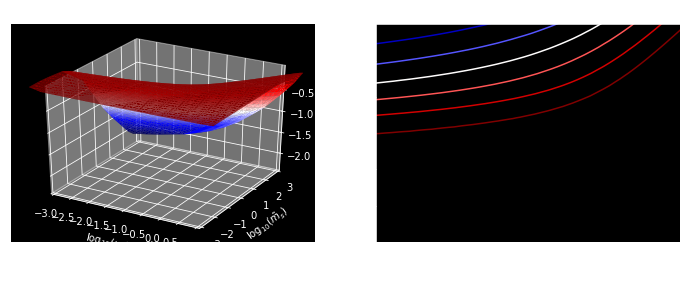

In [20]:
# Plot of field at surface

fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(121, projection='3d')

ax.plot_trisurf( triangles,
                np.log10(abs(phi_rs_array).compressed()),  
                cmap='seismic' )

ax.set_xlabel(r'$\log_{10}(x_0)$')
ax.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax.set_zlabel(r'$\log_{10}(|\phi(x_0)|/\phi_0)$')

ax.set_xlim(-3,1)
ax.set_ylim(-3,3)


ax2 = fig.add_subplot(122)
ax2.tricontour( triangles,
                np.log10(abs(phi_rs_array).compressed()),  
                cmap='seismic' )

ax2.set_xlabel(r'$\log_{10}(x_0)$')
ax2.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax2.set_title(r'$\log_{10}(|\phi(x_0)|/\phi_0)$')

ax2.set_xlim(-3,1)
ax2.set_ylim(-3,3)

(-3, 3)

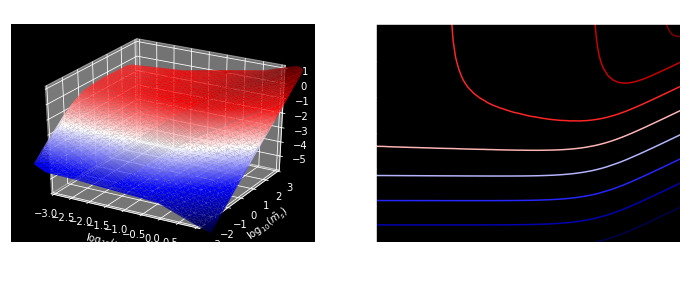

In [23]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121, projection='3d')

ax.plot_trisurf( triangles,
                np.log10(abs(grad_rs_array).compressed()),  
                cmap='seismic' )

ax.set_xlabel(r'$\log_{10}(x_0)$')
ax.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax.set_zlabel(r'$\log_{10}(r_0|\nabla\phi(x_0)|/\phi_0)$')

ax.set_xlim(-3,1)
ax.set_ylim(-3,3)


levels = np.linspace( -4, 2, 10 )

ax2 = fig.add_subplot(122)
ax2.tricontour( triangles,
                np.log10(abs(grad_rs_array).compressed()),  
                cmap='seismic', levels=levels )

ax2.set_xlabel(r'$\log_{10}(x_0)$')
ax2.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax2.set_title(r'$\log_{10}(r_0|\nabla\phi(x_0)|/\phi_0)$')

ax2.set_xlim(-3,1)
ax2.set_ylim(-3,3)

(-3, 3)

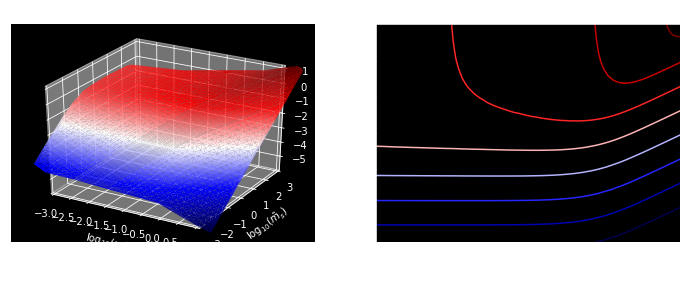

In [24]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121, projection='3d')

ax.plot_trisurf( triangles,
                np.log10(abs(max_grad_array).compressed()),  
                cmap='seismic' )

ax.set_xlabel(r'$\log_{10}(x_0)$')
ax.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax.set_zlabel(r'$\rm{max}[\log_{10}(r_0|\nabla\phi|)/\phi_0]$')

ax.set_xlim(-3,1)
ax.set_ylim(-3,3)

ax2 = fig.add_subplot(122)
ax2.tricontour( triangles,
                np.log10(abs(max_grad_array).compressed()),  
                cmap='seismic', levels=levels )
ax2.set_xlabel(r'$\log_{10}(x_0)$')
ax2.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax2.set_title(r'$\rm{max}[\log_{10}(r_0|\nabla\phi|)/\phi_0]$')

ax2.set_xlim(-3,1)
ax2.set_ylim(-3,3)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


(-3, 3)

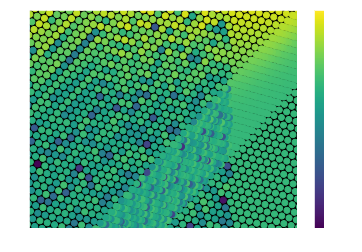

In [25]:
# Comparison of Derrick's theorem terms: should be equal

sm = np.sqrt( derrick1_array**2 + derrick2_array**2 )
rel_diff = abs( derrick1_array - derrick2_array ) / sm

cbar = plt.scatter( log_x0, log_ms, c=np.log10(rel_diff) )
plt.colorbar(cbar)

plt.xlim(-3,1)
plt.ylim(-3,3)

(-3, 3)

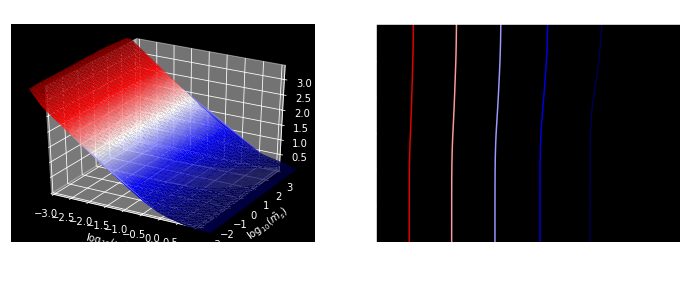

In [26]:
# Plot of healing length in units of source radius

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121, projection='3d')

ax.plot_trisurf( triangles,
                np.log10(np.abs(healing_array.compressed())),  
                cmap='seismic' )

ax.set_xlabel(r'$\log_{10}(x_0)$')
ax.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax.set_zlabel(r'$\log_{10}(x_{\rm heal}/x_0)$')

ax.set_xlim(-3,1)
ax.set_ylim(-3,3)


ax2 = fig.add_subplot(122)
ax2.tricontour( triangles,
                np.log10(np.abs(healing_array.compressed())),   
                cmap='seismic' )

ax2.set_xlabel(r'$\log_{10}(x_0)$')
ax2.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax2.set_title(r'$\log_{10}(x_{\rm heal}/x_0)$')

ax2.set_xlim(-3,1)
ax2.set_ylim(-3,3)

(-3, 3)

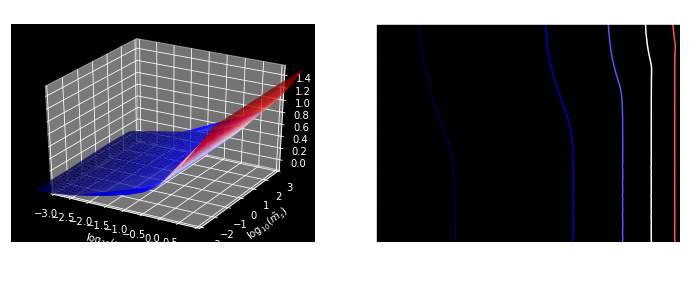

In [27]:
# Plot of healing length in units of 1/mu

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121, projection='3d')

ax.plot_trisurf( triangles,
                np.log10(np.abs(Healing_array.compressed())),  
                cmap='seismic' )

ax.set_xlabel(r'$\log_{10}(x_0)$')
ax.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax.set_zlabel(r'$\log_{10}(x_{\rm heal})$')

ax.set_xlim(-3,1)
ax.set_ylim(-3,3)


ax2 = fig.add_subplot(122)
ax2.tricontour( triangles,
                np.log10(np.abs(Healing_array.compressed())),   
                cmap='seismic' )
ax2.set_xlabel(r'$\log_{10}(x_0)$')
ax2.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax2.set_title(r'$\log_{10}(x_{\rm heal})$')

ax2.set_xlim(-3,1)
ax2.set_ylim(-3,3)

(-3, 3)

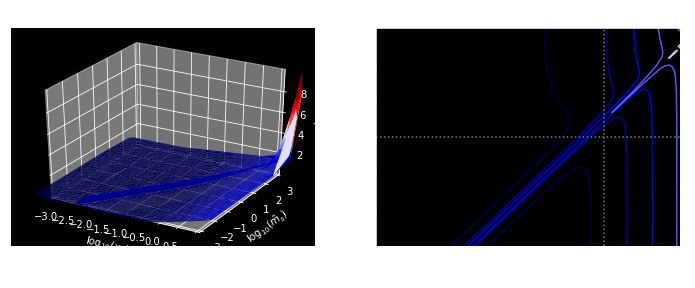

In [30]:
# Plot of scalar charge ratio

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121, projection='3d')

log_ratio = np.log10(np.abs(newcharges_array.compressed())) - \
        np.log10(np.abs(oldcharges_array.compressed()))

ax.plot_trisurf( triangles,
                log_ratio,  
                cmap='seismic' )

ax.set_xlabel(r'$\log_{10}(x_0)$')
ax.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax.set_zlabel(r'$\frac{\lambda_{\rm full}}{\lambda_{\rm approx}}$')

ax.set_xlim(-3,1)
ax.set_ylim(-3,3)

levels = np.linspace( -3, 3, 20 )

ax2 = fig.add_subplot(122)
ax2.tricontour( triangles,
                log_ratio,   
                cmap='seismic', levels=levels )
ax2.set_xlabel(r'$\log_{10}(x_0)$')
ax2.set_ylabel(r'$\log_{10}(\tilde{m}_s)$')
ax2.set_title(r'$\frac{\lambda_{\rm full}}{\lambda_{\rm approx}}$')


plt.axhline(0,ls=':', color='grey')
plt.axvline(0,ls=':', color='grey')

ax2.set_xlim(-3,1)
ax2.set_ylim(-3,3)